<h1> dada2 pipeline for Taiwan reads</h1>

We're using the <a href='https://www.bioconductor.org/packages/release/bioc/html/dada2.html'>dada2</a> pipeline here. I'll try following [this tutorial](http://benjjneb.github.io/dada2/tutorial.html) Let's dive in. 



<a id='contents'></a>

[Work Environment](#installpackages)

[Getting leaf reads ready for dada2](#prepleafReads)
- [Demultiplexing leaf reads](#demultiplex)
- [Removing primers](#removeprimers)

[Getting wood reads ready for dada2](#prepwoodReads)

[DADA2 pipeline for leaf reads](#dada2leaf)
- [Visualizing read qualities](#VisualizeQscores)
- [Filter and trim reads](#leafFilterTrim)
- [Learn error rates](#leafLearnError)
- [Dereplication](#leafDerep)
- [Sample inference](#leafSampleInference)
- [Merging paired ends](#leafMerge)
- [Construct sequence table](#leafSequenceTable)
- [Remove Chimeras](#leafChimeras)
- [Assign taxonomy](#leafTax)

[DADA2 pipeline for wood reads](#dada2wood)
- [Visualizing read qualities](#VisualizeWoodQscores)
- [Filter and trim reads](#woodFilterTrim)
- [Learn error rates](#woodLearnError)
- [Dereplication](#woodDerep)
- [Sample inference](#woodSampleInference)
- [Merging paired ends](#woodMerge)
- [Construct sequence table](#woodSequenceTable)
- [Remove Chimeras](#woodChimeras)
- [Assign taxonomy](#woodTax)

<a id='installpackages'></a>
<h1>Work Environment</h1>


Shell variable shortcuts:

In [7]:
## set some primer name shortcuts:
ITS1f=CTTGGTCATTTAGAGGAAGTAA
degenITS1f=CTTGGT..TTT..A.G.A.TAA
ITS1fRC=TTACTTCCTCTAAATGACCAAG
ITS2=GCTGCGTTCTTCATCGATGC
ITS2RC=GCATCGATGAAGAACGCAGC
degenITS1f=CTTGGT..TTT..A.G.A.TAA

<h3>dada2</h3>

In [1]:
source("https://bioconductor.org/biocLite.R")

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help


In [9]:
biocLite("dada2")

BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.3 (2017-11-30).
Installing package(s) ‘dada2’
Warning message in install.packages(pkgs = doing, lib = lib, ...):
“installation of package ‘dada2’ had non-zero exit status”installation path not writeable, unable to update packages: codetools, lattice,
  spatial
Old packages: 'Matrix'


In [1]:
library(dada2)

Loading required package: Rcpp


In [11]:
biocLite(ask=FALSE)

BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.3 (2017-11-30).
installation path not writeable, unable to update packages: codetools, lattice,
  spatial
Updating packages 'Matrix'
Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘Matrix’ had non-zero exit status”Updating HTML index of packages in '.Library'
Warning message in file.create(f.tg):
“cannot create file '/usr/share/R/doc/html/packages.html', reason 'Permission denied'”Warning message in make.packages.html(.Library):
“cannot update HTML package index”

In [13]:
biocValid() 

[1] TRUE

In [2]:
packageVersion("dada2")

[1] ‘1.6.0’

<a id='prepleafReads'></a>
<h1>Getting leaf reads ready for dada2</h1>

Before we begin the dada2 pipeline, we need to demultiplex our leaf reads, clean off primers and any other non-biological parts of our sequences, and make sure that forward and reverse reads are in the same order in the fastq files.  

<a id='demultiplex'></a>
<h2>Demultiplexing leaf reads</h2>

Wood reads are demultiplexed, but for the leaves are not. They were labeled using split golay barcodes, so we need to reassemble these barcodes, for both the forward and reverse reads. I have a script for this. The latest version is in this repository, BCunsplit.py

But, as I'm not much of a programmer, this script doesn't handle big read sets very well, somehow gets bogged down despite my effort to keep the entire files from being loaded into memory. So let's break up the leaf reads, apply the script, then reassemble. Most of this is in the shell, not R.

In [1]:
pwd

/home/daniel/Documents/taiwan/taiwan_dada2


In [8]:
leafR1=/home/daniel/Documents/taiwan/leafreads/TaiwanFA_R1.fastq
leafR2=/home/daniel/Documents/taiwan/leafreads/TaiwanFA_R2.fastq

In [4]:
mkdir leafR{1..2}sub

In [6]:
## break up the fastq files, keep things in multiples of four...
split -d -l 10000000 $leafR1 leafR1sub && \
split -d -l 10000000 $leafR2 leafR2sub

Now cycle through these, apply our script to each:

In [1]:
cd /home/daniel/Documents/taiwan/taiwan_dada2/leaf_recombine

In [3]:
nus=(00 01 02 03 04 05 06 07)
for i in ${nus[*]}
do
../BCunsplit.py leafR2sub$i leafR1sub$i
echo $i done!
done

00 done!
01 done!
02 done!
03 done!
04 done!
05 done!
06 done!
07 done!


Combine:

In [5]:
cat rearranged_leafR1sub0* > rearranged_leafR1.fastq && \
cat rearranged_leafR2sub0* > rearranged_leafR2.fastq 

Some sanity checks:

In [9]:
## take the first six BP of the first 10 reads from 
## the forward reads and the old... 
## check to see if they are the same
aa=$(head -n 40 rearranged_leafR2.fastq | sed -n '2~4p' | cut -c -6)
bb=$(head -n 40 $leafR2 | sed -n '2~4p' | cut -c -6)
echo $aa
echo $bb
if [ "$aa" == "$bb" ]; then echo "true"; fi

CACCTC CTTCCT CGTTAA CCTCCT CCACAT TCTCCA CCTCGC CCCCAT CCTGAT CACCTC
CACCTC CTTCCT CGTTAA CCTCCT CCACAT TCTCCA CCTCGC CCCCAT CCTGAT CACCTC
true


In [10]:
## take the first six BP of the last 10 reads from  
## the forward reads and the old
## check to see if they are the same
aa=$(tail -n 40 rearranged_leafR2.fastq | sed -n '2~4p' | cut -c -6)
bb=$(tail -n 40 $leafR2 | sed -n '2~4p' | cut -c -6)
echo $aa
echo $bb
if [ "$aa" == "$bb" ]; then echo "true"; fi

AATGAG CCCCTT AATGAT TCGCCT CCGCAT CACCTC CCTCCT CCTCAT ATAATT CTTTTN
AATGAG CCCCTT AATGAT TCGCCT CCGCAT CACCTC CCTCCT CCTCAT ATAATT CTTTTN
true


In [16]:
## take the first 12 BP of the first 10 reads from  
## the forward reads and the reverse
## check to see if they are the same
aa=$(head -n 40 rearranged_leafR2.fastq | sed -n '2~4p' | cut -c -12)
bb=$(head -n 40 rearranged_leafR1.fastq | sed -n '2~4p' | cut -c -12)
echo $aa
echo $bb
if [ "$aa" == "$bb" ]; then echo "true"; fi

CACCTCTCCTCT CTTCCTTCTTCT CGTTAACATACC CCTCCTTTCCTT CCACATCTATCT TCTCCATGCCCG CCTCGCTTCCCT CCCCATCATACC CCTGATTTCAAA CACCTCTATGAG
CACCTCTCCTCT CTTCCTTCTTCT CGTTAACATACC CCTCCTTTCCTT CCACATCTATCT TCTCCATGCCCG CCTCGCTTCCCT CCCCATCATACC CCTGATTTCAAA CACCTCTATGAG
true


Check first and last headers of the old and new reads - do the match where they need to?:

In [11]:
sed -n '1p' <(head $leafR1)
sed -n '1p' <(head rearranged_leafR1.fastq)
sed -n '1p' <(head $leafR2)
sed -n '1p' <(head rearranged_leafR2.fastq)

@HWI-M01380:62:000000000-A65GR:1:1101:12879:1376 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:12879:1376 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:12879:1376 4:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:12879:1376 4:N:0:


In [12]:
sed -n '1p' <(tail -n 4 $leafR1)
sed -n '1p' <(tail -n 4 rearranged_leafR1.fastq)
sed -n '1p' <(tail -n 4 $leafR2)
sed -n '1p' <(tail -n 4 rearranged_leafR2.fastq)

@HWI-M01380:62:000000000-A65GR:1:2119:10036:25269 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:2119:10036:25269 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:2119:10036:25269 4:N:0:
@HWI-M01380:62:000000000-A65GR:1:2119:10036:25269 4:N:0:


First and last headers all look good. 

Spot check that the quality scores match in length with the sequence length:

In [19]:
expr length $(sed -n '2p' <(head -n 10 rearranged_leafR2.fastq))
expr length $(sed -n '4p' <(head -n 10 rearranged_leafR2.fastq))
echo ----------------
expr length $(sed -n '2p' <(tail -n 4 rearranged_leafR2.fastq))
expr length $(sed -n '4p' <(tail -n 4 rearranged_leafR2.fastq))
echo ----------------

307
307
----------------
307
307
----------------


In [20]:
echo $(sed -n '2p' <(tail -n 4 rearranged_leafR2.fastq))
echo $(sed -n '4p' <(tail -n 4 rearranged_leafR2.fastq))
expr length $(sed -n '2p' <(tail -n 4 rearranged_leafR2.fastq))
expr length $(sed -n '4p' <(tail -n 4 rearranged_leafR2.fastq))

CTTTTNCTTTCTTNNNCTCTNNNNNNNNNNNTNNNTNNNNNTCCCCTTNNNNCNNTTCTTCTCCCTCTTTCTTCTCCTTCCCTCCTTTCTTCCCTCTTNTTCCTCTCTTCTCTCCTCTTTTCCTTCCCCTCTTCCCTTCTCCTCTTCTCCTTCTCCCCCCCCCCCTCCCCCTCCCCCTTCCTTCCCCCTCCCTTCCCCCTCCCCCTCCCCTTCTCCCTCTCTCCTCCTCCCTCCCTCCTCTCCCTTCCCTTCTTTTTCTTCCCCTCTCTTCTCCCCTCCTCTTCTTTTCTCCTTTCCCTCCCTTCTT
###################################################################################################################################################################################################################################################################################################################
307
307


Okay, sanity seems checked. 

<h3> Split the barcodes! </h3>

Fastx wants all sample names in the mapping file to be purely alphanumeric. Since we have some periods in our sample names, use sed to fix this:

In [26]:
sed -i 's/\.1/A/' leafread_fastx_map.txt && sed -i 's/\.2/B/' leafread_fastx_map.txt

Make a nest for the new files:

In [23]:
mkdir leaf_demult_fastx && mkdir leaf_demult_fastx/R{1..2}_demult 

Now use a fastx script [fastx_barcode_splitter](http://hannonlab.cshl.edu/fastx_toolkit/commandline.html#fastx_barcode_splitter_usage) to demultiplex. We'll let one barcode mismatch occur, and allow partial matches of 1 bp.

In [24]:
cd /home/daniel/Documents/taiwan/taiwan_dada2/leaf_demult_fastx/R1_demult
cat ../../rearranged_leafR1.fastq | fastx_barcode_splitter.pl --bcfile ../../leafread_fastx_map.txt --prefix leafR1_  \
--bol --mismatches 1 --partial 1

Barcode	Count	Location
1	276173	leafR1_1
100	162293	leafR1_100
101	172051	leafR1_101
102	155374	leafR1_102
103	80347	leafR1_103
104	110477	leafR1_104
105	41854	leafR1_105
106	69	leafR1_106
107	118640	leafR1_107
108	41186	leafR1_108
109	26500	leafR1_109
110	119550	leafR1_110
111	212370	leafR1_111
112A	361	leafR1_112A
112B	18903	leafR1_112B
113A	970	leafR1_113A
113B	95	leafR1_113B
114	87023	leafR1_114
115	206173	leafR1_115
116	137356	leafR1_116
117	84449	leafR1_117
118	138033	leafR1_118
119	101369	leafR1_119
12	21711	leafR1_12
120	40949	leafR1_120
121	64312	leafR1_121
122	80257	leafR1_122
125	146097	leafR1_125
126A	93040	leafR1_126A
126B	349	leafR1_126B
127	145417	leafR1_127
128	96370	leafR1_128
129	56948	leafR1_129
13	395872	leafR1_13
130	89939	leafR1_130
131	150279	leafR1_131
132	158729	leafR1_132
133	12863	leafR1_133
14	68246	leafR1_14
15	222655	leafR1_15
16	197498	leafR1_16
17	131235	leafR1_17
18	2369	leafR1_18
19	14503	leafR1_19
2	11861	leafR1_2
20	643997	leafR1_20
21	203507	leafR1_

Repeat for R2. 

In [25]:
cd /home/daniel/Documents/taiwan/taiwan_dada2/leaf_demult_fastx/R2_demult
cat ../../rearranged_leafR2.fastq | fastx_barcode_splitter.pl --bcfile ../../leafread_fastx_map.txt --prefix leafR2_  \
--bol --mismatches 1 --partial 1

Barcode	Count	Location
1	276173	leafR2_1
100	162293	leafR2_100
101	172051	leafR2_101
102	155374	leafR2_102
103	80347	leafR2_103
104	110477	leafR2_104
105	41854	leafR2_105
106	69	leafR2_106
107	118640	leafR2_107
108	41186	leafR2_108
109	26500	leafR2_109
110	119550	leafR2_110
111	212370	leafR2_111
112A	361	leafR2_112A
112B	18903	leafR2_112B
113A	970	leafR2_113A
113B	95	leafR2_113B
114	87023	leafR2_114
115	206173	leafR2_115
116	137356	leafR2_116
117	84449	leafR2_117
118	138033	leafR2_118
119	101369	leafR2_119
12	21711	leafR2_12
120	40949	leafR2_120
121	64312	leafR2_121
122	80257	leafR2_122
125	146097	leafR2_125
126A	93040	leafR2_126A
126B	349	leafR2_126B
127	145417	leafR2_127
128	96370	leafR2_128
129	56948	leafR2_129
13	395872	leafR2_13
130	89939	leafR2_130
131	150279	leafR2_131
132	158729	leafR2_132
133	12863	leafR2_133
14	68246	leafR2_14
15	222655	leafR2_15
16	197498	leafR2_16
17	131235	leafR2_17
18	2369	leafR2_18
19	14503	leafR2_19
2	11861	leafR2_2
20	643997	leafR2_20
21	203507	leafR2_

Check the order... we'll do this by reading the lane coordinates from each R1 and R2 file and make sure they are the same. We can spot check multiple samples:

In [27]:
## set our directories for these reads
R1dmult=/home/daniel/Documents/taiwan/taiwan_dada2/leaf_demult_fastx/R1_demult
R2dmult=/home/daniel/Documents/taiwan/taiwan_dada2/leaf_demult_fastx/R2_demult

We can clip the headers with sed:

In [32]:
sed -n "1~4p" <( head -n 40 $R1dmult/leafR1_79)

@HWI-M01380:62:000000000-A65GR:1:1101:17095:1547 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:23330:2135 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:11376:2177 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:11439:2216 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:10211:2299 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:23344:2305 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:8367:2368 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:22094:2660 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:11892:2755 1:N:0:
@HWI-M01380:62:000000000-A65GR:1:1101:24413:2997 1:N:0:


Then cut:

In [33]:
sed -n "1~4p" <( head -n 40 $R1dmult/leafR1_79) | cut -d : -f 6,7 | cut -d ' ' -f 1

17095:1547
23330:2135
11376:2177
11439:2216
10211:2299
23344:2305
8367:2368
22094:2660
11892:2755
24413:2997


In [39]:
sed -n "1~4p" <( head -n 40 $R2dmult/leafR2_79) | cut -d : -f 6,7 | cut -d ' ' -f 1

17095:1547
23330:2135
11376:2177
11439:2216
10211:2299
23344:2305
8367:2368
22094:2660
11892:2755
24413:2997


So do this on a larger scale, on several files, and let BASH figure out for us if they are the same:

In [34]:
aa=$(sed -n "1~4p" <( head -n 100000 $R1dmult/leafR1_79) | cut -d : -f 6,7 | cut -d ' ' -f 1)
bb=$(sed -n "1~4p" <( head -n 100000 $R2dmult/leafR2_79) | cut -d : -f 6,7 | cut -d ' ' -f 1)
if [ "$aa" == "$bb" ]
then echo "same!"
else echo "different!"
fi

same!


In [40]:
aa=$(sed -n "1~4p" <( tail -n 100000 $R1dmult/leafR1_100) | cut -d : -f 6,7 | cut -d ' ' -f 1)
bb=$(sed -n "1~4p" <( tail -n 100000 $R2dmult/leafR2_100) | cut -d : -f 6,7 | cut -d ' ' -f 1)
if [ "$aa" == "$bb" ]
then echo "same!"
else echo "different!"
fi

same!


In [37]:
aa=$(sed -n "1~4p" <( head -n 100000 $R1dmult/leafR1_103) | cut -d : -f 6,7 | cut -d ' ' -f 1)
bb=$(sed -n "1~4p" <( head -n 100000 $R2dmult/leafR2_103) | cut -d : -f 6,7 | cut -d ' ' -f 1)
if [ "$aa" == "$bb" ]
then echo "same!"
else echo "different!"
fi

same!


Etc, etc. Seems like the fastx demultiplexer maintained read order. 

<a id='removeprimers'></a>
<h3>Removing Primers</h3>

Sounds simple, right? But for the leaves we have at least three types of primers to remove, I think. We have not only the classic, beginning-of-line primers (+ sample barcodes) to remove, but also two other kinds: The first is the runover - it looks like on many of these sequences, sequencing continued past the opposite primer to go to the standard cycles of ~300 bp. These reverse-compliment primers and downstream runover sequence are hopefully taken care of by merging paired-end reads. But we can check on this post-pipeline. 

Then there are floating primer sequences that appear in the middle of the ITS1 region. And that just don't make any sense. So we'll throw sequences with these floater primer sequences out entirely, because we are scared of them. However, we'll also have to wait here, because I think it will make more sense to do this somewhere in the dada2 pipeline after merging paired ends. Otherwise I spend more time than I want to building a script to maintain orders of sequences in the files as we remove the floating primers, that may not be in their partner sequences. 

<h3>Removing BOL barcodes and primers</h3>

Each sequence should begin with a 12 bp sample barcode. In addition, each read should have some BPs representing the primers (ITS1f or ITS2), this is also easy to clip. 

Barcodes are 12 bp long, ITS2 has a length of 20bp ...so... for R1 reads:

12 bp + 20 bp = 32 bp should be chopped off R1 reads. 

ITS1f has 22 bp:

12 bp + 22 = 34 bp should be chopped off the R2 reads.

Does this fit? For instance, does ITS2 sit where we think it does in the R1 reads?

In [ ]:
grep GCTGCGTTCTTCATCGATGC <(head -n 1000 rearranged_leafR1.fastq)

Looks right, and for ITS1f? These primer sections of the reads are really degenerate, for some reason. So we'll put a lot of wildcards into the primer sequence when we search for it:

In [72]:
grep CTTGGT..TTT..A.G.A.TAA <(head -n 10000 rearranged_leafR2.1.fastq)

CTTCCTTCTTCTCTTGGTNCTTTCTATGCACTAAAAGTCGTAACACTGTTTCCGTATTTGAACCTTCTGATGTCTCCTTACCTTTTTCTGTTCCTCTGGCCCTCCCTTTCCTCACTCCTGATTTCACTCCCTTTCGTTCTGCCGTTCGCGGTCCCTTTCCCCCCCGCTCGTTTTGCTTTCACTTACCTTCTTTTCTTGCCCCTCTCTGTCTTTCACTACTTCCCAAAACTTTCCACCCCCTTTCCCTTTTCCCCCCCACCCTCTCTTACCCCCCCCCTACACGCTCTGCCACGCCTCCTTCTTCTCC
CCTCGCTTCCCTCTTGGTNATTTAGAGGAATTAACAGTCGTCACTATGTCTCCGTTTGTGAACCAGCGGTGGGATCATTCTTGTTTTTCCCCTCTACCTCCCTTTGTTTCCCTTCCTTTAACTTTTCCTTCCTCTTGCCTCCTCCCCCTTACCCCCCCCGCCTCCCCCCCCCCGACGGTCCGGCCCCCCCTCGCCTCCACTCCCCCTCTGTTTTCCCCTCCTTTCTTCTGACTACTACCTTCTTATACTCACTCCTTTCACCACCCCTCCTCTTTGTTCTTCCTCCTCTCACTACCCCCCCCGTCCC
CCTGATTTCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACCAGGTCTCCGTTGGTGAACCAGCGGAGGGATCCTTATCGAGTTACCACTCTATAACCCTTTGTGAACATACCTCCATGTTGCTTCTGCGGTCGGCCCCCCTTCCCCCCGCCCCCGCTCCCGCGGGTCGTCCGCCGCAGGTTCACCACCCTCTGTTTTCCCGCCGTTTCTTCTGCTTGGCCCCTCCAACTAATCAAACCTTTTACCCCCCGTTCTCTTCGTTCTTGCCTCCTTCAACCCCCCCGCCTTTCTTCTTCCGCATCAC
CCCCATCATACCCTTGGTNATTTCGAGGCAGTAAAAGTCGTAACCATTTCTCCGTTTGTTAACCAGCGGAGGGCTC

CCCCATTTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGACCCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACCCAAATTGACCTATCCTTTGTTTTCCTCGGTTGTCGGCTCTGCTTAGCCCCTGGCCCCCATACGGCGCTCACCTTTGGACCAGTCTTGTTTGTATCTGTACTCATTAATCGTCAGTCCCTACTTTCAACAATGTCTCTCTTTCCTCTCGCACCCATTTCTATTCCTGCTGCTCTCTCTTTCTCTCCCTCCTTC
CACCTCTCTTCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACATTATATTGTTATGCGTTGTCTAGTGTTTTGCTTAGCACTTTCACTTACCAACCTAACTATATATACACCCATGTTTTTTCAGTACCTCCCGTTTCCTCGGCAGGCCCGCCTGTCCGTAGGACCACTATTAAACCTATTTTTACTTTAGTCTGCGTCAGCATCTATAACTCTTATACCTTTCAACATCGCTTCCCTTTGTTCTTTCATCCTTTACTTACCCTACCA
CCGCATTACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACCATGTCTCCGTAGTTGAACCTGCTGAGGGATCATTACTGAGTGAGGGCTCACGCCCGACCTCCAACCCTTTGTGAACACATCTTTTTTCTTCGGGGTCGACCCTTCCGGCACTTCTTCTCCTGGCGCCCCCGACGTTCTCCACACACTGCTTCTTTTCGTCTCATTTTAAACAACTTAACCCAAACTTTCCCCCACTGCTCTCTTTCTTTTTCCATCTCTCTACCACCCTCCCCCCTTTAATCCTCAATCTCTTCTTTCTGCC
CTCAAATATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

CGTGATTGCCCGCTTGGTNATTTAGAGGCAGTAAAAGTCGTATCCCTGTCTCCGTAGGTTAACCTGCGGCGGGATCCTTCCTGAGTGAGGGCTCACGCCCGACCTCCAACCCTTTGTGAACACCTCTTGTTGCTTCGGGGGCGACCCTGCCGGCACTTCGTCGCCGGGCGCCCCCGAAGGTCTCCACACACTGCATCTTTGCGTCTGCGTTTACACCAATTACCCAACCCTTTCCACATCGGATCTCTTTGTTCTGCCTTCCATGACGTCCTCCTCCGGGCACGATCGGCACACCCTCCTTTTGGTC
CCTGATCTATCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTTCAACACTCCCACCACCATCGTGAACCCCCCTACCGTTGCCTCGGCGGGCGGCCGGCCTACCCTCCCCAGCGCCTGCCTCGCCTTCTTTCCCCCTTCCCCCCTGGCCCCGGCTCCCCCCGCCCCCGTCCCCCTACCCTCCTTCCCCACTCCTCCCCCTCTTACCTCTCCACCTCCCTCCACACTTCCCCCCCTTGTCTCTCTTTTCTTTCCCACCTCTAC
CATGAGTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTTTCCGTAGGTGAACCTGCGGAAGGATCATAAAGACGCTTCGGCTCTAGCCGGAGCGCACTTCCACACTGAGTATAACTTCTAGGATAATACATATACACAATCAGATTATTTAAATCTCCTCCCACCGTATCTCTTGGCTCTCGCCTCTCTTAATAACGCAGCGTTATACGTTCGGCAGAGCGTCCTTTAGGCACAGCGTTTGTTTCTCGCTTCTCTCCGTTTCCTTACCCCTATCCTCCTTTCCTCCGCTCTACCTT
CCGCATCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CTCAAACTCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTTACGCTCTACCACCCTTTGTGTACCTACCTATAACTGTTTCTTCGGCGGGTAGGGTCTCCCTTACCCTCCCGGCCTCCCGCCCCCGGGCGGGTCGGCCCCCGCCGGCCGCTATCCAAACCCTGATTTACCCACGTTTCTTCTGAGTTGTACCAGCAAATAATCAAACCTTTTTCCACCCGATCTCTTTGTTCCGGCCTCGATTATATAAGCACCTTTTCT
CACCTCCTACAGCTTGGTNATTTAGAGGCAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGCACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCCGACCTCCCGCTACCTGCCTACCACACCCCTGTTGCCTCGCCGGGCCCCGCGCCCGGCCCCTGACCTTGACCCCTACCGTTACTTCGGTCAGTGCCCCTTTCGACCCCCCAACACTTTCCACCACGCATCTCTTTTCCCTGTCATCCTTCACTACCGCACCCTCTTGCTTTCCGCTTCTCCTCCTCTTCTTCCATC
CGCCATCTACAGCTTGGTNATTTCGAGGCAGTAAAAGTCGTAACACGGTCTCCGTAGGTGAACCTGCGGAGGGATCCTTACCGAGTGAGGTCTCTCCCCCTACCTCCCTCCCTGTGTGAACGCCATTCTCGTTTCTTCCGGTCCCACCCTTCCTTTGCGCCCCCGCCTCTCCTCTCACCTCTGCCTCCCTTCTTCCGCTTCCAATTTACTCCAACCACACTTTCACCACCTCATCTCTTTTTTCTCGCACCTTTCTCGAACCCACCCTTTACCCCTTGTCTCATCATCGTCTCTTTCCCATCCTTTT
CGTTAACATACCCTTGGTNATTTAGAGGAAGTAAATGTTGCACTTTATTCAAAACAAAAGTACAAATATGCAAAGC

CGTGATCCCGTACTTGGTNATTTAGAGGAAGTAACAAATGACAAGAACGAAGTACGCATACATCAAAGGAGTACAATAATGGCATAAACGTTAAGACCACCGAGCATCGCTGAAGCACGCAGCTACGGCCGATCGGAAGAGCGTCGTGTAGGGAAAGCGTGTAGCTCTCGGTGGTTGCCTCACTCTTATCATCTTACATGTTTCTTACTTTTCACTTTCTCTCCTCCCTTCCTCTCCTTCTTCTCTCCTTTCTCTCCCTTTACCCTCCTCTTCTCCTTTCCTCTCCCTTCTCTCTTCCCTTTTCTCT
CGTGATTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATTTCTCCGTTGTTGAACCAGCGGATGGATCATTAGGACTCTCAAGAGTTGTAAACCACTGTTAACTTACCTACCCGTTGCCTCGGCGTGTGCCCCGTTTCGCCGCGGCGCTCGCCCGCCGTTTGCCCCCCTCCCTCTCTCTGCCTTGCCTTCCCCAGCAACTTCACTCTCTTTATCACTTTCACCACCCTCTCTCTTCGCTCTTCTCTCCATGACAACCCCACCTTCTTCACACCTCTACTGCCTCCTCTCGTGTATCATC
CTCAAATTATTTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACTGAGTGCGGGCTCACGCCCGACCTCCAACCCTTTGTGAACCACTTGTTGCTTCGTGTGCTACCCGGCCGTTTCGGCCGTCCGCGGCCCCCCCGGCGGCCTTCAAACCCTGCATCTTTGCGTCCGAGTTTAACATCAATTACACAAAACTTTCCACAACGGATCTCTTTGTTCTGGCCTCCCTTAACAACCCCTCCCATCCCCACCGCACTATCCTCCTTTACGGCC
CCTGATTTCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCTGATCTATCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGTTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTGCAAAACTCCCACAACCATCGTTACCCCACCTACCGTTGCCTCCCCGGTCTCCACTCTTACCCTCTCCAGCGTCTTTTACGCCCTCCTTCGCCCTTCCCCGCGCGCCTCCCGGCCGCCCCCCGGCCTCCCCCTAACCTCCCTCCCCAGTCCATCTCCTCTTCACGTTTCAAATCCCCACCAACTTTCACCTATTTTCCCCTTCGTTCTTGCCTCCATCAT
CACCTCCCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTATCGAGTTAGGGTTCCGTTCAGGGCCCAACCTCCAACCCTTTTGTTTACCAAACCATGTTGCTTCGGCGGGCCCGCTCCTCCGGGAGCCGCCGGGGGGTTTCTTACAACCCTCTTGCCCGTTGCCCTCCGTTTCCCCATCCCCAATTCTTGTTATACTGTGTCGTCTGTGTTATTTTCTAAATTAAAACAAAACTTTTAACAACGCTTCTCTTTGTTCCTTCCTTCCT
CGGCGCTTCCGTCTTGGTNATTTAGAGGAAGTAAAATCCGTAACAAGGTCTCCGTTGGTGAACCAGCTGAGGTATCATTGCTGGACGCGTCTCCCGGCCCCCCCACATACCCTTTGTTAACTTATCCCCCTGTTGCCTCCCCGCCTGCTTGGAGCTTCTTTTAACTCCCCCTCCCCGACCTCCCCCTCCGCCTTCCCCCACCCCTCCCGCCGCCCCTCCCCCTCTTTTTTTTCTTTTCTCTTCCTCCGTACCCCCCCACAATTTCCCCAATCTTTCCCAACCCCCTCCCTTCTTTCCTGCCTCTCTC
CGTGATCAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACACGGTTTCCGTAGGTGACCCTGCGGAAGGATC

CATGAGTTCCGTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTCTCCGTTTGTGAACCAGCGGAGGTATCATTCTTGAGTTTACGCTCTACAACCCTTTGTCAACATTCCTATAACTGTTGCTTCTGCTGCCAGGGTCTCCCTTACCCTCCCTTCCTCCCGCCCCCGCTCCTGTCCGCGCCCGCCCGCGGCTCACCCACCCTCTATTTAACCCCGTTTCTTCTTCCTCGTACTAGCCAATTACTCATACTTTTAACCACTGATCCTTTTTTTCTTGCCTCTATCTATATCCCACCCCCGCA
CCCCATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGCACCAGCGGAGGGCTCATTACCGAGTTGCAAAACTCCCCCCACCATCGTGAACCCACCTACCGTTTCCTCTGCGGTCGGCATGCCTCCCCCCCCCACGGTCTTCTACGCCTTCTTTCCCCCTTCCCCCCGTGCCCCGCTGCCCCCCCCCTCCGTACCCCTCCCCTCCCTCTCCCGTCCCTCCCCACTCAACTTCCCAACTCCACCCCACCTCTCCACAACCTTCCCCCTTTCTCTTCCCCCCACCAT
CGTTAACAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGAGTTGCAAAACTCCCAACACCCTCGCTAACCTCCCTCCCCGTTTCTTCTTCCTTCGGCCGTTAGCCCTCCCCTCTAACCCCGGGCCCCGTCCCCCCTCCCCACCCGCGCCCCCCTCCCGACGTACCCAACCCCACTTTTTTTTTCGTCTTCTCTCACTTTCACACCCCATTTTTCTACCCTTTCAACCACCGATCTCTTCTCCCTTGCCTCCCTCACCTACTCC
TCGCCACGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

TCGCCATATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGTAGGGATCATTATTGAGTTTACGCTCTACAACCCTTTGTGAACATACCTATAACTGTTGCTTCGGCTGGCAGGGTCTCCGTGACCCTCCCGGCCTCCCGCCCCCGGGCGGGTCGGCGCCCGCCGGCTGATCACCAAACTCTGTTTTAACGCCTTTTCTCCTGCGTGGTACTAGCCATTCACTCACATTTTTTACCTCTGCTCCCTTTGTTCTTTCTTTCTCTACAGACCCCCTTCTTTT
CGCCATCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCACGCCCGACCTCCACCCCTGTGTGAACGCAAATCTCGTTGCTTCGGGCGCTACCCTGCCGTGGCGCCCCCGGCGCTCATCTCAACTCTTCCTCTCTCCGTCGCAGTCACAGTTACTCCACCATACCTTTCACCAACCGTTCTCTTGTTTCTTCCCTCCTTCTACAACCCACCCTTCTTCACCCCGCCTACCATCCTGTTCTGTCTCTCTTTCT
CCTGATCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTTGGTGAACCAGCGGACGGATCATTACCGAGATCGGGCCCTCCGGGGCCGACCTCCCACCCTCTGTTACCACCCGTGTTGCTTTGGCGGGATCGCCCCCCCCCGTTGCCGCCCGCCCTCCCCCGGACCCCCCCCCCGTCCCCTCCCTCACCCCGCCCCTTTCCTCTTTTCTCTGCCCCCTCACCTACCACTTCATAACTTTTCACTACCCTACCCTTCCCCCCCTCCTCCTTTCATAACACAACCTTATTACA
CGTGATTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACCCTGTTTCCGTATGTGAACCTGCGGAAGGATC

CCGCATTAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGATCCAGCGGAGGGATCATTATCGATTTATTCAACTCCCAAACCCTATGTGAACTTACCACTTGTTTCTTCCGCGCTCGCTTCTGCGCCGCCGAGGACACTTCAACTCTTTGTTTTTATCAGCTTTTCTGTGTGGCCGTAACGCAAATTACAAATCAATCAACACTTTCCAAACTCGACCTCTAGTTTCTGGCCTCTTTGTACAACCTCGCCTTCTTACCTCCTACTATCTTTGTTTATGCTCCCGTC
CCCCATCTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGTTTTGCATCTCACAAATTGACCTATCCTTTGTTTGCCTCTGTTGTCTGCTCCGCTTTGCCCCTGGCCCCGAACGGCCTCTCACCGTTTGTCCATTCTTTTTTTAATCTTTTCTCTGTAAAATCAATTCCCAACTTTCTCCCATTGCTCTCTTCGCTCTGGCATCTCTATACTTCTCCCAGTGTATTTATCGTTCACGCTTCCTT
ACCCATTTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGTCTCGGTGGGCGCCTCAGCTTACCCCCTGGACCCCAACCGTCCCCTCCCCTTTACCCCTTCTTTTTTCCATCTTTATTCGTTAAATCAAGTTCCCTTCTTTCACCTTTTTTTCTCTTCTCCCTTCCTTCTTTTACACACCCCCCGCATTTCATTGTTCTATCCTTCCTT
CACCTCCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

CTAATTCTAGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGCGGGATCATTACTGAGTTACCGCTCTACAACCCTTTGTGAACATACCTAACCGTTGCTTCGGCGGGCCGGGGAATCCTCTCGCGGGCGACCCCTCCCGGCCCCGGCCCCACCACGGGTGCCGAGCTCCCCCCCGAGGCACCCAAACTCTCTTTACACGCCTCCCCTTCTGCTTTGCACAACCAACTTATTAAAACTTTTAACAACGCATCTCTTCTTTCTCGCTTCCATTCATACCCC
CCACATCTAAACCTTGGTNATTTAGAGGAAGTAAAAGTCGTACCAAGGTTTCCGTAGGTGAACCTGCGGAAGGCTCATTACTGAAATGTAACTACTTCTATTGCCAGTTTCCCGCGTAGGCTCTACAACGCCGAATTTACCTTCTCCCCCTTGTGTACTCACTATGTTCCTTTTTCGTGTCGCTCTCGTTCCGACCCCGCCGGCCGGCCCCCCCAGCCTTACCTGCCCCTGACCCCCGGCTAACTCCCCCCCACTATACCACCCCTCACCACTCCTTTTTTTACCTCCTTTTCTCCCTTTTCTTCTT
CACCTCTCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCCCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTACCGCTCTATAACCCTTTGTGAACATACCTACAACTGTTGCTTCGGCCGGTAGGCCGTCCCCTGAAAAGGACGCCTCCCGGCCCGCACCGGCCCCCCCCCGGGACCGGCCCCGGCCCCCCCCGCCTGCTCACCCCACCCTATTCTAACGACGTTTCTTCTGACTGCCCTAACCCAACTCATCAACCCTTTTAACCACGCACCTCTTTTTTCTTCCTTCCC
CTAATTCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTCTCCGTTGGTTACCCAGCGGAGGGATC

CCGCATCGTAGGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTTACAACTCCCAAACCCATGTGAACATACCTACTGTTCCTTCCGCGGGATCGCCCCAGGCGCCTCGTGTGCCCTGGACCCGGCGCCCGCCTAGGAACCTTAACTCTTGTTTTCTTCTGGATTCTTCTGACTCTTTTTTACAAATAACTAAAAACTTTCATCCACTGTTCTCTTTGTTCTTTCCTCCATCCAACACGCCCCCCTCCTTCTTCGGCATCCCCC
CACCTCTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTTACGCTCTACTACCCTTTGTGACCATACCTATAACTGTTGCTTCGGCGGGTAGTGTTTCCGTGACCCTCCCTGCCTCCCGCCCCCGCGCGGGCCGGCGCCCGCCTGCGTATACCCCATCTCCGACTTACCCACGTTTCCTCCTTTTGGTACAAGCTAATTCTCCAAACTTTTTACCCCGGACCCCTTTCCTCTGGCATCGCTTAGACAACCACCCGTGCC
CGCCATCAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTTACAAACTCCCAAACCCCTGTGAACCATACCATACTGTTGCCTCTGCGGGGTCTTCCACGCCACAACCAGGCGTGCCCGCCAGAGGACCCAAACTCTACTGTCTCTATTTACGTATGTCTTAGTGGATTTTTATATCAATGAATCACAACTTTTACAAACGGATCTCTTTGTTCTGGCTTCGTTTTATAACGCAGCCTTTTTCGATCTCATCAGCGTCGT
CTAATTCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTTGTGAACCAGCGGAGGGATC

CACCTCTCTTCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACATTATAGTGTTAGGCGTGGTCTAGTGTTGTGCTTAGCACTGTCCCTTACCAACCTAACTATATATACACCCATGTTTTTTAAGTACCTCCCGTTTCCTCGGCAGGCCCGCCTGTCCTTAGGACCACTATTAACCCTCTTTGTAGTGTAGTCTGCGTCCGACTTTATAACTATTCTAACTTTCAACAACGGATCCCCTGGTTCTGGCATCGCTGAACAACGCACCAA
TCTGATCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTTGGTGAACCAGCGGAAGGATCATTACCGAGATCGGTCCCTCCGGCGCCGCCCTCCCACCCTGTGTTACCACCCGTGTTGCTTTGGCCGGATCGCCCCCCCCCGAGCCCCCCCGGCGTCCCCCGGACGCCCCCGCCCTCCCCCCCCCCACCCCGCCCCGTGCGTTTCTCGTCTCAGCGTCAACACCTCTATTCCAAACTTCCCACTAACCGCTCCTTTCACCAGACCCCGTTCAACAAACACACACCATCAAA
CGCCATCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCCCGCCCGACCTCCAACCCTGTGTGAACGCAAATCTCGTTGCTTCGGGGCCGACCCTGCCGTTGCGCCCCCGGAGGTCCTCTCAACTCTGCATCTCTTCGTCCGCTTCAAAGTTAATCAAACAATACTTTCCACCCCGGATCCCTTTTTTCTGGCCTCTTTTTCGAACCCCCCCTGTATAGTTCGGTAGCTCCCCTCTCGGGCACCACTGTACC
CGTTAACTATTTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

ACTGATCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTTTCCGTTTGTGTACCAGCGGAAGGCTCATTACCGATATCGGGCCCTCCGGGGCCGACCTCCCACCCTGTCTTACCACCCGTTTTGCTTTGTCGCCCTCGGCCCCTCCCTCCCCCGCCCGTCCTCCCCCCGCCGCCCCCGCCGTACTCCCCCCCCACCCTCCCTGTTCCTCTTCCCCCTCACCCTCCTCTTTACCTCCCCACACTCTCCTAACCCCACCCCTTGCCCCCCCCTCCACCGCCCCTCCCCCCCCCATCATC
CACCTCCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTTGCCCCCCCTCGCAGGGTGGCAGACCTCCCGCTACCTGCCTACCCCACCCCTGTTGCCTCGCCGGGCCCCGCGCCCGGCCCAGGACCTTGCACCCTAACGTTCATGCGGTCAGAGCCCATTGCCAACATCCAAAACTTTCCACCACGGACCCCTTTGCTCTGGCCTCGATGAACACCCCCGCCTGTAGCCTCCGGGCGCGCCGCCTGGTGGGCACGC
CCGCATCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACCAGGTCTCCGTTGGTGACCCAGCGGAGGGCTCATTACCGAGTTTTCACCTCCCAAACCCCTTTGAACATCCCTATCGTTTCCTCCGCGGGAGAGCCCCGGTCGTTGGCGAAAGCCTCTCACCGGTATCACTCGCCCGCCCTAGGACCCAACCAACCCTTTTTTTCTCAAGACTCTTCTGATTAACCTTAAGTAATACATTAACACTTTCCCATACGGCTTTCTCTTTTCTTCCCTCGATTACGAACCCAACTCTTCGAACGTC
CATGAGTAAATGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CTCGAATAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTATCAAGAGTCTGCGCCATAAGTGCAGCTCGCCTCTCACCCTTGCTTCTACGCCCCTTTTGTTGTTTCCTCGGCGGGGCTTCCCCCTGCCGGTGGGCCGCCCATTTAACCCTTTCCCATCCGCATTCAACTTCTTAACCTAACCTAAATCTTTACACCTTTCCACCATCGATCTCTTGGTTTTTGCCTCCATTCATACCGCAGCCGTCTTACTTCGGTAACCCGTCCTC
CGCCATCTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTGCAAAACTCCCACAACCATCGTGAACCCACCTACCGTTGCCTCGGCTGGCGGCAGGCATACCCTCACCAGGGTCTGCTACGCCGTCTTTCCCTCTGCCCCCCCGCGCTCGGGTCCCCCCCCCGTCGGACACCTAACCTACTTCCCCCTTGCCCCCCCCTGTAACTTATCAATTACATCAAAACTTTCAAAAATCTCCCCCTTTGTTCTGTCATCTATAAC
CCCCATCTATCCCTTGGTNATTTAGAGGAAGTAAAATTCGTAACACGGTCTCCGTTGGTGACCCCGCGGAGGGATCATTACCGAGTTCCCTGAAACTCCCCAACCCTCTGCTAACCTTACCTGTATCGTTTCTTCCTCGGCCCGCCCTTCGCCCTGCGTTCCCTGGAACCAGCCTCTCCCCTTGCACCGTTCACACTCTCTTCCCCCCTCCCTGTCCACCCCGTACCCCCCCTTTCCAGGCCTCTCCCTCCCCGCCACCGCCTTTCTGCCCCCCGCACCCCCTGGCATCTCTCCGTCCACCCCTCTT
CATGAGCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCACATCTATCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATCGAGTTACCGCTCATAACCCTTTGTGAACATACCTATACCTGTTGCTTCGGCGGGTAGACGGCCTCGTTAAACAGGCCCCTCCCGGCCGCCCGTCCCCGGGTGGCCCCCGCCGGTGGCTCACCCACCTCCCATTTAACGCACTTTTTTCTGATTGGCCCCATTACTATCCTCCAAACTTTTAACCACAGACCTCTTGTCTCTCGCTTCCTACACTCTCCCACACCC
CCCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTTGACTCTCGCGTACCCTGCCGCATTGTATAACTCTAACTGTTCTCTCCTCTGCTCCCTTCGTTTCCCCGCGCAGCTCTGCCCCTCGTTCCTTTCCTCACCTCTTCGTTTTCCCCGTCTCTCTTAAATCCCTCTCCACTATCCCTTTCACCCTCCTCTCCATCTTTTATCCCTTTCCTTAACACCTCACACCTCCTCCACCTTTCTTCTTTCCTTACTGCTCCTCT
CGTGATTTCCGTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACTGATTCTGGTTGGCCCCTTACACCGGGCCCCCGCCCTCTTACACCCACTGTCAAATTTACACCTTGCCTGTTCCTCTGTCTGTCCCGTCCTTAACCCCACCTCCTCGTTCCTTTTTCCTCAACCTGTCCTCTGCCTCCTTTTCCTCCCCTCTCTCTCTTCCCTATCTCTTTTCCCAATTCCCTCTCCAACTTTTTCACCTCTTCTCTCCTCTATCTACCTACCTTC
CCTGGCTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

CCTGATCTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACCAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTGCAAAACTCCCACAACCATCGTGAACCCACCTACCGTTGCCTCGGCGGGCGGCAGGCATACCCTCCCCAGGGTCTGCTTCGCCGTCTGTCCCCCTTCCCCCCTGGGCCCGGGGGCGCCCGCCGGCGTACCCCTACACTACGTCTCCAGTTCCCCCCCGCCTACCCTTACCAATAATCCCAAACTTTCCAAAATTGTCTTTCTTTTTTCTCCATTTTCTCT
CTCAAATAGACGCTTGGTNATTTAGAGGAAGTAAAGGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGAATCGCAAGATCTCTGAAACCATTGTGAACATACCTAAACGTTGCCTCGGCGGTTTCCCGGCCCTGTTCCGGGCCCTGATCCCGCCGGCGGCCCCCTCACTCTTTCTTATTTTTTTCTCCCCTTGCCCTCAAAAAACCCATTCAACCCTTCCACCACTGTCCTCTTTGCTCCCCCATCCACCAAGACCCCCCCCCGCCTTCCTCCCCACTGCCTTCCTTTGTGC
CCTGAGCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATAGAGTTTTCTAATCTCCCAACCAATTTTAACTTTCCTTTTCGTTCCTCCGCCGGACTTATCGCTCTTCTTATATCTCCTTCCGCTGCACCATTACCCTCTCGTTATTTTATCTGGTCGCCACGTCTTTTTTTGTTTTGTCAATATTTTCAGCATCCGATCCCTGGGTTCCTACATCAATCAAAACCTCAAACATTCGATATCTTAGTTCCGTCCTGTATGAAACAA
CACCTCCTATCTCTTGGTNATTTAGAGGAAGTAAAAGCCGTAACAAGGTCTCCGTTGGTGAACCTGCGGAGGGATC

CTGCCTCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACACGGTTTCCGTAGGTGAACCTGCGGAAGGCTCATTAGAGATTGGCCTCCCGGCCGTTTCAAAACACACACACACACCGTGAACCGTTCCCTGGCCCCTCGGGGCCTTGGACCTATATCAAACCCAAATCGTAATTAATGTCATACATCGTCAACAAATATAACTTTCCACAACGGATCTCTTGGCCCCCTCATCGATAAAGCACGCACACCTTCGAGATCGATAAAGCCCCATCGCGGAACAGCGTGTACTTACCGGGTTCGT
CGTGATCGGGCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACCGAGATAGGGTCCCTTCGGGGGCCCGACCTCCCACCCTTTGTCTAATCTACTTTGTTGCCTCGGCGGGCCGCCGGGTGCCTGGAAACGGGCCCCGCCTTTGGCCTCACCGCTCTTTGAGTGCCCGCCGGTCGATTTTATTAACCCATTTTTACAACTACTCTTCTGAGTTAAATTTTTATCCTTCCAAACTTTCACAAACGGACTCCTTGTTTTCGCCCACCATTA
CTAATTTAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATAGAGTTTTCTAAACTCCCAACCCATGTGAACTTACCTTTTGTTGCCTCGGCAGAGGTTATAGGTCTTCTTATAGCTGCTGCCGGTGGACCATTAAACTCTTGTTATTTTATGTCATCTGAGCGTCTTATTTTAATAAGTCAACACTTTCAACAACGGATCTCTTGGTTCTGGCATCGATGCAGAACGCAGCCGTCTTAGCTCGGAAGTCCCTCTTTTCTGGACAAT
CACCTCTGTAGGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTTTCCGTAGGTGACCCTGCGGAAGGATC

CTGCCTTCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTTGTGAACCAGCGGAGGGATCATTATCGAGTTATTCAACTCCCAAACCCTATGTGAACTTACCACTTGTTGCTTCTGCGCGCGCTTCGGTGCCGCCGAGGACACTTAAACTCTTTGTTTTTCTAAGCATTTCTGAGTGGCCGAAAGGCAACAATACCAATGAATCAGAACTTTCAACAACGAATCTCTTGGTTCTGGCATCGCTGACAAACGCGGCTACGGCAGATCGGAACAGCGTCTTTTATGTAACACA
CGCCATCTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTGCAAAACTCCCACAACCATCGTGAACCCACCTACCGTTGCCTCGGCGGGCCGCAGGCATACCCTCCCCAGCGTCTGCTACGCCGTCTGTCCCCCTGCCCCCCGGGCCCCGGGGGCGCCCGCCGGAGGTCCCCTAACCTCCGTCCCCAGTGCACCCCAGATTCACGTACCAAATCAATCCAAACTTTCAACAATGGCTCTCTTTATTCTGGCATCCTTGCA
CTAATTCTAGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTCGGTGAACCAGCGGAGGGATCATTACTGAGTTACCGCTCTACAACCCTTTGTGAACATACCTAACCGTTGCTTCGGCGGGCAGGGGAAGCCTCTCGCGGGCGACCCCTCCCGGCGCCGGCCCCACCACGGGGGCGGAGCGCCCCCCGGAGGAACCCAAACCCTTTTTACCCGCCTCCTCCTCTGATTTGCCCCACCCAATCATTAAAACTTTTAAACACTGCCTCCTTGGTTCTTTCCTCTCTTAACCAACC
CGTGATTTCCGTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CACCTCTATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTTAACCAGCGGAGGGATCATTATCGAGTTACCGCTCATAACCCTTTGTGAACATACCTATAACTGTTGCTTCGCCGGGTAGACGGCCTCGTGAAACAGGCCCCTCCCGGCCGCCCGCCCGCGGGTGGCCCCCGCCGGAGGATAACCAACCTCCGATTTAACGACGTTTCTTCCGATTGGCCCAAGTAACATAATCCAAACCTTTAACCACCGACCCCTTTGTTCCTGCCTCTTCACAACACCCACCCCC
GTGCCTAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACTGAATGCGTGGCCTTCGGGCCCGTCTTCTTCACCCTGTGTTTACCTTCCAGGTGCCGCGGGGACGTCTCGGTTCTGCCGGGGCGTCGTCCGGCCCCGCAAACTCTGGAGAAGATGCATCGTAGACACATCTAATCCTTATACACCTTTTAACAATGGATCTCTTCGTTCTGGCCTCGATGAACAACGCCGCCGCCTTAGATCGGCGGCGCGTGGCGCAGGGGACAG
CACCCTCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCTGCGGAGGGATCATTACATAGAAGCTGCCCCCCCCTCGCAGTGGGGCAGACCTCACTCTACCTTCCTACCACACCCCTGTTGCCTCGCCGGGCCCCGCCCCCGGCGCACGCCCTTCAACCCTAACCTTACCGCGGTCAGATCACATTTCGCACCTCCAAACATTTCCACAACTGCTCCCTTTGCCATTCCATTGACTAAACACTCATCCTCTACACACCTTCTCGTCTCCCTCTCTGCACCTT
CCGCATTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

CACCTCCACTGACTTGGTNATTTAGAGGAAGTAAATGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTATGGGTTCCTCAAGGGCCCAATCTCCCACCCTCTGTTGTCGCGTAAACATGTTGCTTCGGCGGGCCCGAGCCCCGCGCCGGCCGAGTCTCCAAGCCTGCCCCGTCAGCGCCCCCCGCCGGAATCCACCACCCCTGTCTCATCCCTCCGCCCGTGCGAATCTCTATCAAATAACAAAACTTTTCACCACCCATCTTTTTGTTCCTGCCTCCCCTATCCAAGC
CTGCCTTTCCGTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATCGAGTTACCGCTCATAACCCTTTGTGAACCTACCTATAACTGTTGCTTCGGCGGGTAGACGGCCTCGTGAAACAGGCCCCTCCCGGCCGCCCGTCCGCGGGTGGCCCCCGCCGGCTGATAACCCAACTCTGATTTAACGCCCTTTCTTCTGCGTTCCCCCAGCATCATCCTCAACACTTTTACACAACGACCCCTTGGTTCTTTCATCTCTGTACCACCCTCCCCC
ACCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTTCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGCCGTCTCACCTGCTCCCCTTGACCCTCACGCGCCCTCACCGTTGTCCAACTCTTGTTTGACTCTGTAATCTTTAAAAGCAAGTCACAACTTTCAAAAATCGATCTCTTTGCTCTCGCCTCGTTGACGTACGAAGCGGTATGAGATCGGCAGAGCCTCGGC
CCCCATCATACCCTTGGTNATTTAGAGGAAGTAAATGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CGTGATCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGAGTTTACAACTCCCAAACCCAAATGTGAACATACCAATCGTTGCTTCGGCGGACTCGTCCCGGCGTCCGGGTTGCCTTGCGCTGCCCGCGGCCCGGATCCAGGCGGCCGCCGGCTGCCATCCAACTCTTTGTTTTACCCGTTTCTTCTGTATCCCTCGCCTGGCCAAACACATGACTCCAAACTTTCATCAACGGATCTCTTTGTTCTGTCTTCCATTACACAC
CGTGATCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATCGAGTTATTCAACTCCCAAACCCTATGTGAACTTACCACTTGTTGCTTCGGCGCGCGCTTCGGTGCCGCCGAGGACACTTAAACTCTTTGTTTTTATAAGCATTTCTGAGTTGCCGAAAGGCAAAAATACAAATGAATCAAAACTTTCACACACTGATCCCTTGGTTCTTGCTTCGATAAAAAACCCACCTCTTCGCAATCGCAAACGCCTTCTTTTGGGATAGCT
TCGCCACGGGCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCTGCGGAGGGATCATTACTGGATTCATATCCAACCCGACGAACCTACCGTACGTTGCCCCGGCGCTCCGGCGCCGGTGGCCCCTTTGCCTTTGTTTATGTTGTACCTCGAGCCTAAAAATGCCTCACAACTTTCACCTACTGATCCCTTGGTTCTGGCATCGATGAAGCACCCACCCGCCCCAGACCGGACGAGCGTCCTGGATGGAACCACTGTCGATCGCCGCTGCCGCCGGTCATTTCCTT
CCTGATCTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CACCTCTACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGTGTTCTAAAAAACTCCCAACCCTTTGTGAATTATACCCCAGTTGCCTCTGCGTCGAGCGAGTCCCCTGCTGGAGAGCTACCTTGGAGTCACCTATCCTGTAGACGGCTATCCTGGAGCTACCCTGTATTGGCTCTTCCGCCTCCCCGGTGGACTCTCTCATCTTTCTATGTATCGTGTAACCTTGAATTCTTTCACATATTATTTTAAACTTTCAACAACATCT
CACCTCTAACCACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTTGTGAACCAGCGGAGGGATCATTACCAGAGTTCTCGCACCTCCCAACCCTTCTTTGAACATACCTTTTGTTGCTTCTGCGGTCTCCTCTCAGCGTCCGTTCTGCCCTGCCCCTCCCTGCCCCCTCTAACCTCTCGTTCCCCCGTCCCCCCAACCCCTCTTTCTCCTCCGTACCTCTTCCCCCTCCCCAAGTCCTCCACACCACTCCAACTCTTCCACAACTATTCTTCTCTTTCCTTCTTCTCTTCATTTC
CTCAAACTATTTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAACGAGTACGGGTCCTCCGGGGCCCCAACTCCCACCCCATGTCGTCGCGAACTCACGTTGCCTCGGCGGGCCCGCCCCATGGGCCCCCCGGTCCCCGGAACGGGGCAGCGCCCCCCGACGGTCACGACCCCCCACTCTTTTTTTGACTGTGCAGTCCCAGCAAATATTCTAAATGAATCAAAACCTTCAAACACGGATCCACTGGTTTCGGCCCCGATGAAACACCCC
CCTGATTATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

CTCAAAAATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCCCGCTACCTGCCTACCACACACCTGTTGCCTCGCCGGGCCCCGCGCCCGGCGCAGGACCTTGAACCCTAACGTTAATGCGGTCAGAGCACATTGCGAACAGCAAAAACTTTCAACTACGGATCTCTTGGCTCTGGCATCGATGAATAACGCAGCCCCATTCGACCGGAAGCGCGGTGTGTCGGGACATA
ACCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGGCGGCTCAGCTGAGCCCCTGGACCCGAAAGCGCGCTCACCGTTGGACCAGTCTTGTTTGAATCTGTAGTCATTAAAAGAAAGTCACAACTTTCAACAACTGACCCCTTGGCCTTGGCACTGATGCAACACGCAGCGGTATGACACCGGAAATGCCTCCTT
CCCCATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCTCACAAATTGACCAATCCTTTTTTTGCCTCGGTGGGCGGCTCAGCTGATTCTCTGGACCCGAAAGCGCGCTCACCCTTTTACCAGTCTTTTTTGCTTCTGTACTCATTAAACGTAAACCCCTACTTTCAACAATGGCTTTCTTCTCTCTTGCTTTCATCCCGACTCCATTCTATATCTATCGATCGTCTTCTACG
CCTGATTTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CGGCGCTTCCGTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACTGAGTGAGGGCTTCGGTCCGACCTCCAACCCTTTGTGAACCAACTTGTTGCTTCGGGGGCGACCCTGTCGCTTCGGCGGCGTGGCGCCCCCGGAGGCCATCAAACACTGCCACATTGCGTCGGAGTTAAAAAACGTCAATGAAACAAAACTTTCAACAACGGATCTCTTGGTTCCATCATCGATGAAGAACCCAGCAAGGAAAAATCGGAAAAGCGTCAGGTAGGG
CGTGATTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGGACTCGCAAGAGCTGTATACCACTGTGAACTTACCTAAACGTTGCCTCGGCGGCTGCCCTGGTTCGTCCGGGAGCTCGCCCGCCGGTTGCTCCTTACTCTTTCTCGTCGTTGGCATCTCCTGGAAATTACAGCAACTTACAACTTCTACCACCCGATCTTTTGGCACTGGCCTCTGTTTACAAAGCCACCTTTCTATGCTGTATATCGCCCCCTAACGCTACAT
CGCCATCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCACGCCCGACCTCCCACCCTGTGTGACCGCAAATCTCGTTGCTTCGGGGGCGACCCTGCCGTGGCGCCCCCGGAGGTCATCTCCACTCTGCATCTCTGCGTCGGAGTCCACGTTACTCCAACAAAACTTTCAACAACGGATCTCTTGGTTCTGGCCTCGATTAAGGCCCCCGCCTTTAGACATCGGAAGGACGTAGCTTGGGGCACGCTTGCAT
CGTGATTAAATGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CTGCCTTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACTGAGTGAGGGCTCACGCCCGACCTCCAACCCTTTGTGAACACATCTTGTTGCTTCGGGGGCCACCCTGCCGGCACTACGTCGCCGGGCGCCCCCGAAGGTCTCCAAACACTGCATCTCTGCGTCCGCGTTTAAACCAATTAAAAAAAAGTTTCAACAACGGAACTCTGTGTTCCTGCATACGTGAAGAAACAAACCGGGAACGATAGGCACAGACGCGTGTGGGGG
CACCTCTACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACTGAGAATTTGGAGTCTGTCTCGGCAGCTCTGAACCTCCATCCTTGAATACTTACTATGTTGCCTCGGCGGACAATGGCCGTCGATGGACCCTTTTTAACTATCATGAATTGAGTCTGATTATTGAAAAAAATCTTCAAAACTTTTAACAACGGATCTCTTGGTTCCAGTATCGATGAAGAACGCAACTCAGTTAGATCGGAAAGGCGTCGTGTAGGGCAAGGTTGG
CGCTAACTATTTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCACGCCCGACCTCCAACCCTGTGTGAACGCAAAATCTCGTTGCTTCGGGGGCGACCCTGCCGTGGCGCCCCCGGAGGTCATCCCAACTCTGCATCTCTGCGTCGGAGTCAAATTTCATCAAACAAAACTTTCAACAACGGATCTCTTGGTTCTGGCCTCGCTGACAAACGCAGCAAATACCGATCGGAAGAGCGTCTTGTCGGGACAAGTGTTT
CGCCATCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

CTGCCTCCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTTACAACTCCCAAACCCATGTGAACATACCTATTGTTGCTTCGGCGGGATTGCCCCGGGCGCCTCGTGTGCCCCGGATCAGGCGCCCGCCTAGGCAACTTAACCCTTGTTTTATTTGGAATCTTCTGAGTAGTTTTTACTAAAAAATAAAAACTTCTAACAACGGAACCCTTGGTTCCGGCATCCATGAAGAAAGCAGCTACGGCAGTTCGGAGGGACGTG
CTAGATCGCAGACTTGGTNATTTAGAGGAAATAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGAGTTTACAACTCCCAAACCCAAATGTGAACATACCAATCGTTGCTTCGGCGGACTCGTCCCGGCGTCCGGGTGGCCTTGCGCTGCCCTCTGCCCTGCTCCAGGCGGCCGCCGGAGGCCATCAAACTCTTTGTATTCCCAGTATCTTCTGAATCCGCCCCATGGCACACCAAATGAATCAAAACTTTCAACAACGGATCTCTTGGTTCTGGCATCCATGAAACAC
CGTGATTTCCGTCTTGGTNATTTAGAGGAAGTAACATAGCTTGCAGCTAGTGTATAGAGGATGTTGGTATCAATTTCAATGAGTTATAGAAGCTTCAATAAAACTTTTTCTTGGACTGGAAAGGACGATCATCAAAATATAACCTATTGGACTAAAATTACGTGTGCAAATTAATTAAAACTCGAAGGCCCCAGTCTTCTTTGCTTCTGGCAACCATCCTATCTTGGTAACCTGGCTGCACTGATTTTTTAAGTATGACAAACTGCATCCATGACGAACGCAGCCCGGACAAATCGGACGCACGTCC
CTGCCTTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

CCGCATTCACGCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTTTCCGTATATGAACCTTCGGAAGGATCATTTTCGATACTTGGCCCAAAAAGAGAGACCCGTGAACAAGTTACGTAATGTGCAAGGCGAGGGGTGTTGGGTTGTGACAGTCCTTTCCTCCCACACCCTTTTAAGGTCTGATCCGCGTACCTCCGTGACATTAGACTTATATACACATATCCACCGCCTCGTTTGGCCCCAAGGCATTCCACACGGCCCCCCCCCCCCCCCCCCCCTCCCCCAGTTCTCTTTCCCTTTGC
CTCAAACATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGATGACCCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCCCGCTCCCTGCCTACCACACCCCTGTTGCCTCGCCGGGCCCCGCCCCCGGCGCCGGACCTTTAACCCTACCGTTAATTCGGTCAGATCACATTCCGACCCCCAAAACCTTTCAACAACGGATCCTTTGTCTCTTGCCTCCGTGCAACACCCCACCCCATCGTATCAGAAGATCGCTCTGTCGTGTCAAT
CCCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGGCGGCCCAGCTGAGCCCCTGGACCCGAAAGGGCGCTCACCGGCTGAACAGTCATCTTTGAAGTTGTACTCAGTAATAGAAAGTAACAATTTTAAACAATGGCTACATTGGCCATGGCATTGATGAAGACTGCAGCGGTTCGGAAACGGAAGCGGGTGCAG
CACCTCGAAATGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAGCCAGCGGAGGGATC

AGTTAATATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTTACAACTCCCAAACCCATGTGAACATTACCTCTATGTTGCTTCGGCGGAGCCGCCCCGGCGCCCGGAACCCCCTGCGGTCCCGCGGCCCGGAACCCAGGCGCCCGCCGGAGGCCACAAACTCTTCTGTTTTTACAGTTTCTTCTGACGTTTCCGCAAGGCAGTATACAACTGAAACCAAAACTTCAACAAGGGGTCTTTTGTTTTTGGACCCGGCATATA
CACCTCTTCCGTCTTGGTNGTTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTCTACAAAACTCCCAACCCTTTGTGAATTATACCTTAGTTGCCTCGGCGTCGAGCGAGTCACCTACCCGGGAGCTACCCTGGAGTCACCTACCCTGTAAGACCTACCCTGTAGACGGCTACCCTGGAGCTACCCTGTCGTTGCCCTTTTGCTTCCCCGGTGGATTACCAACACCTTATATGAATACGGTCACTCTTAATTCTTAACCAAATATATTACATA
CATGAGCGTCTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAACAATATTACATTATACACGTTTAAATTTACAAAACTAAAACTTTATGATTAATTCTAAACAAGAACTTCTTAAAACTTTCAACAACGGATCTCTTGGTTCTCTCATCGATGATGAACGCAGCGAATTGCGATACGTATTCCGAATCGCACCTCTCGGAATCATCGAATTTTTGAACGCACCTTGTCCCAATGGGTATTCCCCTTTGTATCCTTTTTTTAGTCAAGT
CGTGATTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCGCATAACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACTGAGTGAGGGCTCACGCCCGACCTCCAACCCTTTGTGAACACATCTTGTTGCTTCGGGGGCGACCCTGCCGGCACTTCGTCGCCGGGCGCCCCCGAAGGTCTCCAAACACTGCCTCTTTTCGTCGGAGTTTAAAACAATTAAACAAAACTTTCAACCACGGATCTCTTGGTTCTGGCCTCGGTGAAGCACCCAGCACAGTTAGATCGCCAGCGCGTACCGTCGGGG
CTCAAACTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTATCGATTCAGGTCTCGCGCCCCGTCTTCGGGCGAGGTGCGGGCTCCGCTCCTTATCAACCCTGCTTATGAGTACCTTTTTGTTCGTTTCCTCGGTGGGGACGCCCACCGATGGCAGCATTTATCAACCCTTTGCCTCAGCCTTAAACTTTCTGATAATAACTTAAAATCTTACAACTTTAACAAATGGAACCCTTGGTTCTTCTAGTGCTTACTACACCTGCCCGTTT
CTTGATTGGGCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCCGCGGAGGGATCATTACCGAGTTTTCAACTTCCAAACCCCTGTGAACATACCTATCGTTGCCTCCGCGGGAGAGCCCCGGGCGTTGGCGAAAGCCTCGCACCGGTATCAGGCGCCCGCCGGCGGACCCAACAAACCCTTGTATTCTAAAGAATCCTACGCGTAACCATAAGTAATTAATTAAAACTTTCAACAACCGATCACTTTGACTCGGCCTTCAATAAAAATGCAGCCCCCCCACATCC
CGTTAATATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCACATCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAATGAAACGTCAGGACGCTCTTTATACAGCTCCGACCATTCATCCACTCCCCCTTTGCACCTTACTCCTTTTTACACCCATTCTTAACACATAAGTATCCGACTGCACTCACCTCTCACGAGCATATAGTTAATACAACTTTCTGCAACGGATCTCTTGGCCCCCCCCTCGATTATGCACTCACCCTGTAACAATCGTACGATCGTCCTTCACGGACGACTGGTCTAG
CCGCATCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGAGTTTACAACTCCCAAACCCAAATGTGAACATACCAATCGTTGCTTCGGCGGACTCGTCCCGGCGTCCGGGTGGCCTTGCGCTGCCCGCGGCCCGGATCCAGGCGGCCGCCGGAGGCCATCCAACTCTTTGTCTTACCAGTCTCTTCTGAATCCGCCGCCAGGCAAAACAACTGAAACAAACCTTTCACCAACGGCTCTCTTGGTTCTGGCATCCACACATAAC
TCGCCATCTTCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTTGGTGAACCTGCGGAAGGATCATTACTGAAATGTAATATCTTCTATTGACAGGTTCCCGTGTCGTCGCTACAACTCCGAAATGACCTTCTCTCCCTTGTGTACTCACTATGCTGCTTTTGCCCCTCGACCTGTTTCCGACCCGTCCTGCCCTTCCCCCCAGCCCTAACTTGCCCGCTCCCCAGGCTATTTGCCCGCCCGTACACACAACTCCAAACTTCCCTTTTTGCAACCCTGCAATCTCATTTACTTTT
CCTGATCATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CTAATTTTAAACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGTGGGCGCGACGCCCGACCTCCAACCCCATTGCCAACCACCACCCCGTTGCCTCGGGGGCCACCCGGCCCGCGTGCCGCGGGGGGCCCCCGGCGGACCCTCCAACCCCCCATCTGGACGTCCGAGCTTCCTCTTGAATTCAATCACATCTTTCCACCACTGCTCTCTTCGTTCTGTCTTCGTTTAATAACCCCGCGTTTTCACATCTGAAGTACGTCTTGT
TCGCCACGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACCGAGTAAGGGTCTCCTCCGGGAGGCCCGACCTCCCAACCCCGTGTCTAATAAACCTGTTTGTGTTGCTTCGGCGGAACGGCAGTGGTCAGACCCCCCCCCTCACCGGGAGGCAGACGACCGTCCGTCCCCGGTGGGCCCACGGTCCCCCGACCTCCCCTGGAGCGCGCACCCCGTTGGCCCCCCCCCAACAAACTCCCACACCCCAAACGATCAATAAAATAATTA
CGTTAACATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTAAAGAGTTGCAAAACTCCCAAAACCATCGTGAACCTACCTCACCGTTGCTTCGGCGGTAGGCCGGGAGCTCCAGCCCCCCGGGGCCGGGCGGCCGGCCCCCCGTCCCCACCATGGTCTCCCGCCGCAGGCACCCCACCACCCTGTTTTTTTAGGCCTCCCTGACCGAAAACCCAACTAAGTCCAACCTTTACACACCTTCACCCTTGGCCCTGGCCTCCCCTAAAACC
ATCAAACTCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CGTGATTCTTCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACTGAAATACGTAATTCTCTTGAAAGGTAATCGAGTACGCCGGCCCTAAAAAGCCGGCGGAAAGAGCCCTTCCCACCCTTGTGTACCTTCCCATGTTACTTTGTCGGGCCGACCCGGTTTCGACCCGGGCGGCCGGCGCCCCAACCCTTACCCGGCCCGGACGCCCTGCTAATTCCCTGACAGTCTACCAAACTCCACCACTCCTTTCTTGATCTCCTTACATATCCT
CCCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCTGTTGTCGGCCCAGCTGAACCCCTGGACCCGAACGGGCGCTCCCCGTTGGATCAGTCTTCTTTGAATCCGTACCCCGTACAACAAAGTCACACTTTTCACCATTGGTCCCCTTGTACTTGGACCTGCTTAATAACGTCACTGTCTCCTTTCTGCACCACGTTGTT
CGGCGCTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCACGCCCGACCTCCAACCCTTTGTGAACACATCTTGTTGCTTCGGGGGCGACCCTGCCGGCACTACGTCGCCGGGCGCCCCCGAAGGTCTCCAAACACTGCATCTTTGCGTCCGAGTTTAAAACAAATTAACCAACACTTTCAACAACGGATCTCTTTGTTCTTGCATCAATCAAGACCCTCGCCGGTGCAGAGCCGAAGTGGCTCCGTTAGGG
CCTGGCTCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCTGGCTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTTGGGGCCTCTGGCCCGACCTCCCACCCTTTGTCGTCGAAAAATGTTGCCTTGGCGGGCCGGTTCTGCCGCCGGACCTCCGGGTCTGGAGAGCGCCGTCCGTAGGATCAACCAACCCTACTTGAATATTACCGTCAGAGTTCAGATAAAAATTGTCTAAAATTTCAACAACGGATCTCTTGGTTCTGGCATTGATGAAGAACGCAGCGTTATAAGATCGGAA
CATGAGCGTCTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAACAATATTACATTATACACGTTTAAATTTACAAAACTAAAACTTTATGATTAATTCTAAACAAGAAATTCTTAAAACTTTCAACAACGGATCTCTTGGTTCTC
CCGCATAACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACTGAGTGAGGGCTCACGCCCGACCTCCAACCCTTTGAGAACACATCTTGTTGCTTCGGGGGCGACCCTGCCGGCACTTCGTCGCCGGGCTCCCCCGAAGGTCTCCAAACACTGCATCTTTGCGTCGGAGTTTAAACAAATTAAACAACACTTTCAACAACGGATATCTTGGTTCTGGCATCGATTAACAGCGCAGCTCATTTATCTCGGCAACTCGTCGTTTCGGGG
ATCAAACATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAATGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTCCTGCAACTCCCCAACCCACTGTGAACGCATACCTGTACGTTGCTTCGGTGGGCGCCCGCAGGGCCCGCCGGGGACCCACAACGAACCTCTGTATGTCACGCCGCGGCCGCCC

CACCTCCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCCCGCTACCTGCCTACCACACACCTGTTGCCTCGCCGGGCCCCGCGCCCGGCGCAGGACCTTGAACCCTAACGTTAATGCGGTCAGAGCACATTGCGAACAACAAAACCTTTAACCAACGGACCTCTTCGCTCTGGCCTCGATGACGAACGCCGCCTGTCACGATCCGATGTCTGTCGAGTTCGGTAAGA
CCACATTTAAACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGGTCATTAGTGAACGTTTAAACCCGTTTCTCTATTACCAAACCCCTTGTGAATGTATAAGTTTTCTGGACTTGTTGCCTCGGTGGGCGGCTCCAGGGCTGCGCCGGTTAGCTCTTTTCAAGTGCTCCCCGTTGGCATTTCATTTTTAAATGTTTTTTTTTTTCCGTGTCATTTTCTTCGTGCCGACCACGCCTCTCAAACACACGGACAATTTTATATAACACTTTCAACACAGC
CCCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTTCATCACCCATCTTGACCTATCCTTTGTTTTCCTCGCTGGTCGGCTGAGCTTAGCCCCGGGACCTCAACGGGCGCTCACCGTTGTACCACTCTTGTTTTAATCCGTACCCTTTAAACGAATGTCCCAACTTTCAACCATCGATCTCTTGGCCCTAGCATCTCTGAAGACGCAAGCGGTTTCCGTCCGTGAGAGCTCCTCT
CGTTAATATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

CCTGATCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTTGGTGAACCAGCGGAAGGATCATTACCGAGATCGGGCCCTCCGGGGCCGACCTCCCACCCTGTGTTACTACCCTTGTTGCTTTGGCGGGATCGGCCCCCCCCGAGCCCGCACGTGTTCCCCCGGACGCCCCCGCCGGAGCCCCCCTCACCCCTGCTTATACCTTTTTTCTCATATCTTCACCCTATACCATTAAAACTTTCAAAAACCGTTACATTTATCCTTGCTACCGATCAACACCGATGATAATTACA
ACTGGCTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATAAAGAAGCTTCGGCGCTAGCCGGAGCGCACTTACACACTGAGTATAACTTCTAGGATAATACATATACACAATCAGATTATTTAAATCCCCTCCCAACGGATCTCTTGGCTCTCGCACCGATGAAGAACGCAGCCGGGCAAGATCGGAAGAGCGTCGTTTAGGGCAAGGGGCTGAGACACGGTGCTCCCCGGTCCACTAAAAAACTTATTACCTGTTCCTCTCATCGTC
CACCTCTCTTCTCTTGGTNGTTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACATTATAGTGTTAGGCGTGGTCTAGTGTTGTGCTTAGCACTTTCACTTACCAACCTAACTATATATACACCCATGTTTTTTAAGTACCACCCGTTTCCTCGGCAGGCCCGCCTGTCCGTAGGACCACTATTAAACCTATTTGTAGTGTAGTCTGAGTCAGATTCTATAACTATTATAACTTTCAACAACGGATCTTTTGGTTCGGGCCTCCTAGAAGAACGCACCAG
CGGCGCTCTTCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

AGTTAAGTATTTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCACGCCCGACCTCCAACCCTGTATGAACGCAAAACTCCTTTCTTCGGGGGCCAACCTGCCCTTGCGCCCCCGGAGGTCCACCCAACCCTGCCTCCCTTCCTCGGGATTCAAATTTATCAAAACAAAACTTTCACAAAGGTTTCCTTTTTTATGTCCATCTAGAAAACACACACCAAATAACAACGGAAAAAACGCTCTTTGGGTAATCATTGAA
CCACATTTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTCCCTGAAACTCCCCAACCCTCTGTGAACCTTACCTGTATCGTTGCTTCGGCGGACCGCCCCAGGCGCTGCGAGCCCTGGAACCAGGCGCCCGCAGGGGACCGTTCAAACTCTGTTTCCCCCTCCCGGTACGGCGCGTACCCCGCCTTTCCAGGCCCCGCCCGCCGGGCGGGCGCCTGGAGGGCCCCCGCGCCGGCGCGGCGTGTGGTGCCCAAGGATGGT
CCGCATCACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGGACTCGCAAGAGCTTTGTATACCATTGTGAACCTACCTTTACACGTTGCCTCGGCGGGGCCCAGGTCTCCGGACCCAACCCGCCGGCGGCCCACCGACTCTATCTCTGCGTTGGCATCTCGAGGATTTATACAAGCAAGTTAAAACTTTAAACCACCGATCCCTTGGCTCTGGCTTAGATAACGAACCCACACCCGGTAGCACGGAAGGGCGTTTTGTAGGGAA
CGCCATCTACAGCTTGGTNTTTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

CCGCATGAACCACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTATCGAGAGTCTGCGCCCAAAGTGCAGCTCGCCTCTCACCCTTGCTTATACGCACCTTTTGTTGTTTCCTCGGCGGGGCTTCCCCCTGCCGGTGGGACGCTCATTTAAACCTTTCGCTTAAGCATGAACCTTCTGAACACACCCTAAATATTTTCAACTTTCACCAATGGATCTCTTGTTTCTGACATCGCTGATCAATCCCGCTGTTTCCTGTCGGCAAGGCGTTGAT
CACCTCGCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATAGAAGTTCTCTTCTTTAAACCATCGTGAATCTTACCTAAGAAATACTCGTTGCTTCGGCAGGCGGTCCCGGGGAGGGACCGCAGCCCGCAAGGGCGCCTGCCGGGGTAGCACAAAACTCTGTTTTATAGGTCTCTCTGAGCCCTATTCAATGAACCAAAACTTTCCACAACGGATCTCTTGGTTCGGGCATCGATGAAAAACGCAGCTACGGCAGCTCGACAACGA
CACCTCAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTATGGGTTCCGCAAGGGCCCAATCTCCCACCCTCTGTTTTCGCGTAAACATGTTGCTTCGGCGGGCCCGAGCCTCGCGCCGGCCGAGTCTCCAAGCGCGCCCGGACAGCGCCCGCCGCGGGCAACAACCACCCCTGTCTGACCCCGCAGCTCGGGTAAACATCTAAAAAAAATCAAAACTTTCCAACACCGAACTCTTTATTCTTGCATAGATTAAAAACAC
CTAATTAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTTCGTAGGTGAACCTGCGAAGGGATC

CCTGATTAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCAGATATGGCGGGCCCCAGCGCCCCCGTCCCCAACCCTTTGTCGACCAAAACCCTTTTGCCTCCGGGGCAGAGCGTCCGCCGCCGCCCCCGCAGGCCCATCACACGCTGTCTCTTTGCGTCGGAGTATTGATTGAATTAATGAAAACTTTCAACAACCGATCCCTTGTTTCTGGCAACGATACACAACGCAGCCAACTTACACCGGATGGACGTCGCTTAAGTACA
TCGCCACACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAATGATTGACCGTCTGTCGAGCTTGCCCACAGGCACATCATATCCATAACACCTGTGCACTTGTCGGATGGCTTAGTGAAGACCGCAAGGTTGGATCTATCCATATACTTTACATAACAATTCAGTAACAAATGTAGTCTTATTATAACATAATAAAACTCTCAACAACGGAACTCTTGGCACTCGCTCAGAAGAAGAACGCAGCACAAGCAAAACGGAAGGGGGGCG
ATCAAAAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGAATCGCAAGATCTCTGAAACCATTGTGAACATACCTAAACGTTGCCTCGGCGGGTGCCCGGCCCTGTTCCGGGCCCTGAGCCCGCCGGCCGCCCCCTAACTCTGTCTTATTATTTTCTCCCTTAGCACTAAAAAAACAAGTTAAAAATTTCAACAACGGAACCCTTTGCCCCCGCATCGACGAAGAACGCCGACCTCTTAAACACGAAAAGCGTCTTGTATGGG
AATGAGGAAATGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCACATCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACTGAAATACGTAATTCTCTTGAAAGGTAATCGAGTACGCCGGCCCTAAAAAGCCGGCGGAAAGAGCCCTTCCCACCCTTGTGTACCTTACCATGTTGCTTTGGCGGGCCGACGCGGTTTCGACCCGGGCGGCCGGCGCCCCAAGCCTTAACCGGTCAGGACGCCCGGCGTAAGGCCCGCAAGTATACAAGACCTAAGCGATAATTTCGTGACGTCCTGACATATCAA
CGGCGTTTCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCACGCCCGACCTCCAACCCTTTGTGAACACATCTTTCTGCTTGTTGGGTGCCCCTGCCGGCCCTACGTCCCCGGGCGCCCCCCGATGGTTCCACCCACCGCATCTTTTCTGCCGATTTTAACCTACATTAAACAAACCTTTCAACAACTTATCTATTATCTTTGTCATCAATAAAGGACCCACCCGTGCAATATCGTATCAGCGATGTGTGTGA
CGTGAGTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGGTTGTTGGGCGGTTTTCAGGACCGTCCTGTTTCCATCACCCTTTTGTGAACACACCTGTTTTGCCTCGGTGTTGGGCTGGTGCTTGAAGCACCCCTGTAGGGGGCAGAAATTGCCCATTTCTCTCCCTGCTGGACCCAGCCAGCCGGCGGCCTACAACTCTTGCCTGATCTATTCGCGCCTGTGCTTTCTTTTCCAACTTTTTCAAAACTTTCATCAACCGATCTCT
ACTGATTTATCCCTTGGTNATTTAGAGGAAGTAATAGTCGTAGCAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCACATCTATCTCTTGGTNGTTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATCGAGTTACCGCTCATAACCCTTTGTGAACATACCTATAACTGTTGCTTCGGCGGGTAGACGGCCTCGTGAAACAGGCCTCTCCCGGCCGCCCGTCCGCGGGTGTCGCACGCCGGAGGATCACCAACCTCTGATTCAACGACGTTTCTTCTGAGTGGCACAAGTATAATAATCAAAACTTTTAACACAGGATCTCTTTGTTCTGGCATCGCGATAAGAACACACAAA
CCTGATTATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACCAGGTCTCCGTTAGTGAACCAGCGGAGGGATCATTATCAAGTCTACCAAACTCACCATCCTTTGTGAATTTACCTTCTATCGTTGCTTCAGCAGCGCGGGCCGCCGTGCTCCTATCGGCTCTGCAGTGGGAAACCGTTGTAGGGCGCCCCGCTAGAGATACTCTAACAACTATGCTTATTTTAACGTCGTCTCTTCTAAGTGGATATAAACAAAAATAATCAAAACCTTTAAAAATGTATCTCTTAATTTTAGCCTTCATTAA
CACCTCTAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTATGGGTTCCGCAAGGGCCCAATCTCCCACCCTCTGTTGTCGCGTAAACATGTTGCTTCGGCGGGCCCGAGCCTCGCGCCGGCCGAGTCTCCAAGCGAGCCCGGACAGCGCCCGCCGCGGGCAACAACCAACCCTGTCTGACGCTGCAGACTGAGTAAAACTCTTAAAAAAATCAAAACCTTCAAAAACGGAACTATTGGTTCGTCCATCAATCCAGAACGC
CCGCATTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCGCATTACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACTGAGTGAGGGCTCACGCCCGACCTCCAACCCTTTGTGAACACATCTTGTTGCTTCGGGGGCGACCCTGCCGGCACTTCGTCGCTGGGCGCCCCCGAAGGTCTCCAAACACTGCATCTTTGCGTCGGAGTTTAAACAAATTAAACAAAACTTTCAAAAACGGATCCTTTGGCACTGGAATCGACGAAGACGGCAGCCACGGTAGATCGTAAAGGAGTCGGGTACGGG
CACCTCCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCCTGCTACCTGCCTACCACACACCTGTTGCCTCGCCGGGCCCCGCGCCCGGCGCAGGACCTTGAACCCTAACGTTAATGCGGTCAAAGCACATTTCGAACCTCAAAAACTTTCAACAACGGATCCCTTGGCTCTGGCATCGATGAAGCAGGCCACCCGGAGAAGTCCGAAATGCGGCCGTTTACGACTGT
CCACATCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACTGAAATGTAATAACTTCTATTGAAAGGTTCCAGAGTAGGCGCTACAACGCAGAAATGACCTTCTCACCCTTGTGTACTCACTATGTTGCTTTGGCGGGTCGACCTGGTTACGACCCAGGCGGCCGGCGCCCACAGCCTTAACTGGCCAGGACGAACGGCTAAGTGCCAGCCATTATTCAAAACTAAAGAATTCATTTTGTAACGTACTGATCTTACATTTAATTGT
ACTGGCTATCACCTTGGTNATTTAGAAGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CTCAAACAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATAAAGAAGCTTCGGCGCTAGCCGGAGCGCACTTACACACTGAGTATAACTTCTAGGATAATACATATACACAATCAGATTATTTAAATCTCCTCCCAACGGATCTCTTGGCTCTC
CACCTCAATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGGACTCGCAAGAGCTTTGTAAACCACTGTGAACCTACCTTCAACGTTGCCTCGGCGGGAGAGTCTCCCTCCCCCGCCGGCGGCCCAAAAACTATATCTCTGCGTTTGCATCTCGAGGAATTATACAAGCAAGTTAAAACTTTCAACAACGGCTCTCTTGGCTCTGGCATTGATGAAGAACGCCACCTCATTAGATCGGAAACGCGTCGTGTAAGGCAAAGGTGTG
ACCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGTCGGCTCAGCTGAGCCCCTGGACCCGAAAGGGCGCTCACCGTTTGACCAGTCTTGTTTGAATCTGTACTCAGTAAAAGAAAGTTACAACTTTCAACAATGGATATCTTGGCCCTGGCATAGATGCAAACACCAGCAGTATAGTATGGGAGGACGTGAGTG
CACCTCCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCACGCTACCTGCCTACCACACACCTGTTGCCTCGCCGGGCCCCGCGCCCGGCGCCGGACCTTGAACCCTAACCT

CACCTCCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCCCGCTACCTGCCTACCACACACCTGTTGCCTCGCCGGGCCCCGCGCCCGGCGCAGGACCTTGAACCCTAACGTTAATGCGGTCAGAGCACATTGCGAACCGCAAAAACTTTCAACCACGGAACTCTTGGACATGGCATCCATGAAAAACGGACACCGTAGGGATCGGAAGACGGTACGTGAGGGCAAGA
CTAATTCAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGAGTTGAAAAACTCCCTAAACCATTGTGAATCTACCTCTATATTCGTTGCTTTGGCGGGCGGCTCCAGGGCGGAGCCACTGCTCGTTGGGTCGGGCGCCCGCCGAAGGACAACCAAAGCTCATTGAATCTGTTCGGATCTCAGAGTAAAAATCTCACGCTATCAAAACTTTCAGCAACCGAACTCTTGGTTCTGGCATCGAGGAACAACCCCCCCTGTTTTGACA
ATAATTCATTATCTTGGTNGTTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATTATCAACGAGTGGACCTTCCGATGCGGAAGAGTCTTCTACCCTTTTGTGTACCTCAAATCTGTTGTTTTGTCGGGGCGTGGTGAACGTGTTTGCCCCTCCGGCTTTCGAGCTGGAGAGTCCTCGTCAAGGGAAGAAATAACTCCCAAGGTGCCGTAATAGTGGTCGAATTTGAATAATATGAAAACTTTAAAAAACGGATCCCTTGCCTTTGGCCTCGCTAACAAACGAAAA
CCGCATCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CACCTCTCTTCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACATTATAGTGTTAGGCGTGGTCTAGTGTTGTGCTTAGCACTGTCACTTACCAACCTAACTATATATACACCCATGTTTTTTATGTACCTCCCGTTTCCTTGGCAGGCCCGCCTGTCCGTAGGAACACTATTAAACCTATTTGTATTGTATTTTGCGTACGAATCTAAAACTTTTATAATTTTCAAAAACGGATCTTTTGTTTCTTGCATCGATGAACAACGCACGAA
CCGCATAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGACCATTACAAGTGACCCCGGTCTTACCACCGGGATGTTCATAACCCTTTGTTGTCCGACTCTGTTGCCTCCGGGGCGACCCTGCCTTCGGGCGGGGGCTCCGGGTGGACACTTCAAACTCTTGCGTAACTTTGCAGTCTGAGTAAACTTAATTAATAAATTAAAACTTTTAACAACGGATCTCTTGGTTCTGGCATCGATTAATAACGTAACCGTCTTAGAACGGAATAGCTTT
CGTGATGCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACTGTATTCTAATTGCCAGCGCTTAATTGCGCGGCGATTAAACCTTACACACAATGTTTTTCTTTATTAGAAACTATTGCTTTGGCTTGGCTAAGAAATTAGTCGGGCCAGAGGTTTACACAAACTTCAATTTTTAATTGAATTGTTATTTAATACTTTGTCAATTTGTTTATTAAATTCAAACAATCTTCAAAACTTTCAAAAACGGATCTCTTGGTACTCGCAACG
CCACATCTATCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTCGGTGAACCAGCGGAGGGATC

CGTGATCACAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATCGAGTTATTCAACTCCCAAACCCTATGTGAACTTACCACTTGTTGCTTCGGCGCGCGCTTCGGTGCCGCCGAGGACACTTAAACTCTTTGTTTTTATAAGCATTTCTGAGTGGCCGAAAGGCAAAAATACAAATGAATCAAAACTTTCAACAACGGAACCATTGGTTCTG
AGTTAAGTATTTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCACGCCCGACCTCCAACCCTGTGTGAACGCAAATCTCGTTGCTTCGGGGGCGACCCTGCCGTGGCGCCCCCGGAGGTCATCTCAACTCTGCATCTCTGCGTCGGAGTCAAAGTTAAGTAAACAAAACTTTACACCAAGGATCCCTTGGTTCTGGCCTAGATGAAGAACGCAGCCAATACAAGTCGGAAAAGCGCCGTGTAGGGGACGAGTGTAA
CTCAAAATCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTACCGCTCTATAACCCTTTGTGAACGTACCTAACCGTTGCTTCGGCGGGCAGGGGAAGCCTCCCGCGGGCCTCCCCTCCCGGCGCCGGCCCCCACCACGGGGACGGGTCGCCCGCCGGAGGAAACCAAACTCTATTTACCCCACTTCTCTTCCGGATGGCCCAACCAAATAATTAAAAATTTTAACCACCGGACCGTTGGTTCATGAAACGATGAAAAACA
CCACATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCCTCCGGGCTCGACCTCCCACCCTTTGACAAACGTCCGGTT

CACCTCAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTATGGGTTCCGCAAGGGCACAATCTCCCACCCTCTGTTGTCGCGTAAACATGTTGCTTCGGTGGGCCCGAGCCTCGCTCCGGCCGAATCCCCAAGCGAGCCCGGACAGCGCCCGCCGCGGGAAACAACCAACTCTGTCTGCCCGTCCGATCTTGATTAAAATCAAAAAGAAATAAAAACTTCCAACACACGCAACCTTTGTTCTCGCTATGATTGAAAACCA
CATGAGGAAATGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAGAGAATGCGAAAGCATATATTTTCTATATCACACCTGTGCACCTTATTGCCCTCGGGCAATTTTTACAAACATATTATGTCTTGAATGTATTACTATAAACAAATACAACTTTCAACAACGGATCTCTTGGCTCTC
CTGCCTCACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTTGGTGAACCAGCGGAAGGATCATTAAAGAGTATGGGTTCCGCAAGGGCCCATTCTCACACACTCTGCTGTCGCGTAAACATGTTGCTTCGTCGGCCCGGAGCCCTGCCACCGCCGGCCCCCCAAGCGAGCCCGGACTGCGCACCCCGCCGGCATCCACGCACTCTGTCTGTGGCCGCAACCCGACGCAAGCGCCCAAAACAAACAAAACACTCATCAACGATGCCCTGGGTGACGGAACCGACGAGGAACGA
ATCAAAAATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGGACCAGCGGAGGGATCTTTGCTGGAACGCGCCCCAGGCGCACCCAGAAACCCTTTGTGAACTTATACCTTATTGTTGCCTCGGCGCTTGCCGGCCCCTAGGGGTCCC

CCGCATTGTAGGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATAGAGTTTTCTAAACTCCCAACCCATGTGAACTTACCTTTTGTTGCCTCGGCAGAAGTTATAGGTCTTCTTATAGCTGCTGCCGGTGGACCATTAAACTCTTGTTATTTTATGTAATCTGAGCGTCTTATTTTAATAAGTCAAAACTTTCAACAACGGAACTCTTGGTTCTGGCCTCGATATAGAACGCAGCCCTACTAGCTCGGAAGAGAGTCGTGATGGGGAAGG
CACCTCTACAGGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCCCGCTACCTGCCTACCACACACCTGTTGCCTCGCCGGGCCCCGCGCCCGGCGCAGGACCTTGAACCCTAACGTTAATGCGGTCAGAGCACATTGCGAAAAGCAAAAACTTTCAACAACGGATCTCTTGGCCCGGGCATAGATGAAGAAAGCACCCTGTAAAAACGGAAGAGCGGAGAGGAGGGGAAGGG
GTGCGCTTCCGTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAGCAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTGTAGAAAGATGCACAGCAGAACGACCGGCGAACCGGTGAGCACCCAAGAAGCGCAAGGGGTGACTGTCACCCATTGGCTCTCTCGCTGCGGGCGGGAAGCTCGCGCCTCTCGCTCGCAAGCCCCTCCCCGGGGCGGCATCACTCCAGCGTATTAACTACTGAGAAAGCACCACCTCGGCTAACGGTATCGACCCGCCACCTACTTGTCCCGCCGCTCATGTAACACAC
ACTGATCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTTGGTGAACCAGCGGAAGGATC

CCGCATCACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGGACTCGCACGAGCTTTGTATACCATTGTGAACCTACCTTTACACGTTGCCTCGGCGGGGCCCAGGTCTCCGGACCCAACCCGCCTGCGGCCCACCGACTATATCCCTGCGTTTGCTTCGCGGGGAATTCTACAAGCAAGTTAAAACTTTCACCAACGGATCACTTTGCCCTGGCACCGATGAAGAACGCACCCCAGCTAGAACGGCAGACCGTCGGGCAGGGTA
CATCTCTCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATTGAGTTTACGCTCTACAACCCTTTGTGAACATACCTATAACTGTTGCTTCGGCGGGCAGGGTCTCCGTGACCCTCCCGGCCTCCCGCCCCCGGGCGGGTCGGCGCCCGCCGGAGGATCACCAAACCATGATTTAACGACGTTTCATCTGAGTTGTACAAGCAACACATCCAAACTTTTAACAACGGACCTCTTTGTTCTGGTCTCTCTTGACAACGCACCTCCCGC
GTGCCTTCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATCGAGTTATTCAACTCCCAAACCCTATGTGAACTTACCACTTGTTGCTTCGGCGCGCGCTTCGGTGCCGCCGAGGACCCTTAAACTCTTTGTTTTTATAAGCATTTCAGAGTGGCCGAAAGGCAAAAATACAAATGAGTCAAAACTTTAAACAACGGATCTCTTGGTTTTGGCATCGATGGAGAACGGAGCTACGGCAGATCGGAAGAGCGGCGGGGATGGATAGGG
CCTGATATCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

ATAATTCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTAGTGAGCGTTTTAGTTCGTCTCTCTATTAATTTTCAACCCCTTGTGAATTATATCAGTCTTTTTTATCGAAGACTTTTGTTGCCTCGGTGGGCGGCTCCAGGGCGGAGCCGGTCAGCTCTTCGGAGGGATCGCCGTTGGACATTTGTTATCATGCCTTTGTTTCCGAGTTGGTTTCCGAGTGGGCAAAACGCCAGGACAAAGTAAAAAACAAAAAAACATTCCAAAAA
CATGAGCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTAACGAGTTATACAACTCCCAAACCCTTTGTGAACCTTACCACTTACGTTGCTTCGGCGGAACGCGCTGGTGTCGCCCTCACGGGTGCCCCAGGTCAACGCGCCCGCCGGGGACTACAAACTCTTGATTTTGCGAAAGCAGTATTCTTCTGAGTGGCCGAAAGGCCAAAAACAAATGAATCAAAACTTTCAAAAACGGATCTCTTGGGTCTTGCATCGATGAAGAACCC
CCACATCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGGACCAGCGGAGGGATCATTACTGAGTTTACGCTCTACAACCCTTTGTGAACATACCTATAACTGTTGCTTCGGCGGGTAGGGTCTCCGTGACCCTCCCGGCCTCCCGCCCCCGGGCGGGTCGGCGCCCGCCGGAGGATAACCAAACTCGGATTTAACGACGTTTCTTCTGAGTGGTACAAGCAAAAAATCAAACATTTTAAAAACGGAGCACTTGGCTCCGGCCTCGGAGAAGAAACAAGCATGCAG
CATGAGGAAATGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

CTCAAACTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTGGAAGCGTCTCGCGGCGCACCCAGATACCCTGTGTGAACCTATACCACTGTTGCATCGGCGCAGGCCGGGCGCTTCTGTAAACTCCCCACCGCGGGCTGAACCCCCGCGCGGAGCCAGCCGGCCGGCGGCCCCCCGACCACTGGCTTTGAAAGTGCACGTTCCGAGGAACCAAACAAAAAAAGAAAAAAAACGTTCAAAAAAGGACAGCCTGGTACAGGAATGAG
CTCAAAAATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCCCGCTACCTGCCTACCACACACCTGTTGCCTCGCCGGGCCCCGCGCCCGGCGCAGGACCTTGAACCCGAACGTTAATGCGGTCAGAGCACATTGCGAACAGCAAAAACTTTCAACACCGGATCCCTTGGCTTAGGAATTGACGAAGAACGCCACCACATTAAAACAGAAGACGCTGTGTACAGGAAACG
CCACATCTATCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTAACGCTCTACAACCCTTTGTGAACATACCTATAACTGTTGCTTCGGCGGGTAGGGTCTCCGTGACCCCCCCGGCCTCCCGCCCCCGGGCGGGTCGGCGCCCGCCGGGGGATAACCAAACCCTGATTTAACGACGTTTCTTCTGAGTGGTACAAGCCAATAATCAAAACTTTTAACAACGGAACACTTGGTTCTGGCATCGATGAAACAAGCAGCAGAAAA
ACCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCTGGCTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTATGGGTTCCGCAAGGGCCCAATCTCCCACCCTCTGTTGTCGCGTAAACATGTTGCTCCGGCGGGCCCGAGCCCCGCCCCGGCCGAGTCCCCAAGCCAGCCAGGACAGCGCACGCAGCGGGAAACAACCAACTCTGCCTGACCCCGCAGTCTGGGTAAAAAACTACAAACAATCAAAACATCAAAAAACGGCTCTTCATGGTCTGGCAAACACAAAAAACGC
ACCCATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGGCGGCTCAGCTGAGCACATGAACCCGAAAGGGCGCTCACCGTTGGACCAGTATTGTTTGAATCTGTACTCAGTAAAAGAACGTCACAACTTTCAACAACTGCTTCATTGGCTCTTGCATCGATTAAGAAAGCAGCGGAACATGATCGGAAAAACGTTAGG
AATGAGTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCAGGAATAGGGCGCAAGCCTCCATCCTCCAACCCTTTGTGAACATACCTACTCCCGTTGCCTCGGCGGTGCCGGGCCTGGCCCCCCCCCTAGCTCACGATAGGGGCGGAGCAGTCTGCCGACGGCCCTATAAGCTCTTGTTTTTCAGTTAAACTTTTGCGTAAAACTTTAAATAAGTAAAAACTTTCGGCAAGGGACCTCTGGGTTGTGGATCACATGAAATATGCG
ACTGGCAGTAGGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CACCTCCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTAAAGAGAGCCTAAAAAACTCCCGCAAAACCCCATGTGAACATACCATACGTTGCCTCGGCAGGCCCCAGACGCGCCTAGCGCGCGCACCCCCAGGGGGGGCGCGGCTGGGACCTGCCGGCGGCCCAAGCAAACCCTGTCGTCACTGAATTCTGAGCCCGCATGTCGGCAATTAAGTTAAAACTTTCAACCACGGACCTCTTGGGTCTGGCATAGATTGAGAACGCAGC
GTGCCTGAACCACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATCGAGTTATTCAACTCCCAAACCCTATGTGAACTTACCACTTGTTGCTTCGGCGCGCGCTTCGGTGCCGCCGAGGACACTTAAACTCTTTGTTTTTATAAGCATTTCTGAGTGGCCGAAAGGCAAAAATACAAATGAATCAAAACTTTCAACAACGGATCTCCGGGTTCTGGCATCGGTGAAGAACGCACCCGGGTCCGCGCGGAAGACGGTTGGTGCGGAGAAAGG
TCGCCACGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAATGAAATTCAAGGACGCTCTTTTTAGAGGTCCGACCAATTCATTTTACCTTTACTCTGTGCACACACTACTTTTTACACCATTTTTTACCACTTAGTTCTAAGAATGTAAAACAAGTCTAGAACGAGCAACATAACAAAACAAAACTTTCGGCAACGGATCTCTTGGCTCTC
CCGCATAACTTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTAATGCCCATCTGGGTAGACCTCCAACCCTTTGTTAATCAACCCTG

ATCAAAATCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTTACGCTCTACAACCCTTTGTGAACATACCTATAACTGTTGCTTCGGCGGGTAGGGTCTCCGCGACCCTCCCGGCCTCCCGCCCCCGGGCGGGTCGGCGCCCGCCGGAGGATAACCCAACCCGGATTTAACGACGTTTCTTCAGAGTGGTACCAGCAAATAAACACACCTTTTAAAAACGGATCACTTGGTTCTGGCGACGAAAGCGACCGCAGCCTTGCC
CACCTCGCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATAGAAGTTCTCTTCTTTAAACCATCGTGAATCTTACCTAAGAAATACTCGTTGCTTCGGCAGGCGGTCCCGGGGAGGGACCGCAGCCCGCAAGGGCGCCTGCCGGGGTAGCACAAACTTCTGTTTTATAGGTCTCTCTTAGCACTATTCAATGAATCAAAACTTTCAACAACGGATCTCTTGGTTAGGGCATTGATGAACAACGCAGATAAGGCGAAACGGAAAGGG
ATCAAAATCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTCGGTGAACCAGCGGAGGGATCATTACTGAGTTTACGCTCTACAACCCTTTGTGAACATACCTATAACTGTTGCTTCTGCGGGTAGGGTCTCCGTGACCCCCCCGGCCTCCCGCCCCCGGGCGGGTCGGCGCCCGCCGGAGGTTAACCAAACTCTGATTTAACGCACTTTCCTCTGCGTGGTACCAGCAAATAATCACAAATTTTAAAAACGGACCCCTTTGTTCTGGTATCTATTAACAACCACGCTTTCTT
ACTGGCCGCAGACTTGGTNATTTAGAGGAAGTAATCGGAGG
CCGCATTACTGACTTGGTNATTTAGAGGAAGTAA

ACTGATCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTTGGTGAACCAGCGGAAGGATCATTACCGAGATCGGGCCCTCCGGGGCCGACCTCCCACCCTGTGTTACCACCCGTGTTGCTTTGGCGGGATCGGCCCCTCCCGAGGCCGCCCGGCGTCCCCCGGACGCCCCCGCCGGAGGCCCCCTCAACCCGGCCGGGGCGTGGGTCGTTTGGGCGTCCACATAACAAGGCAAAATTTTCAAAAACCGATCCTTTGGCCCTGGCAACGTGAACGGACTGAGCAAAACGAGG
ACCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGGCGGCTCAGCTGAGCACCTGGACCCGAACGGGCGCTCGCCGTTGGACCAGTCTTGTTTGAATACGCACTCAGTAAAAGAAAGTCCCACCTTTCAAACATGGAGCTCTTGGCCCTGGCATAGATGAAGACGGACGCGGTATGAGATGGGACGTGGGTAGGG
CGTGATTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTTACGCTCTACAACCCTTTGTGAACATACCTATAACTGTTGCTTCGGCGGGTAGGGACTCCGTGAACCTCCCGGCCTCCCGCCCCCGGGCGGGTCGGCGCCCGCCGGAGGATAACCAAACTCGGATTTAACGACGTTTCTTCGGAGTGGTACAAGCAAATAATCAAAAATTTTAAAACAGGATACCTTGGTTCTGGCATTGAGGAAGAAGGCAGCCGGGAA
CGTGATTCTTCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

CCGCATCAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCGTTACCAGAGTTCTCGCAACTCCCAACCCTTCTGTGAACATACCTATAGCTGCTTCGGCGGACTCGCCCCAGCGTCCGGACGGCCCTGCGCCGGCCCGCGACCTGGAACCAGGCGGCCGCCGGGGACCCCAAACCCTGTAACCACTCAGTACCCCTGAACCCGCCGCAAGGACACCAAACGCATCCAAACTCTAAAAAACGGCTCTCTTTGTTTCGGGCACACGGAAAAAC
CTAATTCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCAGAAGACGCTCTGGCGGAAACGCCGGGGCCTTCGTCCAACCCTTTGTGAACGTATCTCTATTGCCCCGGGGGAACCCCGCTTGTCATGGGCGTGGGCCCCCGCCGGCCCCTTCCAACTCTGGTTTTCTTGCCGTCTGGGTAACCAACAAATTTAAACAAAACTTTCAAAAACGGAACCTCTGGTTTTGGCCTTGATAAAAGCCACCACCGTGGAGAACCGGGAGG
CCTGGCTTCCGTCTTGGTNATTTAGAGGAAGTAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTGTCGATACTTGGCCCAAAAAGAGAGACCCGTGAACAAGTTACGTAATGAGCAAGGCGAAGGGTGTGGGGGTGTGACAGTCCCTTCCTCCCAGACCCTTGTAAGGTCTGATCCGCGGACCTCCGTGTCATTAGACTTATAAAAACAAATCCACCGGCCCGGTTGGCGCCAAGGCACTCAAAACGGAACCAGGCTGCCACTCCACGTTCACATAGTGCCAGGTTCTTGGCG
AGCCATCTATTTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

CACCTCCTATCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACAGAGTATCGTGCCCCTCGGGGTAGATCTCCCACCCTATGTTGTCTTACCTTTGTTGCTTTGGCGGGCCGCCTCGCGGCCACCGGCCCCGGCTGGTGCGCGCCCGCCAGAGGAACCCAAACCCTGAATGTTAGTGTCGGCGGAGTACTATACCATCGTTAAACTTTTCAACAATGGCTCCTCTGGTTCTGGCATCGGAGAAGAACCACGCAAACAGAGATAGGGACA
ATCAAACTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTGGAAGCGTCTCACGGCGCACCCAGATACCCTTTGTGAACCTATACCTTCCTGTTGCCTCGGCTCAGGCTGGGAGCTTCCGTAAACCACCCCACGCGGTCTCGCCCCCGCGCGGAGCAGGCCCGCCGGCGGCCCCAACCCACCCTCCTTGTTGTTATAGTCACATTTCTGAGTCACTACCAAAAAACAAATAAAAAATTTCAACAAAGCGACCTCTGGTTACGGCA
CGGCGCTGTAGGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTATTGAAAACTCTGGGGCGATCGGTCCGCTCTGCACCGGCGGCAACGCCGTGCTGCGGGCGGCCGGACGCCGCGTCCAAAACCCACACCCCTGTGCCCCTCTGGGACCGGTCCTGCCCGAAAAGGTGGGCCGTCCGGACCACACAAACCCGTGCAAATAACTTTGACTGCCGATGTGCCTCGGGCCGTGAATAAAACAACACCACCATCATCAAACTAGTACCTGGCCC
CTAATTCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CGTGATAGTAGGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTTCGGGTCCTCACGGGCCTAACCTCCAACCCTTTGTCTACCAAACTTCACGTTGCTTCGGCGGGTCTGTCTTTCAGACTGCCGGGGAGTTCACACCCCTGGCCCGTACCCGCCGGTGGCCAACTCAACCAACACTCTTAATTGAACTGTGTCTGAATACTTATTAAGTAATAATTAAAAACTTTCAACAACGGATCTCTTGGTCCTGGCATCGATGTACAAA
CTCAAACTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACAGAGTACCGGCGCCCCGGCGCCTGCTCCCAACCCCCTGCGGACCTAGGACCGTTGCTTTGGCTCGCCGGCGCCCCCGCGCGGGGGCGCGCGCCCCAGAGGACCCACCCGAACCGTCCCACCGTGACGTCTGAGCACCAGTAAGAACCAGAAAATTTTCAAACACAGACTTCTTTGCCCCGGCCCCCATCAAGAAACCAACACGACAATACTGCAAAAGCGTCCTGG
ACTGATCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTTGGTGAACCAGCGGAAGGATCATTACCGAGATCGGGCCCTCCGGGGCCGACCTCCCACCCTGTGTTACCACCCGTGTTGCTTTGGCGGGATCGGCCCCTCCCGAGGCCGCCCGGCGTCCCCCGGACGCGCCCGCCGGAGGCCCCCTCAACCCGGCCTGTGAGTGTGTCGTCTGGGCGTCAACATAACAAGTCAAAACCTTCAACAAAGGATCTCTTGGGCCCCGCGACCAAGAAAAACGAGCAATAAACAGA
ATCAAATTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATT

AATGAGTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACTGAAATACGTAATTCTCTTGAAAGGTAATCGAGTACGCCGGCCCTAAAAAGCCGGCGGAAAGAGCCCTTCCCACCCTTGTGTACCTTACCATGTTGCTTTGGCGGGCCGACCCGGTTTCGACCCGGGCGGCCGGCCCCCCCAGCCTTAACCGGCCAGGACGCCCGGCTAAGTGCCTGCCCGTAAACCAAACCCAAACGCTACCTTTCGTAAGTCCTAGTATTACCA
TCTGATTTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTGCAAAACTCCCACAACCATCGTGAACCAACCTACCGTTGCCTCGGCGGGCGGCAGGCATAACCTCACCCGGGTCTGCTCCGCCGTGTGTCCCCCTGCCCCCCGGGGCTCGGGGGCGCCCGCCGGAGGACACCAAAACTACGGTCCAAGATCCTACCAGAGGCACGTTTCCACTTTACCACAACTTACAACAACGGACTAGATAGTCAGGAGCACTGTGAG
CACTTCCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCCCGCTACCTGCCTACCACACACCTGTTGCCCCGCCGGGCCCCGCGCCCGGCGCAGGACCTTGAACCCTAACGTTAATGCGGTCAGAGCACATTGCGAACAGCAAAAACTTTCAACAAACGATTCCTTGGCTCTGGCATGGATGAAGAACGCCGCACGTAGACAACGGAAGAGCCTCGGTGAGGGAACGG
CGTGATTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

AATGAGCGTCTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAACAATATTACATTATACACGTTTAAATTTACAAAACTAAAACTTTATGATTAATTCTAAACAAGAAATTCTTAAAACTTTCAACAACGGATCTCTTGGTTCTC
CCCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGGCGGCTCAGCTGAGCACATGGACCCGAAAGGGCGCTCACCGTTGGACCAGTCTTGTTTTAATCAGTACTCAGTAAAAGAAAGTCACAAATTTCAAAAATGGATCCTGTGGTACTGGCATCGATAAAAAACGAAGCGGTATGAATTCGGAAGAGAGTCCGG
ACCCATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGGCGGCTCAGCTGAGCCCCTGGACCCGAAAGGGCGCTCACAGTTGGACCAGTCTTGTTTGAATCTGTACTCAGTAAAAGAAAGTAACAACTTTCAACAATGAAACTCTTGGCCCGGGCATCGCTGAAGAAAGCCGCGGAAAAGGAGAGGAAGAGAGTCGGG
CACCTCCTATCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATAGAGTTTTCTAAACTCCCAACCCATGTGAACTTACCTTTTGTTGCCTCGGCAGAAGTTATAGGTCTTCTTATAGCTGCTGCCGGTGGACCATTAAACTCTTGTTATTTTATGTAATCTG

ACTGGCTTCCGTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAATAAGGTTTCTATAGGTGAACCTACGGAAGGATCATTGTCGGTACTTGGCCAAAAAAGAGAGACCTGTGAATAAGTTACATAATGAGCAAGGCGAAGGGTGTGGGGGCGTGACAGTCCCTTCCTCCCAGACCCTTATAAGGTCTAATCTGCGGACCTCCGTGGCATTAGACCTATCAAAACAAAACCATCGGCGTGGTTAGCACCTAGGCACTCATACAAGAATCAGCGTGCCCTTGCCCGTGCACATACTGGCATGGCCTGGGG
ACTGATCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTTGGTGAACCAGCGGAAGGATCATTACCGAGATCGGGCCCTCCGGGGCCGACCTCCCACCCTGTGTTACCACCCGTGTTGCTTTGGCGGGATCGGCCCCTCCCGAGGCCGCCCGGCGTCCCCCGGACGCGCCCGCCGGAGGCCCCCTCAACCCGGCCTGTGCGTGTGTCGTCTGGGCGTCAACCTAACACGTCAAAACTTTCCAACACGGGTCCTCTTGCTCCGGCCACCGTTCAAGACGGCACCTCAGTAGA
CACCTCTACTTACTTGGTNGTTTAGAGGAAGTAAAGGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACAGAGTATGGGTTCCGCAAAGGCACAATCTCACACCCTCTGTTGTCGAGTCAACATGTTGGTTCGGCGGGCAGGAGCCCCGCGCCGGCCGGGTCTGCGCGGGAGCCCGGGCAGCGACAGCCGTGGGAAACTTACACATCTGTCTTGCGCTACTGTCTGAGGCCAATTTAGTACAAACATCAAACGTGCAACAACGGGTCCACTTGTTTTCGGTTCAGTCTATACACC
CCCAAACTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCTGATCTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGCTCATTACCGAGTTGCAAAACTCCCACAACCATCGTTACCCCACCTACCGTTGCCTCGGCGGGCGGCAGGCATACCCTCACCAGGGTCTGCTACGCCGTCTGTCCCCCTGCCCCCCGGGGCTCGGGGGCGCCCGCAGGAGGACACCTAACCTACCTCTCCAGTCCCTCTCCGACTAACGTAACAAATAACACAACACTTTCAAAAATGGAACTCTTGGTTCTGGCCCCGACTAA
CCTGATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTGCAAAACTCCCACAACCATCGTGAACCCACCTACCGTTGCCTCGGCGGGCGGCAGGCATACCCTCACCAGGGTCTGCTACGCCGTCTGTCCCCCTGCCCCCCGGGGCTCGGGGGCGCCCGCCGGAGGACACCTAAACTACGTCCCCAGTGCATCCCAGAGCAACGTCACAAATATATCCAAACTTTCAAAAATGGAACTCTTTGTTCTGGCATCGATAAA
CCTGGCTAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTGTAGAAACCTGCATAGCAGAACGACCCGTGAACTTGTATCTACTATAGGGATGCATCGGATGGGTCTTTGACCCTCCGGTGTCTTCCCCTACTAGGGGGCGAGCTCGTTGTCCATTCCGGTTGCAGGTTCACTTCCCTAGTAGAACAACGAACCCCGGCGCATACCGCGCCAAGGAAACTTAGCACAGCGCTCACCCCCCTTCCTCCCGTCCATGGGTTGAACGGGGG
ACCCATCATACCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

ATAATTCAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTAAAGAGAGCCTAAAAAACTCCCGCAAAACCCCATGTGAACATCCCATACGTTGCCTCGGCAGGCCCCAGACGCGCCTAGCGCGCGCACCCCCAGGGGGGGCGCGGCTGGGACCTGCCGGCGGCCCCAGCCAACCCTGTCGTCACCGCAATCTTACCCCCCCTGGAGGCAATTCAGCTCACACCTTCAACCACAGATCCCTTGGGTCTGGCATCGTCAGAGAACGGAGC
ACTGATCATTATCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTTGGTGAACCAGCGGAAGGATCATTACCGAGATCGGGCCCTCCGGGGCCGACCTCCCACCCTGTGTTACCACCCGTGTTGCTTTGGCGGGATCGGCCCCTCCCGAGGCCGCCCGGCGTCCCCCGGACGCGCCCGCCGGAGGCCCCCCCAACCCGGCCTGTGCGTGGTTCGTTTGAGCGTCAACATAAAAAGTCAAAACTTTAAACAACGGGACACTTTGCCGTTGCATCTGTTACAAACTGAACCAAACGAAA
CCGCATTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCATAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTTACAACTCCCAAAACCCACTGCGAACTTATACCTTTTACCGTTGCTTCGGCGGGTTTTTCGCCCCGGAATCGCGGCCAAACGCCGCGCCCGGAACCAGGCGCCCGCCGGGGGACACCTAAACTCTTCTGTATTTTATATGCTTGTCTGAGTGGATACAAACCAAAAAGGAATCAAAAATTTCAACAACGGGACCCTTGGTTCGGGCATCGAGGAAGAACG
GGGCGCTACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

CACCTCCTATCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTTACGCTCTACAACCCTTTGTGAACATACCTATAACTGTTGCTTCGGCGGGCAGGGTCTCCGTGACCCTCCCGGCCTCCCGCCCCCGGGCGGGTCGGCGCCCGCCGGAGGATAACCAAACTCTGATTTAACGACGTTTCTTCTGAGTGGTACAAGCCAATAACCCAAACTTTTAACAACGGATCTCTTGGTTCTGGCACCGATGAAAAACGCCATCGATAG
ACTGATATCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATAGAGTTCTATACTCCCACACACTCGTGAACCTTACCGTCGCCGGTTGCTTTGGCGGGCGGGCCCCCCCCCGGGCCGCCGGCGGGGGGACACCCCCCCGCAGGAGCCAACCCCCAGCCCCTATTCTTACCACGAACTCCGGAGGCCACAAAATAAAGAAAACATTTTAAAAAACGAACCTCTGGCCCCGGCAGAGAATGAAAAACAAGCATTTAAAGAAGAGAAAGA
GGGCGCTTCCGTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAAAGAGAGCCGGTCTGCGGAAGGGGTGAAATCCTCACGCAGCCGACAACCTCCACCCTTGAGTATCATTCTTTGTTGCTGCGGCAGGACCCGTAAAGCGCCGGCTTCCCGTTGGAGAGCGCCTGCCAGTGGACCCAACTCTAAACTTTACTAAACTCATAGCTATTATTTAACAAGTTAAAAGTTCAAACAACGTATCTATTGGTTATGCTACTGTTGAAGAACGA
ACTGATCATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCACATGTAAACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTAAAGAGAGCCTAAAAAACTCCCGCAAAACCCCATGTGAACATACCATACGTTGCCTCGGCAGGCCCCAGACGCGCCTAGCGCGCGCACCCCCAGGGGGGGCGCGGCTGGGACCTGCCGGCGGCCCAAGCAAACCCTGTCGTCCCTGAATTCTGACCCCGACCGTAGGAAATTAAGTTAAAACTTTCAACAACGGAACCATTGGTTCTGGCATCGATGAAAAACGCAGC
AATGAGTAAACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAGAGAATGCGAAAGCATATATTTTCTATATCACACCTGTGCCCCTTATTGCCCTCGGGCAATTTTTACAACCATATTATGTCTTGAATGTATTACTATAACAAACTACAACTTTCAACAACGGATCCCTCGGCTCTCGCATCGCTGAAGAACGCAGCCGGTTCAGATCGGAAGCACGTCGTGTGAGGAACACGTGAAAACCGCGGTACTCGCTGTCTCCTACTAAGCA
GTGCCTTTCCGTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAACGAGTGGAAGGGCTTCCAGCCCAACCTTCTCACCCTTGTGTACTCAATCTCTGTTGCTTCTGGCAGACATGCAGCTTATGCTGCTCCTGCCAGATAGTCTATACTATAACTTTTTAACCTGTACAACTGTCTGAGTACAAAGATAAATAAATCTAAAACTTTCAACAACGGATCTCTTTGTTATGGCCTCGATGAATAACGCAACCCGGAAAGGACGGAAGACGCG
CGTGATAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CCCCATAACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCCGCGGAAGGATCATTAAAGGGCACGCGTTCGCTGTAGACCCAAGTGCACATACCCTAACGTTGCGTCAGCGGGTGGCCTCGTCCGCCCGGGAGCTCGCCCCGCGGGGGCCCCCAAACCAACCCCGGCTGTGCCACCCCAGGGAAAACACAGACAGTGACACACTGTACAAAAGGATACCATGGCTAGAGAATAGCAGAACTAACCACACCCGGTCGCATGGGTAAGGCACGGCTTGAGTAAAA
GTGCCTTAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCAGAGATGGCGGGCCGCCGCGCCCCTGTCCCCCAACCCCTGTTGACCCAAACCTCCCTTGCCTTGGGGGTGGAACGTCTGTGTCCCCCCCAAAGGACTACTAAACTCTGCCTCTGTACGTAGGAGTCTTTTGAAACTGGAAAATAAAACATTTACACAACGGATCCCCCGGTTCTGGCCACGATGACAAACGGAGTAGACTGAGTACGGGCAGGACAGAGGGAGGG
AGCCATAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTAAAGAGTGTAAAAACTCCCAAACCCTTTGTGAACATACCACTGTTGCCTCGGCGGAGCTGTTGGGGAGCTACCCTGTAGCTACCCGGCAGCCGCCGGCGGACCATCAAAATTCTTTTATAACTAAACATCTGAGCGTACTTTTAAATAAGTTAAAACTTTCAACAACGGATCCCTTGGTTCTGGCATCGATGAAGAACGGGCCGTCTTAGAACGGAAAGGCGGCGGGG
CGTGATTTCCGTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

ACTGATAATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACCGAGTTAGGGTTGCCCCCCCAAGGGTGCCCGACCTCCCAACCCCGTGTCTATGTTACCTCAGTTGCTTCGGTGGGCCGGTCGATCTCTCGACCGCCGGTCTGATGGACTGGAGAGCCGCCAGCCTATGGCCTTTACACAACTCTTTGTCCCAACAAACCTGTCCTCCGAATCTTATTTATTTTTAATCAAAACCACAACTTTCAACAAAGGATCTATTTGTTCTGG
ACTGATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTGCAAAACTCCCACAACCATCGTGAACCCACCTACCGTTGCCTCGGCGGGCGGCAGGCATACCCTCACCAGGGTCTGCTACGCCGTCTGTCCCCCTGCCCCCCGGGGCTCGGGGGCGCCCGCCGGAGGACACCTAAACTACGTCTCCAGTGCATCTCAGGGGAAAGTATCAAATATATCAAAACTTTCAACAATGGATATCTTGGGTCTGGGATCGATGAA
ACTGGCTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTTGGGGCCTCTGGCCCGACCTCCCACCCTTTGTCTTCGAAAAATGTTGCCTTGTCGGGCCGGTTCTGCCGCCGGACCTCCGGGTCTGGAGAGCGCCGGCCGTAGGATCACCCAACTCTACTTGAATATTACCGGCAGAGTTTAGATAAAAATGGTCAAACCTTTCAAAAACGGATACTTTGGTTCTGTCATCGAGTAAGACAGCAGCGTGATAAGATGGGAG
AATGAGGAACCACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

CGTGATGGGGCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTATTCAGTAGCCTAGCTACTTGTTTACACCCTTGTTTTTTGCGTACCTATTGTTTCCTCGGCGGGCTTGCTCGCCGGTTGGACAAAACTATAACCTTTTTTAAATCTTCAATCAGCGTCTGAATTATACATAATAATTACAACTTTCAAAAACGGATCTCTTGGTTCTGGCATCGATGAAGACAGCAGCCGCCCACAAACGGAAGAGCGTCGTGGAAGGTAAAAGTGGG
GGGCGCCACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAGCAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTATGGGTTCCGCAAGGGCCCAATCTCCCACCCTCTGTTGTCGCGTAAACATGTTGCTTCGGCGGGCCCGAGCCTCGCGCCGGCCGCGTCTCCAAGCGAGCCCGGACAGCGCCCGCCCCGGGCAACAACCAACACTTTCTCACCCTCCAGTATGCGCCAAAATCCACAAAAAATCCAAACTTCCACCAAAGCATCCATTTCTTCTGGCAACCAAGAAAAACGA
ACTGATCTATCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTGCAAAACTCCCACAACCATCGTGAACCCACCTACCGTTGCCTCGGCGGGCGGCAGGCATACCCCCACCAGGGTCTGCTACGCCGTCTGTCCCCCTGCCCCCCGGGGCACGGGGGCACACGCCGGAGGACACCTAAACTCCGTCTCCGGTCCATCCCAGAGTAACGGACCCAATAACACAAAACTCTCAACACTTGAAACACGTGTTTTGGCCTCCCATAA
TCGCCACGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

CGCCATGTAAACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAACGATGCTCCGGGGCCCGACAGGGCTGTAGCCGGCCGCCGTGCGAGGCGGCACGTGCCCGCCCCCGAGCCCCGCGTCTCACCCGCCCCTTGTGCATCCGGGAAGGGCGCCTGGAGCCGAGCGCGCCCCCCCCCACGGGCGCCCCTCGCTCCCCCTGAAACTGACTATACCGTTGCGATCCCTCCGGCGCCTCGCCGGCCCGCGGCTCACAAGTGTCAACCACCGCAC
AGCCATCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCACGCCCGACCTCCAACCCTGTGTGAACGCAAATCTCGTTGCTTCGGGGGCGACCCTGCCGTGGCGCCCCCGGAGGTCATCCCAACGCTGCATCCCTGCGTCGGAGCCAAGGTTAATCAAACAAAACTTTCAACAATGGAACTCTTGGTTCTGGCATCTCTGACGAACGCACCCCGTGGAGAATGGAAAGGCGCGGTGAAGGGGAAGCGGGTAG
CCGCATGAAATGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAATGATTAACTGTCTGTCGAGCTTGCTCACAGACTTATCATATCCATAACACCTGTGCACTTGTCGGATGGCTTAGTGAAGACCGCAAGGTTGGATCTATCCATCTACTTTACATAACAATCTAGTAACAAATGTAGTCTTATTATAACATAATAAAACTTTCAACAACGGATCCCTTGGCTCTCGCCTCGATGCGGAACGCAGCCCTTTCAGATCGGAAGAGCGTTC
ACCCATATCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

ACTGGCCGTCTACTTGGTNATTTAGAGGAAGTAATCGGAGGAAGCATATCAATAAGCGGAGGATAGACGAGATCGGAAGCGCGTCGTGTAGGGAAAGAGTGTAGATCTCGGTGGTCGCCGTATCATTAAAAACAAAACACACTATCACAGAGATGTAATAGCACCACAAATAATCACACCAACATAACCCAACAGCATTTTCACTACCGTCTACACACCATACTACAATACGTCGACACCCACAACACATCTTTCCAATCTGCTACCACCCTCGTAGCACCCACCACGTATATCAACTAGCTTATCC
ACTGGCTAGACGCTTGGTNATTTAGAGGAAGTAAGAGTCGTAACAAGGTTTCTGTAGGTGAACCTGCGGAAGGATCATTGTCGAAACCTACATAGCAGAACGACCCGTGAACTTGTATCTACAAGAGGGATGTATCGGATGGGTCGTTGACCCTCCGGTGTCTTCCCCTACTAGGGGGTGAGCTCGTTTTCCAACCCAGTTCCGAGGTCACTTCCCTATGCGAACAACGACCTCCTGCCCAAACCGCCCACAGGGAAATAAACAAACAGACTAAACACCTCACCCCCAGACAACGGTTGAAAAAAAG
CACCTCGAAATGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATCGAGTTATTCAACTCCCAAACCCTATGTGAACTTACCACTTGTTGCTTCGGCGCGCGCTTCGGTGCCGCCGAGGATACTTAAACTCTTTGTTTTTATAAGCATTTCTGCGTGGCCGAAAGGCAAAAATACAAATGAATCAAAACTTTCAACAACGGATCTCTTGGTTCTGGCCTCGATGAAGAACGCAGCCATTTAAGACCGGACAGGAGTAGGGGAGGGAAAAAG
CCGCATAACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

AGTTAAGTATTTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCACGCCCGACCTCCAACCCTGTGTGAACGCAAATCTCGTTGCTTCGGGGGCGACCCTGCCGTGGCGCCCCCGGAGGTCATCTCAACTCTGCATCTCTGCGTCGGAGTCAAAGTTAATCAAACAAAACTTTCAACAACGGAACTCTTGGTTCTGGCATCGATGAAAGAAGCAGCAAAACCAAAACGGAAGAGCGTCAGGTAGTGGAAGAGGGACA
ACTGGCTATCACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTGGGTGAACCTGTGGAAGGATCATTAAAGAGTTGGGGCCTCTGGCCCGACCTCCCACCCTTTGTCGTCGAAAAATGTTGCCTTGGCGGGCCGGTTCTGCCGCCGGACCTCCGGGTCTGGAGAGCGCCTGCCGTAGGATCAACCAACTCTACTTGAATATTACCGTCAGAGTTCAGATAAAAATTGTCACAACTTTCAACAACGGATCCCTTGGTTTTGTCATCGATGCACAACGCAACGTGATAAATACGGAA
CCACATGTAAACCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGGACCTGCGGAAGGATCATTACTGAAATACGTAATTCTCTTGAAAGGTAATCGAGTACGCCGGCCCTAAAAAGCCGGCGGAAAGAGCCCTTCCCACCCTTGTGTACCTTACCATGTTGCTTTGGCGGGCCGACCCGGTTTCGACCCGGGCGGCCGGCGCCCCCAGCCTTAACCGGCCAGGACGCCCGGCCAAGGCGCTGCCAGGATACAAAACCCAAGGGCCGGGTTCGGGAAAGCCTGATAATAACC
CCGCATAGTAGGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

CACCTCAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATTGAGTTTACGCTCTACAACCCTTTGTGAACATACCTATAACTGTTGCTTCGGCGGGCCGGGTCTCCGTGACCCTCCCGGCCTCCCGCCCCCGGGCGGGTCGGCGCCCGCCGGAGGACAACCAACCTCTGATTTAACGACGTTTCTCTCGTGTGGTACACGCACACAATCAAAACCTTTACCAACGGAACTCTTGGTTCTGTCACCATCAAGAACGCAGCCGTCTTT
ACTGATTTCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACTGAAATACGTAATTCTCTTGAAAGGTAATCGAGTACGCCGGCACTAAAAAGCCGGCGGAAAGAGCCCTTCCAACCCTTGTGTACCTTACCATGTTGCTTTGGCGGGCCGACCCGGTTTCGACCCGGGAGGCCGGCGCCCCCAGCCTTAAACGGCCAGGTCGCGCGGCGTAGTGCCTGCCCGTATACACAACACCAGCGATAACTTAGTGTAGTCCTTATATATAAT
TCGCCAGCCGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATAAAGAAGCTTCGGCGCTAGCCGGAGCGCACTTACACACTGAGTATAACTTCTAGGATAATACATATACACAATCAGATTATTTAAATCTCCTCCCAACGGATCTCTTGGCTCTC
CACCTCCGTAGGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACCAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAATGAATGAATTCGGCGGTTTGGGTTGTCGCTGGCCTCTTCACCGAGGCCTGTGCACGCCTCCCCTGTTCATCCAACCACACCCCTGTGCACCTGTGCTTCGGGTCGTTCCT

ATAATTATAGTACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTACCGCTCTACAACCCTTTGTGAACATACCTAACCGTTGCTTCGGCGGGCAGGGGAAGCCTCTCGCGGGCGACCCCTCCCGGCGCCGGCCCCACCACGGGGGCGGAGCGCCCGCCGGAGGAAACCCAACCCTATTTAACCGACGTCCCTTCTGAGTGGAACACGCCAAAAAGTAAAACTTTTAAACAAGGAACTCTTTGTTCTGGCATCGATGAAGACAGC
ACTGATAATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTATCGAGTTTGGGTGGAAACACCCGACCCGCAACCCTTTGTTGTCCGACCGCGTTGCCTCGGGGGCGACCCTCACGGGCCCCCGGAGGACACCAAAACTCATTTTAATGTGGCCGGCCGGACGAATACTATAAATCGAGTAAAACTTTCAACAAAGGAAGACTTGGGTCGGGCATAGATGAAGACCGCAGACTACTTAGACCGGGCAGGCGCAGTGGAAGGAAAAACGG
CGTGATCGCAGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACAGAGTTTACAACTCCCAAACCCAAATGTGAACATACCACTCGTTGCTTCGGCGGACTCGTCCCGGCGTCCGGGTGGCCTTGCGCTGCCCGCGGCCCGGATCCAGGCGGCCGCCGGAGGCCATCAAACTCTTTGTCTTACCAGTATCTTCTGAATCCGCCGAATGGCCACACACATGAAACAAAACTTTCAACACCGGACACCTTTGTTTTGGACTCGTTGACACAC
CACCTCCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

CTCAAATTCAAACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAAGCAGCGGAGGGATCATTACAGGAACTCGCAAGAGCTGTAAACCACTGTGAACCTACCTATAACGTTGCCTCGGCGGGTGCCCCGGGTCCCCCGGGGAGCCCGCCCGCCTGCCGCCCCTTACTCTATCCCTGCGTTGGCCTCCCCAGACTAATACAAGCAAGCTAAAACCTTCAACAACGGACCCCTGTGCCCGGGCATCCATCAAGACCGCAGCCTTTAACACTAGGACAGCCTACATGGACAGG
CCACATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTAGAAGAATAACTCTCTTCAAAACCTGTGGACCTATACCTGTTGTACTCTACGCCGTTCTTTCGGCGGGCTTACCGGACCTCCGGGGCATCCCTTCGGGGAGCTTTGGCGCTCAGGTGCCCGCCGGGGGCGGCGAATCAAACCCTTATTATATTTTCAGGCCTCTGTGATTAAAAACAAATAAGTCAAAACTTTCAAAAATGGGACTCTTTGGTCTGGCCCCGAATAAA
AGTTAAGTATTTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGCGAGGGCTCACGCCCGACCTCCAACCCTGTGTGAACGCAAATCTCGTTGCTTCGGGGGCGACCCTGCCGTGGCGCCCCCGGAGGTCATCTCAACTCTGCATCCCTGCGTCGGAGTCAAAGTTAATCAAACAAAACTTTCAACAACGGATCTCTTGGTTCTG
GGGCGCTCTTCTCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCCCGCTACCTGCCTACCACA

CGTGATTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTAAAGAGTTCTATAACTCCCGAACCCATGTGAACAATACCTTACGTTGCCTCGGCAGGTCGCGCTCACCCTGTAAGTCTTACCCTGTAAGACCTACCCGGGTGGCGCGGGGGAGCATGCCGGCGGCCTACCAAACTCAGTTTAATATTGAATTCTGAACTTATAAATAAATAAGTAAAAAATTTCAAAAAGGGCACATTTGGTTCTGGCAACGATGAATAACGCAAAGG
ACTGGCGGGGCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATAGAGTTTTCTAAACTCCCAACCCATGTGAACTTACCTTTTGTTGCCTCGGCAGAGGTTACCTGGTACCTGGAGACAGGTTACCCTGTAGCAGCTGCCGGTGGACTACTAAACTCTTGTTATTTTATGTAATCTGAGCGTCTTATTTTATTAAGTCAAAACTTTCAACAACGGATCTCTTGGTTCTGGCATCGATGAAAAACGCAGACGCCCCAGACCGGAAGAGGG
ACTGATAATGAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGCTGCGCTCCCCGCACTCCCAAACCCCCCAGCGCGAACCAATACCATCACGGTTGCCTCGGCGGGCCGCTCGAGCCCGACGCAGGGAACGCCCAGCAACTCCAGCGTCGGAACGGCGCGCGACGGCCGCGGGCACGCAGCGAGAGAGCGCGGGCGCACCGGTATGGGACAGGCCACCGGCCACGGACGGAGAAGGAGAACAAAGAAAAAAAAGACCACAACGA
CCACATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

CGTGATCGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACTGAGTTTACGCTCTACAACCCTTTGTGAACATACCTATAACTGTTGCTTCGGCGGGCAGGGTCTCCGTGACCCTCCCGGCCTCCCGCCCCCGGGCGGGTCGGCGCCCGCCGGAGGATAACCAAACTCTGATCTAACGCAGTTTCTTCTGAGTGGTCAGAGCAACTAAACCAAACTTTTAAAAACGGATCCTTTCGTTCTGGCCTCGCAGACAAAACCAGCCGGGCG
ACCCATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGGCGGCTCAGCTGAGCCCATGGACCCGAAAGGGCGCTCACCGTTGGACCAGTCTTGTTTGAATCTGTACTCAGTAAAAGAAAGTCACAACTTTCAACAATGGATCTCTTGGCGCTGGCAACGCTGAGGAACGCAGCGGATATACACAGGAAAAGCGAACGG
ACCCATTTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGGCGGCTCAGCTGTGCCACTGGACCCGACAGGGCGCTCACCGTTGGACCAGTCTTGTTTGCATCAGTCCTCACTAAAAGAACGTCCAACTTTCCACCAATGGACCTCTTGGCCCGTGCACCCCTGCATCACGACGCGGATTACGACCGGCAGGCCGTCGTG
CACCTCCTACAGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATC

CACCTCGAAATGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTATCGAGTTATTCAACTCCCAAACCCTATGTGAACTTACCACTTGTTGCTTCGGCGCGCGCTTCGGTGCCGCCGAGGACACTTAAACTCTTTGTTTTTATAAGCATTTCTGAGTGGCCGAAAGGCAAACATACAAATGAATCAAAACTTTCAACAACGGATCTCTTGGTTCTGGCATCGATGAAGAAAGCAGCCATTTAAAATCGGAAGAGCGTCCGTGAGGGACAGAG
CGTGATTGCCCGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGGTGAGTAGTCCTCGGCGAACGTCGGACGATCAGTAACTAACCATTCACAGTGAACCTGCGGAAGGAACATTAAAGAGAACGGGCCCGCAAGGGCACGACCTCCCACCCTCCGTAGCCGCCAATCGCCTTGCCTCGGCCGGCCGCCCCCCAGGGGGGAGCGCAGGCGCCCGCCCCGGCAGCCCTCGCCCCGTGGCCGGCGCACCCGCGCCGCGCCCCCACAGTCCGTGCCCCCTCGCTCATTGATACAAA
CACCTCAACTGACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTATGGGTTCCGCAAGGGCCCAATCTCCCACCCTCTGTTGTCGCGTAAACATGTTGCTTCGGCGGGCCCGAGCCTCGCGCCGGCCGAGTCTCCAAGCGAGCCCGGACAGCGCCCGCCGCGGGAAACAACCAACTCTGTCTGACGCGCCAGTCTGAGTAAAAATCTTTAAAAAATAAAAAATTTCAACAACGGATCACTTGGTTCTGGCCACGTTGAAGAACGC
ATAATTAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATC

ACTGGCGAACCACTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACTGAAATACGTAATTCTCTTGAAAGGTAATCGAGTACGCCGGCCCTAAAAAGCCGGCGGAAAGAGCCCTTCCCACCCTTGTGTACCTTACCATGTTGCTTTGGCGGGCCGACCCGGTTTCGACCCGGGCGGCCGGCGCCCCCAGCCTTCACCGGCCCGGACGCCCGGCTACGTGCCTGCCCGTATACAAACCTCACGCGACCATTTCGCTAAGGCCCGACTTTATAT
ACTGATCTATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTGCAAAACTCCCCCAACCATCGTGAACCCACCTACCGTTGACTCGGCGGGCGGCAGGCATACCCCCACCAGGGTCTGCTACGCCGTCTGTCCCCCTGCCCCCCGGGGCTCGGGGGCGCCCGCCGGCGGACCCCTCAACTAAGACCCCAGGGCACCCCAGAGGACCGTACGCACAACAGAAAAACTTTCAAAAAGGAACATCCTGTTTATGGCCTATGTGAA
CACCTCAAGACGCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTAAAGAGTATGGGTTCCGCAAGGGCCCAATCTCCCACCCTCTGTTGTCGCGTAAACATGTTGCTTCGGCGGGCCCGAGCCTCGCGCCGGCCGAGTCTCCAAGCGAGCCCGGACAGCGACCGCCGCGGGAAACAACCAACCCTGTCCGCAGCGCCAGTCTGAGTAAAAATACAAAAAAAACACAAAATTTCAAACACCGAACTCTTGGTTACGGAGTAGACTAAACAAGA
CCACATATATCCCTTGGTNATTTAGAGGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATC

Looks good. Clip this using [fastx_trimmer](http://hannonlab.cshl.edu/fastx_toolkit/commandline.html#fastx_trimmer_usage), which can handle fastq files:

In [70]:
## for R1 reads, first bp is 33.
## moved demultiplexed fastqs to /reads/

cd /home/daniel/Documents/taiwan/taiwan_dada2/reads

for i in leafR1*
do
fastx_trimmer -i $i -f 33 -o dmult_BOLclipped/$i.fastq
done


In [72]:
cd /home/daniel/Documents/taiwan/taiwan_dada2/reads

for i in leafR2*
do 
fastx_trimmer -i $i -f 35 -o dmult_BOLclipped/$i.fastq
done 

So, leaf reads should be ready for the dada2 pipeline. How about the wood? ....

<a id='prepwoodReads'></a>
<H1> Getting wood reads ready for dada2 </h3>

This should be simpler. I believe that the sample barcodes and BOL primer sequences have been removed already, let's check:

In [2]:
## path to wood reads:
wooddir=/home/daniel/Documents/taiwan/woodreads

Are these reads all uniform in size?

In [5]:
cd $wooddir
sed -n '2p' <(head -n 10000 lane1-s254-index-GCATACAG-CCTAAGTCNNNN-133w_S254_L001_R2_001.fastq) | wc -c
sed -n '122p' <(head -n 10000 lane1-s254-index-GCATACAG-CCTAAGTCNNNN-133w_S254_L001_R2_001.fastq) | wc -c 
sed -n '1122p' <(head -n 10000 lane1-s254-index-GCATACAG-CCTAAGTCNNNN-133w_S254_L001_R2_001.fastq) | wc -c
sed -n '1122p' <(head -n 10000 lane1-s254-index-GCATACAG-CCTAAGTCNNNN-133w_S254_L001_R1_001.fastq) | wc -c
sed -n '1122p' <(head -n 10000 lane1-s195-index-CAACACCT-CCACTAAGNNNN-39w_S195_L001_R1_001.fastq) | wc -c
sed -n '1122p' <(tail -n 10000 lane1-s195-index-CAACACCT-CCACTAAGNNNN-39w_S195_L001_R1_001.fastq) | wc -c
sed -n '1122p' <(head -n 10000 lane1-s216-index-TCTCCGAT-AGCCGTAANNNN-72w_S216_L001_R1_001.fastq) | wc -c
sed -n '1122p' <(tail -n 10000 lane1-s216-index-TCTCCGAT-AGCCGTAANNNN-72w_S216_L001_R1_001.fastq) | wc -c

302
302
302
302
302
302
302
302


Seems like it. 

Let's check. In this  library, the forward reads were R1, the reverse were R2. So let's check a reverse read file for the reverse-compliment of ITS1f:

For instance, does the 133wood R2 sample have reverse complements in it?

In [9]:
wc -l lane1-s254-index-GCATACAG-CCTAAGTCNNNN-133w_S254_L001_R2_001.fastq ## 217548 / 4 = 54,387 reads

grep $ITS1fRC lane1-s254-index-GCATACAG-CCTAAGTCNNNN-133w_S254_L001_R2_001.fastq | wc -l
## 13,451 ~25%, so not unimportant.

217548 lane1-s254-index-GCATACAG-CCTAAGTCNNNN-133w_S254_L001_R2_001.fastq
13451


In [14]:
grep $ITS1fRC <(head -n 200 lane1-s254-index-GCATACAG-CCTAAGTCNNNN-133w_S254_L001_R2_001.fastq)

NAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTAATTTGTTTAAACTCCGACGCAAAGATGCAGTGTTTGGAGACCTTCGGGGGCGCCCGGCGACGTAGTGCCGGCAGGGTCGCCCCCGAAGCAACAAGATGTGTTCACAAAGGGTTGGAGGTCGGGCGTGAGCCCTCACTCAGTAATGATCCCTCCGCAGGTTCACCTACGGAGACCTTGTTACGACTTTTACTTCCTCTAAATGACCAAGACAATTACCATAACTTAGGGTGTCGCTCTAGGTGGGCGTCGCACTAATCAAAAAAAA
NAGAACCAAGGGATCCGTTGTTGAAAGTTTTCATTTATTTAATCAATACTCTGACGCAAAGAGACAGCGTTCGGTGGTCCTCCGGGGGCGGCGGCGGACGCTCTGCCCCCGAGGCAAAAGGGTTTCGGTCAACAATGGGTTGGGGACGGGGGCACGGAGGCCCGCCATCTTTGGTAATGATCCCTCCGCAGGTTCACCTACGGAGACCTTGTTACGACTTTTACTTCCTCTAAATGACCAAGACAATTACAATAGACTTAGGGTGTAGATCTCGGTGGCGTACGTCTCATGAAAAAACAAA
NAGAGCCAAGAGATCCGTTGTTAAAAGTTTTGTTTAATTAAGATACTCTTACGTTCGTTACACTGATGTTTGATTATTAACCCGGAGGTCAACGGTTCACAGAGGTGGTAGAATCTGATAAGGTCTTTCGACCAATCAATAATGATCCTTCCGCAGGTTCACCTACGGAAACCTTGTTACGACTTTTACTTCCTCTAAATGACCAAGACAATTACCATAGACTTAGGGTGTAGATCTCGGTGGTCGCCGTATCATTAAAAAAAAAAATGTATATGTGGGATAGTACGTACAATTAACATAA
GAGAGCCAAGAGATCCGTTGTTGAAAGTTTTATTATGTTAAGATATAAGACATTCATTACACAGATGTTTGTAAAAACGGCCCGAGGGCCAACA

 Are the BOL barcodes and primers cleaned off? First, let's look for the classic BOL primers, ITS1f and ITS2:

In [16]:
grep $ITS2 lane1-s254-index-GCATACAG-CCTAAGTCNNNN-133w_S254_L001_R2_001.fastq | wc -l
grep $ITS1f lane1-s232-index-TCTCCGAT-ACGAATCCNNNN-94w_S232_L001_R1_001.fastq | wc -l

0
0


And the same for any other of the wood files - no trace of the BOL primers, they were removed before I recieved them. Thanks OSU/illumina!

What about the barcodes? the pdf of our barcodes are included in this Github repo. They are also encoded in the file name:

In [20]:
ls | head -n 5

lane1-s160-index-AAGCACTG-GTGATCCANNNN-Dc-X_S160_L001_R1_001.fastq
lane1-s160-index-AAGCACTG-GTGATCCANNNN-Dc-X_S160_L001_R2_001.fastq
lane1-s161-index-AAGCACTG-TTCGTACGNNNN-Dc-PosG_S161_L001_R1_001.fastq
lane1-s161-index-AAGCACTG-TTCGTACGNNNN-Dc-PosG_S161_L001_R2_001.fastq
lane1-s162-index-AAGCACTG-ATGACAGGNNNN-Dc-PosI_S162_L001_R1_001.fastq
ls: write error: Broken pipe


So for example... the wood sample 45 (which corresponds to the same site on the plot as leaf sample 45) has the barcode "ACGACTTGTGTTCCGT":

In [21]:
ls | grep 45w

lane1-s197-index-ACGACTTG-TGTTCCGTNNNN-45w_S197_L001_R1_001.fastq
lane1-s197-index-ACGACTTG-TGTTCCGTNNNN-45w_S197_L001_R2_001.fastq


In [25]:
grep -n $ITS1f lane1-s197-index-ACGACTTG-TGTTCCGTNNNN-45w_S197_L001_R1_001.fastq
grep $ITS1f lane1-s197-index-ACGACTTG-TGTTCCGTNNNN-45w_S197_L001_R1_001.fastq | wc -l
wc -l lane1-s197-index-ACGACTTG-TGTTCCGTNNNN-45w_S197_L001_R1_001.fastq

140634:TGTTCCGTTATGGTAACTGTCTTGGTCATTTAGAGGAAGTAAATGTCGTAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTATCAAAACAGCGGACCTCGGTCCTTGCTGCACCCTTGTCTTTTGCGTACCGTATGTTTCCTCGGCGGGCTTGCCTGCCGGTTGGACATTATCAAACCTTTTTGTAGTTGCAATCAGCGTCAGAAAATAAACAATAATTACAACTTTCAACAACGGATCTCTTGGTTCTGGCATCGATGAAGAACGCAGCGGCTGACTGACTACGACTTGATCTC
1
162752 lane1-s197-index-ACGACTTG-TGTTCCGTNNNN-45w_S197_L001_R1_001.fastq


So out $162752 \;/\; 4 = 40\,688$ reads we have 1 ITS1f primer. Very rare. Moreover, it's a floating primer (not anchored to the beginning of the sequence after barcodes), which will hopefully be removed with quality filtering, and if not, we'll try to do a check and remove these later after merging ends. Also funky here is that this read retains the latter half of its barcode as its first 8 barcodes. 

Speaking of, these are 16 bp barcodes, do we find them in our sequences?:

In [28]:
barcode=ACGACTTGTGTTCCGT

In [31]:
grep -n $barcode lane1-s197-index-ACGACTTG-TGTTCCGTNNNN-45w_S197_L001_R1_001.fastq | wc

      0       0       0


In [32]:
grep -n $barcode lane1-s197-index-ACGACTTG-TGTTCCGTNNNN-45w_S197_L001_R2_001.fastq | wc

      0       0       0


Barcode isn't present on forward or reverse. Pretty much the same for the other files:

In [33]:
for i in *
do 
echo $i
barcode=$(cut <(echo $i) -d "-" -f 4,5 | sed 's/-//' | sed 's/N*//g')
echo $barcode found $(grep $barcode $i | wc -l) times
done

lane1-s160-index-AAGCACTG-GTGATCCANNNN-Dc-X_S160_L001_R1_001.fastq
AAGCACTGGTGATCCA found 0 times
lane1-s160-index-AAGCACTG-GTGATCCANNNN-Dc-X_S160_L001_R2_001.fastq
AAGCACTGGTGATCCA found 0 times
lane1-s161-index-AAGCACTG-TTCGTACGNNNN-Dc-PosG_S161_L001_R1_001.fastq
AAGCACTGTTCGTACG found 0 times
lane1-s161-index-AAGCACTG-TTCGTACGNNNN-Dc-PosG_S161_L001_R2_001.fastq
AAGCACTGTTCGTACG found 0 times
lane1-s162-index-AAGCACTG-ATGACAGGNNNN-Dc-PosI_S162_L001_R1_001.fastq
AAGCACTGATGACAGG found 0 times
lane1-s162-index-AAGCACTG-ATGACAGGNNNN-Dc-PosI_S162_L001_R2_001.fastq
AAGCACTGATGACAGG found 0 times
lane1-s163-index-AAGCACTG-CGACCTAANNNN-Dc-Neg_S163_L001_R1_001.fastq
AAGCACTGCGACCTAA found 0 times
lane1-s163-index-AAGCACTG-CGACCTAANNNN-Dc-Neg_S163_L001_R2_001.fastq
AAGCACTGCGACCTAA found 0 times
lane1-s164-index-CTAGGTGA-GACACAGTNNNN-1w_S164_L001_R1_001.fastq
CTAGGTGAGACACAGT found 0 times
lane1-s164-index-CTAGGTGA-GACACAGTNNNN-1w_S164_L001_R2_001.fastq
CTAGGTGAGACACAGT found 0 times
lane1-s1

ACCATCCATGTTCCGT found 0 times
lane1-s202-index-ACCATCCA-TGTTCCGTNNNN-55w_S202_L001_R2_001.fastq
ACCATCCATGTTCCGT found 0 times
lane1-s203-index-CAACACCT-TGTTCCGTNNNN-56w_S203_L001_R1_001.fastq
CAACACCTTGTTCCGT found 0 times
lane1-s203-index-CAACACCT-TGTTCCGTNNNN-56w_S203_L001_R2_001.fastq
CAACACCTTGTTCCGT found 0 times
lane1-s204-index-CTAGGTGA-GATACCTGNNNN-57w_S204_L001_R1_001.fastq
CTAGGTGAGATACCTG found 0 times
lane1-s204-index-CTAGGTGA-GATACCTGNNNN-57w_S204_L001_R2_001.fastq
CTAGGTGAGATACCTG found 0 times
lane1-s205-index-ACGACTTG-GATACCTGNNNN-58w_S205_L001_R1_001.fastq
ACGACTTGGATACCTG found 0 times
lane1-s205-index-ACGACTTG-GATACCTGNNNN-58w_S205_L001_R2_001.fastq
ACGACTTGGATACCTG found 0 times
lane1-s206-index-GCATACAG-GATACCTGNNNN-59w_S206_L001_R1_001.fastq
GCATACAGGATACCTG found 0 times
lane1-s206-index-GCATACAG-GATACCTGNNNN-59w_S206_L001_R2_001.fastq
GCATACAGGATACCTG found 0 times
lane1-s207-index-TGCGAACT-GATACCTGNNNN-60w_S207_L001_R1_001.fastq
TGCGAACTGATACCTG found 0 times

lane1-s244-index-CTAGGTGA-CGCTACATNNNN-109w_S244_L001_R2_001.fastq
CTAGGTGACGCTACAT found 0 times
lane1-s245-index-ACGACTTG-CGCTACATNNNN-114w_S245_L001_R1_001.fastq
ACGACTTGCGCTACAT found 0 times
lane1-s245-index-ACGACTTG-CGCTACATNNNN-114w_S245_L001_R2_001.fastq
ACGACTTGCGCTACAT found 0 times
lane1-s246-index-GCATACAG-CGCTACATNNNN-115w_S246_L001_R1_001.fastq
GCATACAGCGCTACAT found 0 times
lane1-s246-index-GCATACAG-CGCTACATNNNN-115w_S246_L001_R2_001.fastq
GCATACAGCGCTACAT found 0 times
lane1-s247-index-TGCGAACT-CGCTACATNNNN-121w_S247_L001_R1_001.fastq
TGCGAACTCGCTACAT found 0 times
lane1-s247-index-TGCGAACT-CGCTACATNNNN-121w_S247_L001_R2_001.fastq
TGCGAACTCGCTACAT found 0 times
lane1-s248-index-TCTCCGAT-CGCTACATNNNN-124w_S248_L001_R1_001.fastq
TCTCCGATCGCTACAT found 0 times
lane1-s248-index-TCTCCGAT-CGCTACATNNNN-124w_S248_L001_R2_001.fastq
TCTCCGATCGCTACAT found 0 times
lane1-s249-index-GAGGACTT-CGCTACATNNNN-125w_S249_L001_R1_001.fastq
GAGGACTTCGCTACAT found 0 times
lane1-s249-index-GAG

Okay, onto the dada2 pipeline:

<a id='dada2leaf'></a>
<h1>DADA2 pipeline for leaf reads</h1>

<a id='VisualizeQscores'></a>
<h2>Visualizing read qualities</h2>

dada2 is an R package. Ah R...how I didn't really miss thee...oh well. Changing kernels.

In [1]:
library(dada2)

packageVersion("dada2")

Loading required package: Rcpp


[1] ‘1.6.0’

I'm following [this tutorial](http://benjjneb.github.io/dada2/tutorial.html) as closely as possible. So I've moved all the leaf reads after the above processing to the following directory, minus the reads that couldn't be demultiplexed:

In [2]:
leafPath <- "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped"

In [47]:
list.files(leafPath)

[1] "leafR1_100.fastq"  "leafR1_101.fastq"  "leafR1_102.fastq" 
  [4] "leafR1_103.fastq"  "leafR1_104.fastq"  "leafR1_105.fastq" 
  [7] "leafR1_106.fastq"  "leafR1_107.fastq"  "leafR1_108.fastq" 
 [10] "leafR1_109.fastq"  "leafR1_110.fastq"  "leafR1_111.fastq" 
 [13] "leafR1_112A.fastq" "leafR1_112B.fastq" "leafR1_113A.fastq"
 [16] "leafR1_113B.fastq" "leafR1_114.fastq"  "leafR1_115.fastq" 
 [19] "leafR1_116.fastq"  "leafR1_117.fastq"  "leafR1_118.fastq" 
 [22] "leafR1_119.fastq"  "leafR1_120.fastq"  "leafR1_121.fastq" 
 [25] "leafR1_122.fastq"  "leafR1_125.fastq"  "leafR1_126A.fastq"
 [28] "leafR1_126B.fastq" "leafR1_127.fastq"  "leafR1_128.fastq" 
 [31] "leafR1_129.fastq"  "leafR1_12.fastq"   "leafR1_130.fastq" 
 [34] "leafR1_131.fastq"  "leafR1_132.fastq"  "leafR1_133.fastq" 
 [37] "leafR1_13.fastq"   "leafR1_14.fastq"   "leafR1_15.fastq"  
 [40] "leafR1_16.fastq"   "leafR1_17.fastq"   "leafR1_18.fastq"  
 [43] "leafR1_19.fastq"   "leafR1_1.fastq"    "leafR1_20.fastq"  
 [46] "leafR1_21.fastq"   "leafR1_22.fastq"   "leafR1_23.fastq"  
 [49] "leafR1_24.fastq"   "leafR1_25.fastq"   "leafR1_26.fastq"  
 [52] "leafR1_27.fastq"   "leafR1_28.fastq"   "leafR1_29.fastq"  
 [55] "leafR1_2.fastq"    "leafR1_30.fastq"   "leafR1_31.fastq"  
 [58] "leafR1_32.fastq"   "leafR1_33.fastq"   "leafR1_34.fastq"  
 [61] "leafR1_35.fastq"   "leafR1_36.fastq"   "leafR1_37.fastq"  
 [64] "leafR1_38.fastq"   "leafR1_39.fastq"   "leafR1_3.fastq"   
 [67] "leafR1_40.fastq"   "leafR1_41.fastq"   "leafR1_42.fastq"  
 [70] "leafR1_43.fastq"   "leafR1_44.fastq"   "leafR1_45.fastq"  
 [73] "leafR1_46.fastq"   "leafR1_47.fastq"   "leafR1_48.fastq"  
 [76] "leafR1_49.fastq"   "leafR1_4.fastq"    "leafR1_50.fastq"  
 [79] "leafR1_51.fastq"   "leafR1_52.fastq"   "leafR1_53.fastq"  
 [82] "leafR1_54.fastq"   "leafR1_55.fastq"   "leafR1_56.fastq"  
 [85] "leafR1_57.fastq"   "leafR1_58.fastq"   "leafR1_59.fastq"  
 [88] "leafR1_5.fastq"    "leafR1_60.fastq"   "leafR1_61.fastq"  
 [91] "leafR1_62.fastq"   "leafR1_63.fastq"   "leafR1_64.fastq"  
 [94] "leafR1_65.fastq"   "leafR1_66.fastq"   "leafR1_67.fastq"  
 [97] "leafR1_68.fastq"   "leafR1_69.fastq"   "leafR1_6.fastq"   
[100] "leafR1_70.fastq"   "leafR1_71.fastq"   "leafR1_72.fastq"  
[103] "leafR1_73.fastq"   "leafR1_74.fastq"   "leafR1_75.fastq"  
[106] "leafR1_76.fastq"   "leafR1_77.fastq"   "leafR1_78.fastq"  
[109] "leafR1_79.fastq"   "leafR1_7.fastq"    "leafR1_80.fastq"  
[112] "leafR1_81.fastq"   "leafR1_82.fastq"   "leafR1_83.fastq"  
[115] "leafR1_84.fastq"   "leafR1_85.fastq"   "leafR1_86.fastq"  
[118] "leafR1_87.fastq"   "leafR1_88.fastq"   "leafR1_89.fastq"  
[121] "leafR1_8.fastq"    "leafR1_90.fastq"   "leafR1_91.fastq"  
[124] "leafR1_92.fastq"   "leafR1_93.fastq"   "leafR1_94.fastq"  
[127] "leafR1_95.fastq"   "leafR1_96.fastq"   "leafR1_97.fastq"  
[130] "leafR1_98.fastq"   "leafR1_99.fastq"   "leafR1_9.fastq"   
[133] "leafR1_NCA.fastq"  "leafR1_NCB.fastq"  "leafR2_100.fastq" 
[136] "leafR2_101.fastq"  "leafR2_102.fastq"  "leafR2_103.fastq" 
[139] "leafR2_104.fastq"  "leafR2_105.fastq"  "leafR2_106.fastq" 
[142] "leafR2_107.fastq"  "leafR2_108.fastq"  "leafR2_109.fastq" 
[145] "leafR2_110.fastq"  "leafR2_111.fastq"  "leafR2_112A.fastq"
[148] "leafR2_112B.fastq" "leafR2_113A.fastq" "leafR2_113B.fastq"
[151] "leafR2_114.fastq"  "leafR2_115.fastq"  "leafR2_116.fastq" 
[154] "leafR2_117.fastq"  "leafR2_118.fastq"  "leafR2_119.fastq" 
[157] "leafR2_120.fastq"  "leafR2_121.fastq"  "leafR2_122.fastq" 
[160] "leafR2_125.fastq"  "leafR2_126A.fastq" "leafR2_126B.fastq"
[163] "leafR2_127.fastq"  "leafR2_128.fastq"  "leafR2_129.fastq" 
[166] "leafR2_12.fastq"   "leafR2_130.fastq"  "leafR2_131.fastq" 
[169] "leafR2_132.fastq"  "leafR2_133.fastq"  "leafR2_13.fastq"  
[172] "leafR2_14.fastq"   "leafR2_15.fastq"   "leafR2_16.fastq"  
[175] "leafR2_17.fastq"   "leafR2_18.fastq"   "leafR2_19.fastq"  
[178] "leafR2_1.fastq"    "leafR2_20.fastq"   "leafR2_21.fastq"  
[181] "leafR2_22.fastq"   "leafR2_23.fastq

Let's get a list of our forward and reverse fastq files, and make sure that the order of samples is the same for both:

In [4]:
## forward, R2 for leaves
fnFs <- list.files(leafPath, pattern='R2', full.names=TRUE)

## reverse, R1 for leaves
fnRs <- list.files(leafPath, pattern='R1', full.names=TRUE)

Check order:

In [51]:
head(fnFs, n=15)

[1] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_100.fastq" 
 [2] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_101.fastq" 
 [3] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_102.fastq" 
 [4] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_103.fastq" 
 [5] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_104.fastq" 
 [6] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_105.fastq" 
 [7] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_106.fastq" 
 [8] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_107.fastq" 
 [9] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_108.fastq" 
[10] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_109.fastq" 
[11] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_110.fastq" 
[12] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_111.fastq" 
[13] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_112A.fastq"
[14] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_112B.fastq"
[15] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_113A.fastq"

In [52]:
head(fnRs, n=15)

[1] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_100.fastq" 
 [2] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_101.fastq" 
 [3] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_102.fastq" 
 [4] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_103.fastq" 
 [5] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_104.fastq" 
 [6] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_105.fastq" 
 [7] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_106.fastq" 
 [8] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_107.fastq" 
 [9] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_108.fastq" 
[10] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_109.fastq" 
[11] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_110.fastq" 
[12] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_111.fastq" 
[13] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_112A.fastq"
[14] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_112B.fastq"
[15] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_113A.fastq"

In [53]:
tail(fnFs, n=15)

[1] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_89.fastq" 
 [2] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_8.fastq"  
 [3] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_90.fastq" 
 [4] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_91.fastq" 
 [5] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_92.fastq" 
 [6] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_93.fastq" 
 [7] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_94.fastq" 
 [8] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_95.fastq" 
 [9] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_96.fastq" 
[10] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_97.fastq" 
[11] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_98.fastq" 
[12] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_99.fastq" 
[13] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_9.fastq"  
[14] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_NCA.fastq"
[15] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_NCB.fastq"

In [54]:
tail(fnRs, n=15)

[1] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_89.fastq" 
 [2] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_8.fastq"  
 [3] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_90.fastq" 
 [4] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_91.fastq" 
 [5] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_92.fastq" 
 [6] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_93.fastq" 
 [7] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_94.fastq" 
 [8] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_95.fastq" 
 [9] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_96.fastq" 
[10] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_97.fastq" 
[11] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_98.fastq" 
[12] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_99.fastq" 
[13] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_9.fastq"  
[14] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_NCA.fastq"
[15] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR1_NCB.fastq"

Looks good. Get a list of sample names:

In [8]:
sample.names <- sapply(strsplit(basename(fnFs), '_'), '[', 2)
## but let's get rid of those ".2"s:
sample.names <- sub('\\.2', '', sample.names)

In [56]:
sample.names

[1] "100.fastq"  "101.fastq"  "102.fastq"  "103.fastq"  "104.fastq" 
  [6] "105.fastq"  "106.fastq"  "107.fastq"  "108.fastq"  "109.fastq" 
 [11] "110.fastq"  "111.fastq"  "112A.fastq" "112B.fastq" "113A.fastq"
 [16] "113B.fastq" "114.fastq"  "115.fastq"  "116.fastq"  "117.fastq" 
 [21] "118.fastq"  "119.fastq"  "120.fastq"  "121.fastq"  "122.fastq" 
 [26] "125.fastq"  "126A.fastq" "126B.fastq" "127.fastq"  "128.fastq" 
 [31] "129.fastq"  "12.fastq"   "130.fastq"  "131.fastq"  "132.fastq" 
 [36] "133.fastq"  "13.fastq"   "14.fastq"   "15.fastq"   "16.fastq"  
 [41] "17.fastq"   "18.fastq"   "19.fastq"   "1.fastq"    "20.fastq"  
 [46] "21.fastq"   "22.fastq"   "23.fastq"   "24.fastq"   "25.fastq"  
 [51] "26.fastq"   "27.fastq"   "28.fastq"   "29.fastq"   "2.fastq"   
 [56] "30.fastq"   "31.fastq"   "32.fastq"   "33.fastq"   "34.fastq"  
 [61] "35.fastq"   "36.fastq"   "37.fastq"   "38.fastq"   "39.fastq"  
 [66] "3.fastq"    "40.fastq"   "41.fastq"   "42.fastq"   "43.fastq"  
 [71] "44.fastq"   "45.fastq"   "46.fastq"   "47.fastq"   "48.fastq"  
 [76] "49.fastq"   "4.fastq"    "50.fastq"   "51.fastq"   "52.fastq"  
 [81] "53.fastq"   "54.fastq"   "55.fastq"   "56.fastq"   "57.fastq"  
 [86] "58.fastq"   "59.fastq"   "5.fastq"    "60.fastq"   "61.fastq"  
 [91] "62.fastq"   "63.fastq"   "64.fastq"   "65.fastq"   "66.fastq"  
 [96] "67.fastq"   "68.fastq"   "69.fastq"   "6.fastq"    "70.fastq"  
[101] "71.fastq"   "72.fastq"   "73.fastq"   "74.fastq"   "75.fastq"  
[106] "76.fastq"   "77.fastq"   "78.fastq"   "79.fastq"   "7.fastq"   
[111] "80.fastq"   "81.fastq"   "82.fastq"   "83.fastq"   "84.fastq"  
[116] "85.fastq"   "86.fastq"   "87.fastq"   "88.fastq"   "89.fastq"  
[121] "8.fastq"    "90.fastq"   "91.fastq"   "92.fastq"   "93.fastq"  
[126] "94.fastq"   "95.fastq"   "96.fastq"   "97.fastq"   "98.fastq"  
[131] "99.fastq"   "9.fastq"    "NCA.fastq"  "NCB.fastq"

In [10]:
#save(sample.names, file='sample.names.rda')

With dada2, we can quickly graph the q-scores of samples:

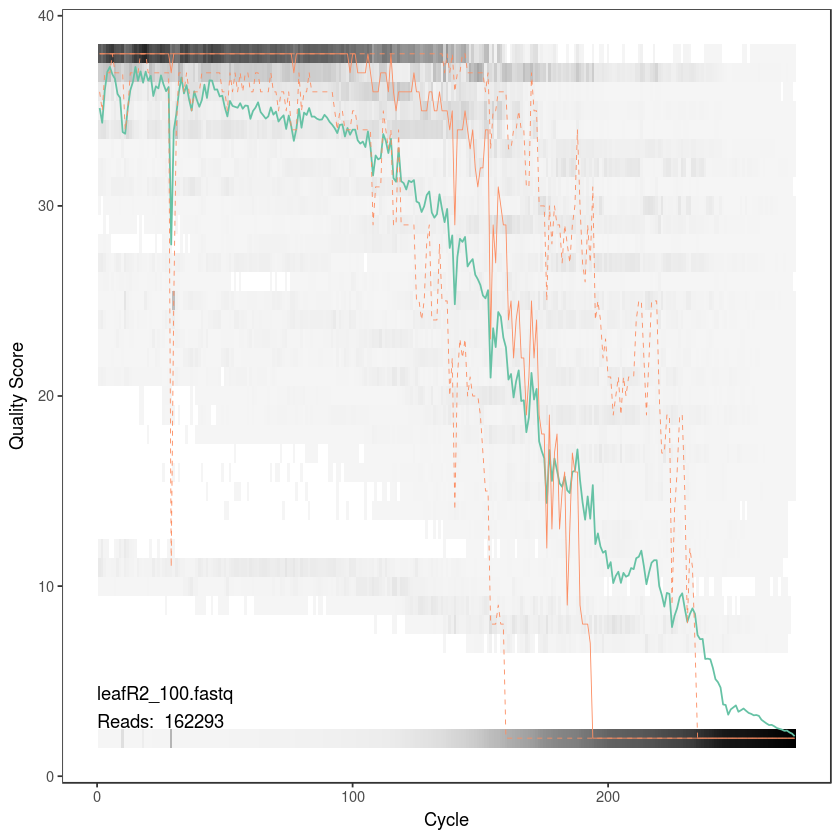

In [57]:
plotQualityProfile(fnFs[1])

Versus reverse reads of the same samples:

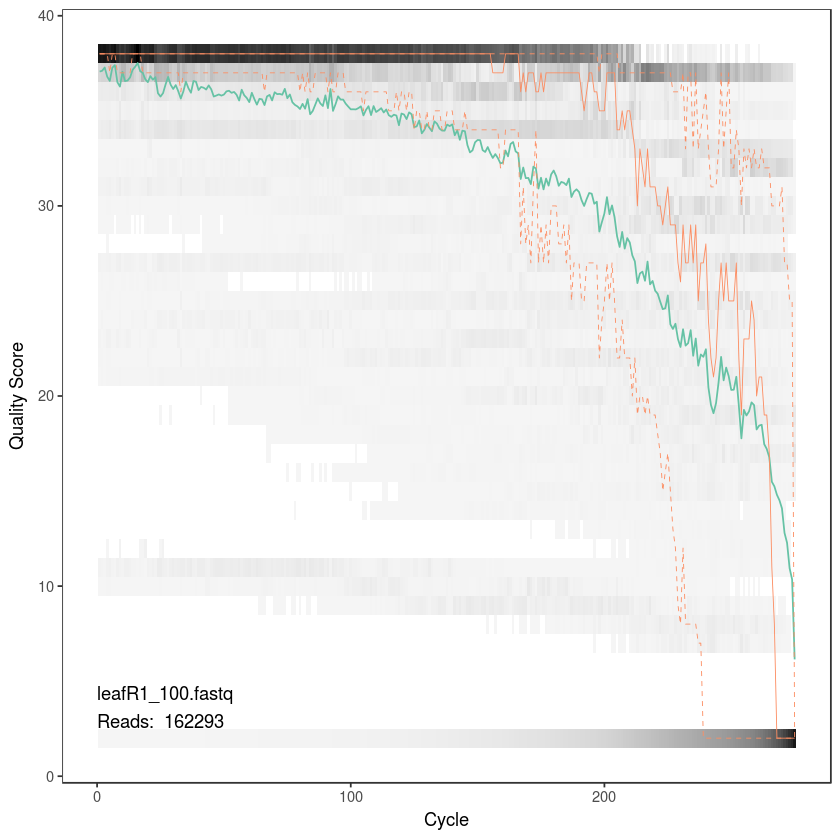

In [58]:
plotQualityProfile(fnRs[1])

The reverse, R1, reads look better. I think this is usually the case with illumina runs. Let's look at a few more of these:

In [60]:
fnFs[seq(10,130,10)]

[1] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_109.fastq"
 [2] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_117.fastq"
 [3] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_128.fastq"
 [4] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_16.fastq" 
 [5] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_25.fastq" 
 [6] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_34.fastq" 
 [7] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_43.fastq" 
 [8] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_52.fastq" 
 [9] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_61.fastq" 
[10] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_70.fastq" 
[11] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_7.fastq"  
[12] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_89.fastq" 
[13] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_98.fastq"

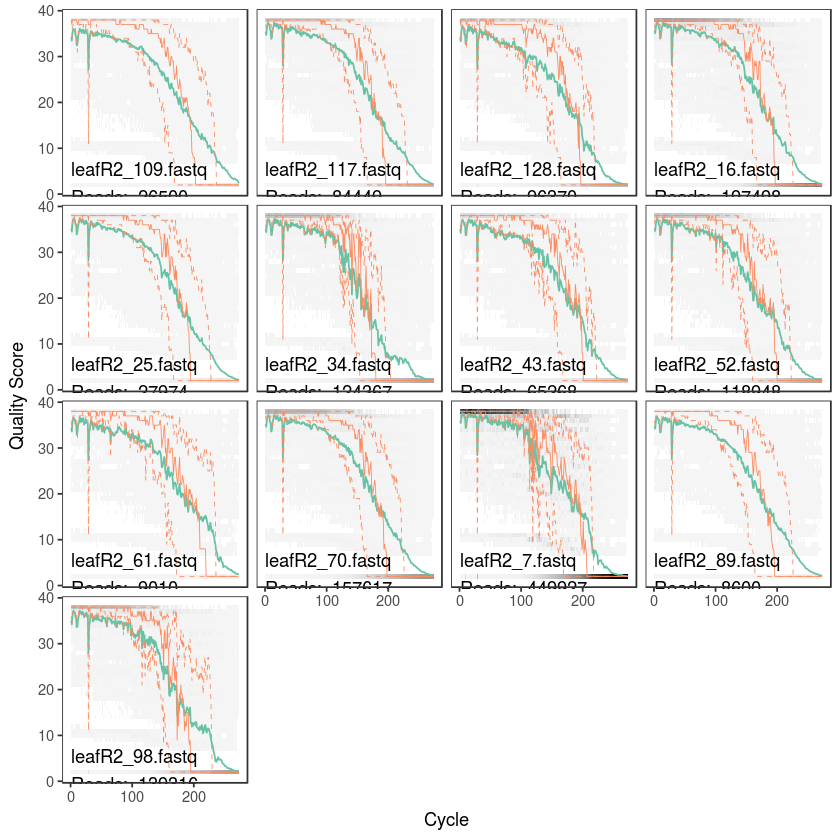

In [59]:
plotQualityProfile(fnFs[seq(10,130,10)]) ## leaf forwards, R2

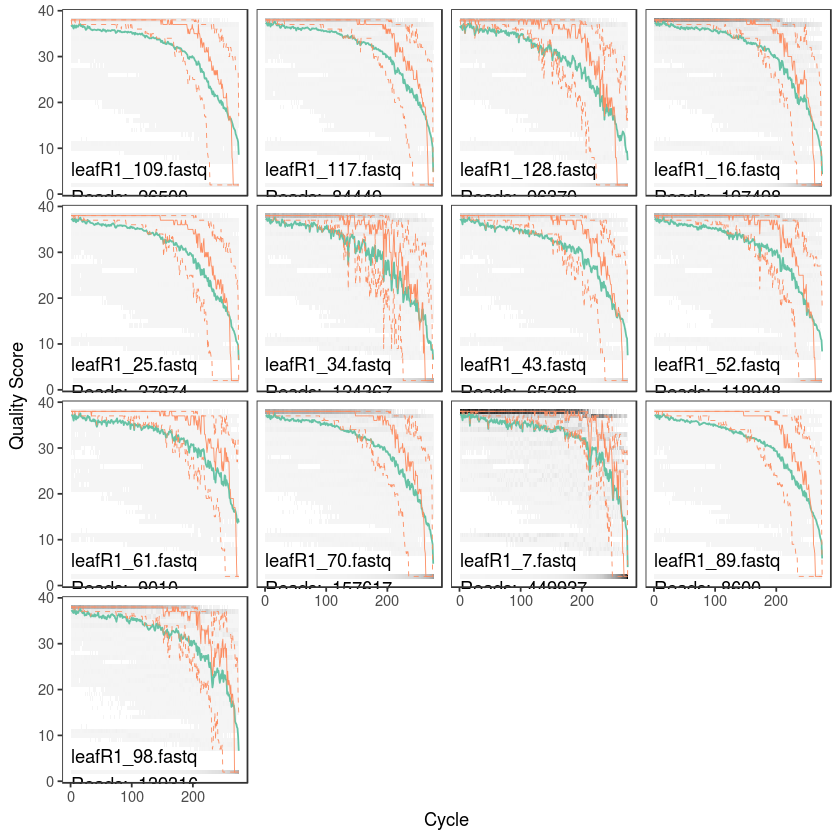

In [62]:
plotQualityProfile(fnRs[seq(10,130,10)]) ## leaf reverse, R1

Roo long ago decided that bp 170 for the forward/R2 reads and bp 263 for the reverse/R1 reads was the place to trim these reads, when considered as an entire library. Bears out pretty well in these charts, even when we break up by sample, but I might take a little more off, as phred scores seem to drop off below 10 a little earlier in some of these samples. DADA2 is somewhat prepared to handle the low qualities, but the tutorial mentions that it may help the error characterization algorithm later if we trim some of the more egregious ends of the reads. 

If memory serves, the entire ITS region usually ranges in fungi from ~400 to ~800 bp. Take out ~150 for the 5.8 subunit, and divide by 2 (ITS1 ~ ITS2?, can't find a good source on this), to get an estimated length of ITS region 1 of 325 bp. Let's hope for a minimum overlap of 20 bp. So let's guess that for most of our reads, we need:

$$forward\,(non-overlapped) + reverse\,(non-overlapped) + 20\,bp\, (overlap) = 325 bp$$

If we keep our lower quality reads (here the forward/R2 library) at a total length, overlapping and non-, of 150 bp, this gives us a minimum of 
$$130\,bp - 20\,bp + (non-overlap\,reverse\,reads) = 325\,bp$$

$$325\,bp - 20\,bp - 130\,bp = 175\,bp \; non-overlapped\,reverse\,reads$$ 

for the higher quality, reverse/R1 read length. Now add back in the 20 bp for the overlap, and we have a mininum of 195 bp for our reverse/R1 reads. Plenty of room to trim. But there is information in even the lower quality BPs (a phred score of 10 still has a 90% chance of being correct). And we actually don't know that our estimate of TIS region 1 is good, it could be longer (we'll see in a minute!). So let's knock down the length of the reverse reads to 220 bp. We can vary this later to try improve merging of reads, if we need to. 

<a id='leafFilterTrim'></a>
<h2>Filter and trim reads</h2>

Given the info above, let's filter and trim. We'll put the resulting reads into a subdirectory, "filtered."

In [6]:
leafPath

[1] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped"

In [11]:
filt_path <- file.path(leafPath, "filtered")
filtFs <- file.path(filt_path, paste0(sample.names, "_F_filt.fastq"))
filtRs <- file.path(filt_path, paste0(sample.names, "_R_filt.fastq"))

In [68]:
fnFs

[1] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_100.fastq" 
  [2] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_101.fastq" 
  [3] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_102.fastq" 
  [4] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_103.fastq" 
  [5] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_104.fastq" 
  [6] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_105.fastq" 
  [7] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_106.fastq" 
  [8] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_107.fastq" 
  [9] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_108.fastq" 
 [10] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_109.fastq" 
 [11] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_110.fastq" 
 [12] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_111.fastq" 
 [13] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_112A.fastq"
 [14] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_112B.fastq"
 [15] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_113A.fastq"
 [16] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_113B.fastq"
 [17] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_114.fastq" 
 [18] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_115.fastq" 
 [19] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_116.fastq" 
 [20] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_117.fastq" 
 [21] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_118.fastq" 
 [22] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_119.fastq" 
 [23] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_120.fastq" 
 [24] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_121.fastq" 
 [25] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_122.fastq" 
 [26] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_125.fastq" 
 [27] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_126A.fastq"
 [28] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_126B.fastq"
 [29] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_127.fastq" 
 [30] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_128.fastq" 
 [31] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_129.fastq" 
 [32] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_12.fastq"  
 [33] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_130.fastq" 
 [34] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_131.fastq" 
 [35] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_132.fastq" 
 [36] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_133.fastq" 
 [37] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_13.fastq"  
 [38] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_14.fastq"  
 [39] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_15.fastq"  
 [40] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_16.fastq"  
 [41] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_17.fastq"  
 [42] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_18.fastq"  
 [43] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/leafR2_19.fastq"  
 [44] "/home/daniel/Documents/taiwan/taiwan_da

In [67]:
filtFs

[1] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/100.fastq_F_filt.fastq" 
  [2] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/101.fastq_F_filt.fastq" 
  [3] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/102.fastq_F_filt.fastq" 
  [4] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/103.fastq_F_filt.fastq" 
  [5] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/104.fastq_F_filt.fastq" 
  [6] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/105.fastq_F_filt.fastq" 
  [7] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/106.fastq_F_filt.fastq" 
  [8] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/107.fastq_F_filt.fastq" 
  [9] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/108.fastq_F_filt.fastq" 
 [10] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/109.fastq_F_filt.fastq" 
 [11] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/110.fastq_F_filt.fastq" 
 [12] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/111.fastq_F_filt.fastq" 
 [13] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/112A.fastq_F_filt.fastq"
 [14] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/112B.fastq_F_filt.fastq"
 [15] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/113A.fastq_F_filt.fastq"
 [16] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/113B.fastq_F_filt.fastq"
 [17] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/114.fastq_F_filt.fastq" 
 [18] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/115.fastq_F_filt.fastq" 
 [19] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/116.fastq_F_filt.fastq" 
 [20] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/117.fastq_F_filt.fastq" 
 [21] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/118.fastq_F_filt.fastq" 
 [22] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/119.fastq_F_filt.fastq" 
 [23] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/120.fastq_F_filt.fastq" 
 [24] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/121.fastq_F_filt.fastq" 
 [25] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/122.fastq_F_filt.fastq" 
 [26] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/125.fastq_F_filt.fastq" 
 [27] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/126A.fastq_F_filt.fastq"
 [28] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/126B.fastq_F_filt.fastq"
 [29] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/127.fastq_F_filt.fastq" 
 [30] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/128.fastq_F_filt.fastq" 
 [31] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/129.fastq_F_filt.fastq" 
 [32] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/12.fastq_F_filt.fastq"  
 [33] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/130.fastq_F_filt.fastq" 
 [34] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/131.fastq_F_filt.fastq" 
 [35] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/132.fastq_F_filt.fastq" 
 [36] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/133.fastq_F_filt.fastq" 
 [37] "/home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/13.fastq_F_filt.fastq"  
 [38] "/home/daniel/Documents/taiwan/taiwan

In [73]:
out <- filterAndTrim(fnFs, filtFs, fnRs, filtRs, truncLen=c(150,220),
                    maxN=0, maxEE=c(2,2), truncQ=2, rm.phix=TRUE, multithread=FALSE)

In [96]:
#save(out, file='leafFilterAndTrim.rda')

In [75]:
out

,reads.in,reads.out
leafR2_100.fastq,162293,85018
leafR2_101.fastq,172051,91859
leafR2_102.fastq,155374,70855
leafR2_103.fastq,80347,36892
leafR2_104.fastq,110477,54118
leafR2_105.fastq,41854,21578
leafR2_106.fastq,69,4
leafR2_107.fastq,118640,65132
leafR2_108.fastq,41186,20690
leafR2_109.fastq,26500,13001


Hmm. Not certain why only forward reads are given...but let's look at these:

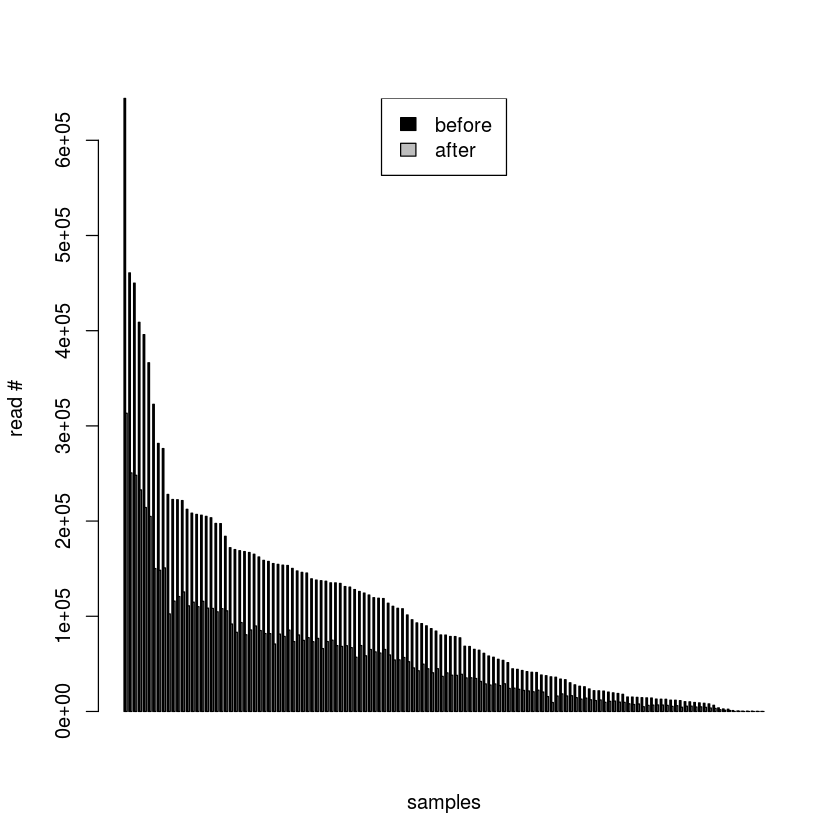

In [107]:
## sort and transpose
tout <- t(out[order(out[,1], decreasing=TRUE),])

barplot(tout, 
    beside=TRUE, 
    col=c("black","gray"), 
    axes=FALSE,
    axisnames=FALSE,
    xlab='samples',
    ylab='read #',
    )
axis(2)
legend(x="top", legend=c('before','after'), fill=c("black","gray"))


<a id='leafFiltLoss'></a>
Plot is crowded, but generally, there is a ~40-50% reduction in read counts after filtering, it looks like. I don't know why we can access the reverse reads this way, but something similar is probably happening, I assume. 

<a id='leafLearnError'></a>
<h2>Learn error rates</h2>

One of the selling points of DADA2 is that it models the errors rates of individual libraries, training an algorithm on errors it detects within a library. Let's see what it says about the leaf reads:

In [12]:
errF <- learnErrors(filtFs, multithread=TRUE)

Initializing error rates to maximum possible estimate.
Sample 1 - 85018 reads in 15492 unique sequences.
Sample 2 - 91859 reads in 20727 unique sequences.
Sample 3 - 70855 reads in 16314 unique sequences.
Sample 4 - 36892 reads in 13260 unique sequences.
Sample 5 - 54118 reads in 15235 unique sequences.
Sample 6 - 21578 reads in 6734 unique sequences.
Sample 7 - 4 reads in 4 unique sequences.
Sample 8 - 65132 reads in 16775 unique sequences.
Sample 9 - 20690 reads in 5582 unique sequences.
Sample 10 - 13001 reads in 6043 unique sequences.
Sample 11 - 62570 reads in 16072 unique sequences.
Sample 12 - 110981 reads in 21383 unique sequences.
Sample 13 - 5 reads in 5 unique sequences.
Sample 14 - 9833 reads in 3502 unique sequences.
Sample 15 - 75 reads in 52 unique sequences.
Sample 16 - 12 reads in 10 unique sequences.
Sample 17 - 40669 reads in 11724 unique sequences.
Sample 18 - 115760 reads in 23225 unique sequences.
Sample 19 - 66094 reads in 18499 unique sequences.
Sample 20 - 4495

In [13]:
errR <- learnErrors(filtRs, multithread=TRUE)

Initializing error rates to maximum possible estimate.
Sample 1 - 85018 reads in 19300 unique sequences.
Sample 2 - 91859 reads in 28656 unique sequences.
Sample 3 - 70855 reads in 18250 unique sequences.
Sample 4 - 36892 reads in 15165 unique sequences.
Sample 5 - 54118 reads in 18034 unique sequences.
Sample 6 - 21578 reads in 7975 unique sequences.
Sample 7 - 4 reads in 4 unique sequences.
Sample 8 - 65132 reads in 21789 unique sequences.
Sample 9 - 20690 reads in 6110 unique sequences.
Sample 10 - 13001 reads in 6719 unique sequences.
Sample 11 - 62570 reads in 18557 unique sequences.
Sample 12 - 110981 reads in 25153 unique sequences.
Sample 13 - 5 reads in 5 unique sequences.
Sample 14 - 9833 reads in 3996 unique sequences.
Sample 15 - 75 reads in 58 unique sequences.
Sample 16 - 12 reads in 11 unique sequences.
Sample 17 - 40669 reads in 13814 unique sequences.
Sample 18 - 115760 reads in 28382 unique sequences.
Sample 19 - 66094 reads in 21043 unique sequences.
Sample 20 - 4495

In [14]:
#save(errF, file="errF.rda")
#save(errR, file="errR.rda")

Okay, what do we do with this? First, look at them.

Warning message:
“Transformation introduced infinite values in continuous y-axis”

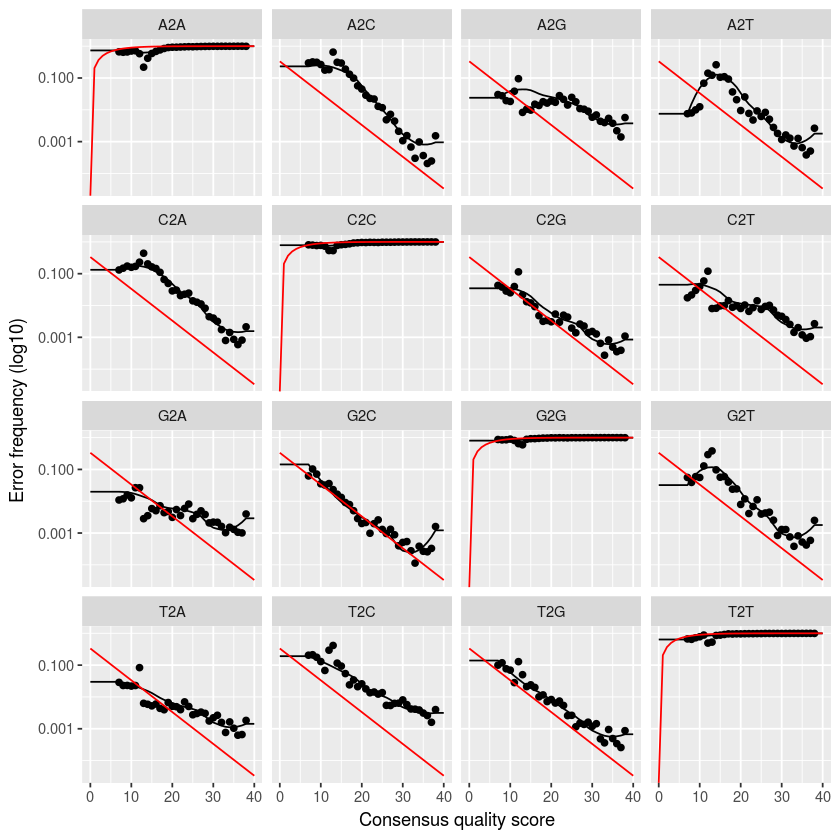

In [110]:
plotErrors(errF, nominalQ=TRUE)

Here's how I understand this... each one of these charts is a transition from one bp to the next in a sequence. The y-axis is the chance out of 1.0 that an error will occur given the phred score on the x-axis. This algorithm has bounced back and forth between the data and predictions generated from a model of error rates from subsets of data, and the final model is represented by the black line. The red line is the predicted frequency of an error from traditional understandings of phred scores for each. Seems like an improvement, but I wonder if we're falling into over-fitting... don't think it makes that much of a difference. Onward. How do the reverse look?:

Warning message:
“Transformation introduced infinite values in continuous y-axis”

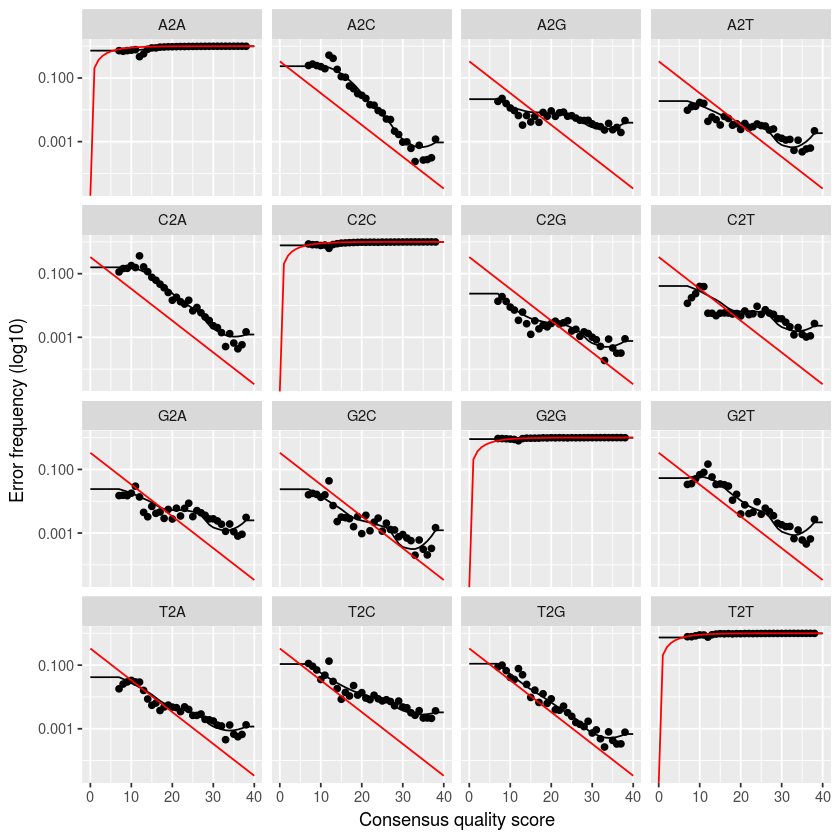

In [111]:
plotErrors(errR, nominalQ=TRUE)

<a id='leafDerep'></a>
<h2>Dereplication</h2>

Just like UPARSE, an important step is dereplication, where we stack reads into piles of identical reads:

In [ ]:
derepFs <- derepFastq(filtFs, verbose=TRUE)

In [ ]:
derepRs <- derepFastq(filtRs, verbose=TRUE)

In [ ]:
derepRs <- derepFastq(filtRs, verbose=TRUE)

Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/100.fastq_F_filt.fastq
Encountered 15492 unique sequences from 85018 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/101.fastq_F_filt.fastq
Encountered 20727 unique sequences from 91859 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/102.fastq_F_filt.fastq
Encountered 16314 unique sequences from 70855 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/103.fastq_F_filt.fastq
Encountered 13260 unique sequences from 36892 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/104.fastq_F_filt.fastq
Encounte

Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/16.fastq_F_filt.fastq
Encountered 20589 unique sequences from 104696 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/17.fastq_F_filt.fastq
Encountered 16847 unique sequences from 69125 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/18.fastq_F_filt.fastq
Encountered 461 unique sequences from 1043 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/19.fastq_F_filt.fastq
Encountered 1822 unique sequences from 5007 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/1.fastq_F_filt.fastq
Encountered 25548 

Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/51.fastq_F_filt.fastq
Encountered 25714 unique sequences from 110088 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/52.fastq_F_filt.fastq
Encountered 11631 unique sequences from 61399 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/53.fastq_F_filt.fastq
Encountered 3791 unique sequences from 16226 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/54.fastq_F_filt.fastq
Encountered 2272 unique sequences from 6411 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/55.fastq_F_filt.fastq
Encountered 169

Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/87.fastq_F_filt.fastq
Encountered 4393 unique sequences from 11493 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/88.fastq_F_filt.fastq
Encountered 4344 unique sequences from 16567 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/89.fastq_F_filt.fastq
Encountered 1748 unique sequences from 4345 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/8.fastq_F_filt.fastq
Encountered 1589 unique sequences from 4428 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/90.fastq_F_filt.fastq
Encountered 17636 un

Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/120.fastq_R_filt.fastq
Encountered 7999 unique sequences from 22364 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/121.fastq_R_filt.fastq
Encountered 11224 unique sequences from 31573 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/122.fastq_R_filt.fastq
Encountered 14972 unique sequences from 40548 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/125.fastq_R_filt.fastq
Encountered 22836 unique sequences from 74709 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/taiwan/taiwan_dada2/reads/dmult_BOLclipped/filtered/126A.fastq_R_filt.fastq
Encounte

This nearly cripples my poor memory. Maybe should try the ["big data"](http://benjjneb.github.io/dada2/bigdata.html) approach next time. I let my desktop chew on these dereplicated read files. They're pretty big, even as R data objects. Let's see if I can manipulate them on my laptop now that the old optiplex has spit them out. Someday I will pay for a computer and it will be nice. 

<a id='leafSampleInference'></a>
<H2>Sample inference</H2>

We'll wait to load the reverse sequences. Seems like it's time to apply the DADA2 magic, and get our "core sequence variants".

In [21]:
load('derepFs.rda')

In [22]:
dadaFs <- dada(derepFs, err=errF, multithread=TRUE)

Sample 1 - 85018 reads in 15492 unique sequences.
Sample 2 - 91859 reads in 20727 unique sequences.
Sample 3 - 70855 reads in 16314 unique sequences.
Sample 4 - 36892 reads in 13260 unique sequences.
Sample 5 - 54118 reads in 15235 unique sequences.
Sample 6 - 21578 reads in 6734 unique sequences.
Sample 7 - 4 reads in 4 unique sequences.
Sample 8 - 65132 reads in 16775 unique sequences.
Sample 9 - 20690 reads in 5582 unique sequences.
Sample 10 - 13001 reads in 6043 unique sequences.
Sample 11 - 62570 reads in 16072 unique sequences.
Sample 12 - 110981 reads in 21383 unique sequences.
Sample 13 - 5 reads in 5 unique sequences.
Sample 14 - 9833 reads in 3502 unique sequences.
Sample 15 - 75 reads in 52 unique sequences.
Sample 16 - 12 reads in 10 unique sequences.
Sample 17 - 40669 reads in 11724 unique sequences.
Sample 18 - 115760 reads in 23225 unique sequences.
Sample 19 - 66094 reads in 18499 unique sequences.
Sample 20 - 44957 reads in 13582 unique sequences.
Sample 21 - 76742 re

In [27]:
dadaRs <- dada(derepRs, err=errR, multithread=TRUE)

Sample 1 - 85018 reads in 19300 unique sequences.
Sample 2 - 91859 reads in 28656 unique sequences.
Sample 3 - 70855 reads in 18250 unique sequences.
Sample 4 - 36892 reads in 15165 unique sequences.
Sample 5 - 54118 reads in 18034 unique sequences.
Sample 6 - 21578 reads in 7975 unique sequences.
Sample 7 - 4 reads in 4 unique sequences.
Sample 8 - 65132 reads in 21789 unique sequences.
Sample 9 - 20690 reads in 6110 unique sequences.
Sample 10 - 13001 reads in 6719 unique sequences.
Sample 11 - 62570 reads in 18557 unique sequences.
Sample 12 - 110981 reads in 25153 unique sequences.
Sample 13 - 5 reads in 5 unique sequences.
Sample 14 - 9833 reads in 3996 unique sequences.
Sample 15 - 75 reads in 58 unique sequences.
Sample 16 - 12 reads in 11 unique sequences.
Sample 17 - 40669 reads in 13814 unique sequences.
Sample 18 - 115760 reads in 28382 unique sequences.
Sample 19 - 66094 reads in 21043 unique sequences.
Sample 20 - 44957 reads in 15907 unique sequences.
Sample 21 - 76742 re

In [28]:
dadaFs[[1]]

dada-class: object describing DADA2 denoising results
129 sample sequences were inferred from 15492 input unique sequences.
Key parameters: OMEGA_A = 1e-40, BAND_SIZE = 16, USE_QUALS = TRUE

In [29]:
#save(dadaFs, file='dadaFs.rda')
#save(dadaRs, file='dadaRs.rda')

In [6]:
load('dadaFs.rda')
load('dadaRs.rda')

<a id='leafMerge'></a>
<h3>Merging paired ends</h3>

Put 'em together. Did this remotely, looked like this:

`mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose=TRUE)`

84907 paired-reads (in 126 unique pairings) successfully merged out of 85018 (in 173 pairings) input.  
91366 paired-reads (in 195 unique pairings) successfully merged out of 91859 (in 282 pairings) input.  
70300 paired-reads (in 243 unique pairings) successfully merged out of 70855 (in 371 pairings) input.  
36209 paired-reads (in 290 unique pairings) successfully merged out of 36892 (in 364 pairings) input.  
53454 paired-reads (in 279 unique pairings) successfully merged out of 54118 (in 404 pairings) input.  
21283 paired-reads (in 133 unique pairings) successfully merged out of 21578 (in 158 pairings) input.  
0 paired-reads (in 0 unique pairings) successfully merged out of 4 (in 1 pairings) input.  
64416 paired-reads (in 58 unique pairings) successfully merged out of 65132 (in 84 pairings) input.  
20532 paired-reads (in 81 unique pairings) successfully merged out of 20690 (in 103 pairings) input.  
10752 paired-reads (in 175 unique pairings) successfully merged out of 13001 (in 441 pairings) input.  
61895 paired-reads (in 208 unique pairings) successfully merged out of 62570 (in 306 pairings) input.  
110211 paired-reads (in 204 unique pairings) successfully merged out of 110981 (in 307 pairings) input.  
5 paired-reads (in 1 unique pairings) successfully merged out of 5 (in 1 pairings) input.  
9598 paired-reads (in 73 unique pairings) successfully merged out of 9833 (in 86 pairings) input.  
55 paired-reads (in 5 unique pairings) successfully merged out of 75 (in 12 pairings) input.  
12 paired-reads (in 1 unique pairings) successfully merged out of 12 (in 1 pairings) input.  
39894 paired-reads (in 89 unique pairings) successfully merged out of 40669 (in 153 pairings) input.  
114826 paired-reads (in 77 unique pairings) successfully merged out of 115760 (in 148 pairings) input.  
65195 paired-reads (in 270 unique pairings) successfully merged out of 66094 (in 414 pairings) input.  
44150 paired-reads (in 284 unique pairings) successfully merged out of 44957 (in 349 pairings) input.  
75977 paired-reads (in 166 unique pairings) successfully merged out of 76742 (in 214 pairings) input.  
51569 paired-reads (in 237 unique pairings) successfully merged out of 52255 (in 285 pairings) input.  
22007 paired-reads (in 141 unique pairings) successfully merged out of 22364 (in 178 pairings) input.  
31143 paired-reads (in 210 unique pairings) successfully merged out of 31573 (in 278 pairings) input.  
39773 paired-reads (in 228 unique pairings) successfully merged out of 40548 (in 303 pairings) input.  
73470 paired-reads (in 257 unique pairings) successfully merged out of 74709 (in 365 pairings) input.  
42500 paired-reads (in 110 unique pairings) successfully merged out of 42784 (in 145 pairings) input.  
8 paired-reads (in 1 unique pairings) successfully merged out of 8 (in 1 pairings) input.  
77226 paired-reads (in 180 unique pairings) successfully merged out of 77550 (in 249 pairings) input.  
44937 paired-reads (in 215 unique pairings) successfully merged out of 45752 (in 329 pairings) input.  
27336 paired-reads (in 284 unique pairings) successfully merged out of 28932 (in 614 pairings) input.  
11963 paired-reads (in 66 unique pairings) successfully merged out of 12097 (in 75 pairings) input.  
44366 paired-reads (in 266 unique pairings) successfully merged out of 44839 (in 373 pairings) input.  
72990 paired-reads (in 231 unique pairings) successfully merged out of 73439 (in 270 pairings) input.  
80942 paired-reads (in 118 unique pairings) successfully merged out of 81849 (in 177 pairings) input.  
6584 paired-reads (in 100 unique pairings) successfully merged out of 6746 (in 139 pairings) input.  
212852 paired-reads (in 46 unique pairings) successfully merged out of 214246 (in 72 pairings) input.  
34925 paired-reads (in 196 unique pairings) successfully merged out of 35406 (in 275 pairings) input.  
115440 paired-reads (in 147 unique pairings) successfully merged out of 115947 (in 200 pairings) input.  
104594 paired-reads (in 115 unique pairings) successfully merged out of 104696 (in 159 pairings) input.  
67961 paired-reads (in 129 unique pairings) successfully merged out of 69125 (in 204 pairings) input.  
994 paired-reads (in 46 unique pairings) successfully merged out of 1043 (in 67 pairings) input.  
4886 paired-reads (in 57 unique pairings) successfully merged out of 5007 (in 70 pairings) input.  
149605 paired-reads (in 55 unique pairings) successfully merged out of 150796 (in 103 pairings) input.  
310742 paired-reads (in 155 unique pairings) successfully merged out of 313267 (in 644 pairings) input.  
106866 paired-reads (in 72 unique pairings) successfully merged out of 108274 (in 94 pairings) input.  
13495 paired-reads (in 164 unique pairings) successfully merged out of 14026 (in 217 pairings) input.  
57982 paired-reads (in 229 unique pairings) successfully merged out of 59395 (in 297 pairings) input.  
78445 paired-reads (in 101 unique pairings) successfully merged out of 78827 (in 134 pairings) input.  
14318 paired-reads (in 157 unique pairings) successfully merged out of 14527 (in 186 pairings) input.  
105133 paired-reads (in 109 unique pairings) successfully merged out of 105735 (in 135 pairings) input.  
250096 paired-reads (in 162 unique pairings) successfully merged out of 250632 (in 202 pairings) input.  
5375 paired-reads (in 68 unique pairings) successfully merged out of 5612 (in 74 pairings) input.  
84259 paired-reads (in 57 unique pairings) successfully merged out of 85464 (in 68 pairings) input.  
5239 paired-reads (in 68 unique pairings) successfully merged out of 5336 (in 97 pairings) input.  
66770 paired-reads (in 114 unique pairings) successfully merged out of 68299 (in 159 pairings) input.  
5757 paired-reads (in 88 unique pairings) successfully merged out of 6095 (in 101 pairings) input.  
106905 paired-reads (in 118 unique pairings) successfully merged out of 107993 (in 171 pairings) input.  
23072 paired-reads (in 126 unique pairings) successfully merged out of 23277 (in 154 pairings) input.  
58274 paired-reads (in 93 unique pairings) successfully merged out of 58493 (in 112 pairings) input.  
7709 paired-reads (in 111 unique pairings) successfully merged out of 7902 (in 135 pairings) input.  
35251 paired-reads (in 27 unique pairings) successfully merged out of 35265 (in 33 pairings) input.  
64824 paired-reads (in 60 unique pairings) successfully merged out of 65132 (in 74 pairings) input.  
56703 paired-reads (in 71 unique pairings) successfully merged out of 56986 (in 83 pairings) input.  
7864 paired-reads (in 88 unique pairings) successfully merged out of 8091 (in 118 pairings) input.  
5313 paired-reads (in 80 unique pairings) successfully merged out of 5578 (in 117 pairings) input.  
147794 paired-reads (in 183 unique pairings) successfully merged out of 148294 (in 227 pairings) input.  
27563 paired-reads (in 97 unique pairings) successfully merged out of 27780 (in 121 pairings) input.  
79755 paired-reads (in 55 unique pairings) successfully merged out of 80383 (in 96 pairings) input.  
34466 paired-reads (in 80 unique pairings) successfully merged out of 34661 (in 111 pairings) input.  
24178 paired-reads (in 54 unique pairings) successfully merged out of 24205 (in 63 pairings) input.  
73762 paired-reads (in 170 unique pairings) successfully merged out of 74873 (in 262 pairings) input.  
9361 paired-reads (in 101 unique pairings) successfully merged out of 9559 (in 127 pairings) input.  
12046 paired-reads (in 117 unique pairings) successfully merged out of 12272 (in 160 pairings) input.  
21848 paired-reads (in 50 unique pairings) successfully merged out of 22116 (in 77 pairings) input.  
28742 paired-reads (in 89 unique pairings) successfully merged out of 29099 (in 124 pairings) input.  
72322 paired-reads (in 120 unique pairings) successfully merged out of 73460 (in 143 pairings) input.  
49363 paired-reads (in 88 unique pairings) successfully merged out of 54229 (in 197 pairings) input.  
105122 paired-reads (in 285 unique pairings) successfully merged out of 110088 (in 445 pairings) input.  
61330 paired-reads (in 61 unique pairings) successfully merged out of 61399 (in 66 pairings) input.  
16127 paired-reads (in 56 unique pairings) successfully merged out of 16226 (in 63 pairings) input.  
6042 paired-reads (in 89 unique pairings) successfully merged out of 6411 (in 119 pairings) input.  
82404 paired-reads (in 107 unique pairings) successfully merged out of 83197 (in 148 pairings) input.  
10529 paired-reads (in 115 unique pairings) successfully merged out of 10922 (in 147 pairings) input.  
9230 paired-reads (in 88 unique pairings) successfully merged out of 9408 (in 122 pairings) input.  
20350 paired-reads (in 52 unique pairings) successfully merged out of 20438 (in 64 pairings) input.  
231771 paired-reads (in 119 unique pairings) successfully merged out of 232758 (in 274 pairings) input.  
4497 paired-reads (in 45 unique pairings) successfully merged out of 4702 (in 62 pairings) input.  
16252 paired-reads (in 64 unique pairings) successfully merged out of 16312 (in 70 pairings) input.  
4770 paired-reads (in 75 unique pairings) successfully merged out of 4861 (in 109 pairings) input.  
89527 paired-reads (in 75 unique pairings) successfully merged out of 89804 (in 103 pairings) input.  
124999 paired-reads (in 129 unique pairings) successfully merged out of 125555 (in 177 pairings) input.  
108191 paired-reads (in 91 unique pairings) successfully merged out of 108532 (in 132 pairings) input.  
49158 paired-reads (in 67 unique pairings) successfully merged out of 49723 (in 106 pairings) input.  
68451 paired-reads (in 58 unique pairings) successfully merged out of 69178 (in 85 pairings) input.  
1804 paired-reads (in 41 unique pairings) successfully merged out of 1855 (in 47 pairings) input.  
38637 paired-reads (in 116 unique pairings) successfully merged out of 39084 (in 135 pairings) input.  
66816 paired-reads (in 156 unique pairings) successfully merged out of 67060 (in 222 pairings) input.  
6257 paired-reads (in 48 unique pairings) successfully merged out of 6403 (in 71 pairings) input.  
80843 paired-reads (in 185 unique pairings) successfully merged out of 81741 (in 480 pairings) input.  
92842 paired-reads (in 93 unique pairings) successfully merged out of 93400 (in 125 pairings) input.  
15525 paired-reads (in 109 unique pairings) successfully merged out of 15641 (in 136 pairings) input.  
18251 paired-reads (in 23 unique pairings) successfully merged out of 18499 (in 38 pairings) input.  
162 paired-reads (in 16 unique pairings) successfully merged out of 220 (in 31 pairings) input.  
100969 paired-reads (in 126 unique pairings) successfully merged out of 102476 (in 164 pairings) input.  
6778 paired-reads (in 52 unique pairings) successfully merged out of 6872 (in 61 pairings) input.  
37615 paired-reads (in 56 unique pairings) successfully merged out of 37908 (in 72 pairings) input.  
202959 paired-reads (in 84 unique pairings) successfully merged out of 204890 (in 141 pairings) input.  
6436 paired-reads (in 63 unique pairings) successfully merged out of 6686 (in 118 pairings) input.  
247503 paired-reads (in 43 unique pairings) successfully merged out of 248099 (in 84 pairings) input.  
3577 paired-reads (in 85 unique pairings) successfully merged out of 3638 (in 108 pairings) input.  
111636 paired-reads (in 86 unique pairings) successfully merged out of 114832 (in 128 pairings) input.  
10473 paired-reads (in 67 unique pairings) successfully merged out of 10606 (in 98 pairings) input.  
23621 paired-reads (in 189 unique pairings) successfully merged out of 24511 (in 351 pairings) input.  
6802 paired-reads (in 64 unique pairings) successfully merged out of 7339 (in 78 pairings) input.  
80497 paired-reads (in 66 unique pairings) successfully merged out of 80571 (in 89 pairings) input.  
1297 paired-reads (in 19 unique pairings) successfully merged out of 1298 (in 20 pairings) input.  
11067 paired-reads (in 151 unique pairings) successfully merged out of 11493 (in 272 pairings) input.  
16535 paired-reads (in 51 unique pairings) successfully merged out of 16567 (in 60 pairings) input.  
4149 paired-reads (in 86 unique pairings) successfully merged out of 4345 (in 104 pairings) input.  
4303 paired-reads (in 83 unique pairings) successfully merged out of 4428 (in 106 pairings) input.  
80252 paired-reads (in 202 unique pairings) successfully merged out of 81300 (in 274 pairings) input.  
5 paired-reads (in 1 unique pairings) successfully merged out of 5 (in 1 pairings) input.  
149318 paired-reads (in 162 unique pairings) successfully merged out of 150108 (in 209 pairings) input.  
84765 paired-reads (in 131 unique pairings) successfully merged out of 85637 (in 173 pairings) input.  
55773 paired-reads (in 280 unique pairings) successfully merged out of 56665 (in 349 pairings) input.  
26607 paired-reads (in 199 unique pairings) successfully merged out of 27217 (in 251 pairings) input.  
120490 paired-reads (in 123 unique pairings) successfully merged out of 120718 (in 165 pairings) input.  
36825 paired-reads (in 325 unique pairings) successfully merged out of 38068 (in 536 pairings) input.  
72855 paired-reads (in 226 unique pairings) successfully merged out of 73263 (in 312 pairings) input.  
28549 paired-reads (in 184 unique pairings) successfully merged out of 28987 (in 270 pairings) input.  
9518 paired-reads (in 41 unique pairings) successfully merged out of 9644 (in 65 pairings) input.  
3080 paired-reads (in 55 unique pairings) successfully merged out of 3230 (in 63 pairings) input.  
68811 paired-reads (in 42 unique pairings) successfully merged out of 69247 (in 69 pairings) input.  


In [11]:
load('mergers.rda')

In [13]:
class(mergers[[1]])

[1] "data.frame"

In [14]:
head(mergers[[1]][,-1])

abundance,forward,reverse,nmatch,nmismatch,nindel,prefer,accept
49981,1,1,113,0,0,1,TRUE
15730,2,2,77,0,0,1,TRUE
3953,3,3,55,0,0,1,TRUE
2980,4,4,64,0,0,1,TRUE
2183,5,5,86,0,0,1,TRUE
2012,6,6,143,0,0,1,TRUE


In [12]:
mergers[[1]][,-1]

,abundance,forward,reverse,nmatch,nmismatch,nindel,prefer,accept
1,49981,1,1,113,0,0,1,TRUE
2,15730,2,2,77,0,0,1,TRUE
3,3953,3,3,55,0,0,1,TRUE
4,2980,4,4,64,0,0,1,TRUE
5,2183,5,5,86,0,0,1,TRUE
6,2012,6,6,143,0,0,1,TRUE
7,1411,7,7,40,0,0,1,TRUE
8,1270,8,8,123,0,0,1,TRUE
9,847,5,9,86,0,0,1,TRUE
10,363,9,10,137,0,0,1,TRUE


<a id='leafSequenceTable'></a>
<h2>Construct sequence table</h2>

In [6]:
seqtab <- makeSequenceTable(mergers)
save(seqtab, file='seqtab.rda')

The sequences being tabled vary in length.


In [16]:
dim(seqtab)

[1]  134 8064

8,000 OTUs... seems reasonable. 

In [19]:
aa <- table(nchar(getSequences(seqtab)))
aa


 220  221  222  223  224  225  226  227  228  229  230  231  232  233  234  235 
1839   93   96  101   67   93   91   93  118   67  103   98   75   72  121  110 
 236  237  238  239  240  241  242  243  244  245  246  247  248  249  250  251 
 110   81   79   62   77  125   77   67   74   80   61  147   72   65   91  158 
 252  253  254  255  256  257  258  259  260  261  262  263  264  265  266  267 
  87   45   74  100  116   90  112   74   74   92  196   71   60   60   56   63 
 268  269  270  271  272  273  274  275  276  277  278  279  280  281  282  283 
  42   70   76   42   41   43   35   57   44   31   37   12   26   83   24   31 
 284  285  286  287  288  289  290  291  292  293  294  295  296  297  298  299 
  32   23   33   22   17   26   16   15   19   22   39   15   18   24   12   20 
 300  301  302  303  304  305  306  307  308  309  310  311  312  313  314  315 
  17   16   11   32   19   27   35   17   25   19   12   18   19   14   21   21 
 316  317  318  319  320  3

220 bp is our shortest and by far the most numerous read length in the amplicon library (1,839). Makes sense, this was our longer cutoff. Most are far less in abundance:

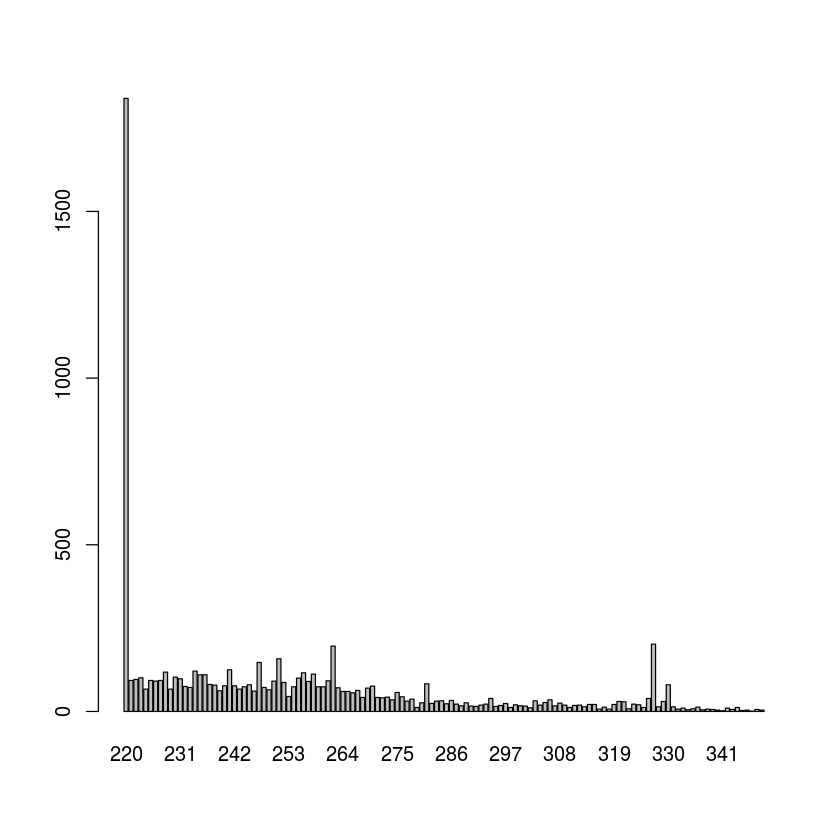

In [20]:
barplot(aa)

Something seems a little fishy about that... not sure why that would be? In general among these sequence variants, the ITSregion1 lengths are a little shorter than I expected... generally less than 300 bp. 

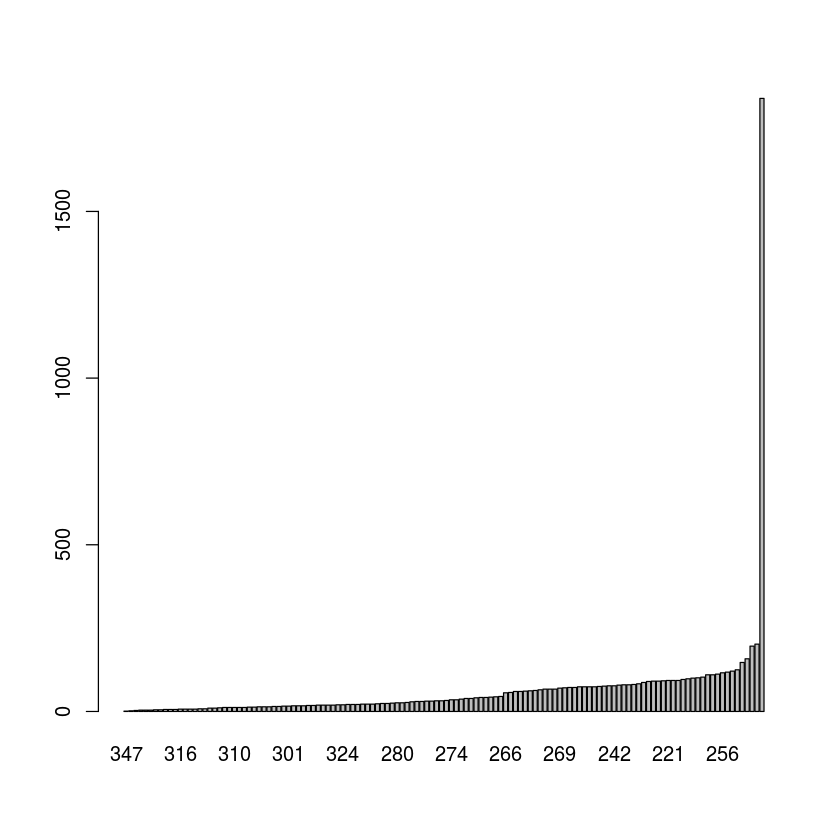

In [22]:
barplot(sort(aa))

<a id='leafChimeras'></a>
<h3>Remove Chimeras</h3>

In [8]:
seqtab.nochim <- removeBimeraDenovo(seqtab, method="consensus", multithread=TRUE, verbose=TRUE)
dim(seqtab.nochim)

Identified 287 bimeras out of 8064 input sequences.


[1]  134 7777

In [10]:
#save(seqtab.nochim, file='seqtab.nochim.rda')

In [11]:
sum(seqtab.nochim)/sum(seqtab); 287/8064

[1] 0.9949347

[1] 0.03559028

So 3.5% of our sequence variants are from chimeric sequence, but less than 1% of read abundances come from these chimeras.

In [2]:
load('dadaFs.rda')
load('leafFilterAndTrim.rda')
load('sample.names.rda')
load('mergers.rda')
load('seqtab.nochim.rda')

In [13]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(mergers, getN), rowSums(seqtab), rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoised", "merged", "tabled", "nonchim")
rownames(track) <- sample.names

In [14]:
track

,input,filtered,denoised,merged,tabled,nonchim
100.fastq,162293,85018,85018,84907,84907,84760
101.fastq,172051,91859,91859,91366,91366,91366
102.fastq,155374,70855,70855,70300,70300,70241
103.fastq,80347,36892,36892,36209,36209,34139
104.fastq,110477,54118,54118,53454,53454,53052
105.fastq,41854,21578,21578,21283,21283,21154
106.fastq,69,4,4,0,0,0
107.fastq,118640,65132,65132,64416,64416,64416
108.fastq,41186,20690,20690,20532,20532,20532
109.fastq,26500,13001,13001,10752,10752,10752


Huh. Filtering really took a hit on our reads. Otherwise, numbers are pretty stable across the steps. 

<a id='leafTax'></a>
<h2>Assign taxonomy</h2> 

We've downloaded the [UNITE data base](https://unite.ut.ee/repository.php), put it in our working directory.

What I think I understand: UNITE provides two versions of it's database. One, with ~58,000 sequences, I think has all sequences that have been successfully submitted to the database. Then there is a smaller fasta file with~ ~31,000 sequences, which has been trimmed to clustered Species hypothesis, some 9000 of which have been vetted by experts in a taxonomic group (also in the larger. Singletons that are clustered to a SH elsewhereare discarded, I think. so which do we use? Let's stay with the more curated version...

In [17]:
UNITE <- '/home/daniel/Documents/taiwan/UNITE/sh_general_release_dynamic_01.12.2017.fasta'

In [ ]:
taxa <- assignTaxonomy(seqtab.nochim, UNITE, multithread=TRUE)

I acutally farmed this out to the desktop, it crippled my laptop. On my old beast (dual core optiplex with 12 G RAM), this took ~2.5 hours. Checking out R for a minute, we can look at the output from the batch file:

In [4]:
cat leaftaxation.Rout


R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(dada2)
Loading required package: Rcpp
> 
> load('dadaFs.rda')
> load('leafFilterAndTrim.rda')
> load('sample.names.rda')
> load('mergers.rda')
> load('seqtab.nochim.rda')
> 
> taxa <- assignTaxonomy(seqtab.nochim, "sh_general_release_dynamic_01.12.2017.fasta" , multithread=TRUE)
UNITE fungal tax

Back into R kernel...

In [2]:
load('taxa.rda')

These taxonomic assignments are matrices. At any taxonomic level they fail the boot strap values, they are not assigned. I used the default, 50, which seems low, but even at this level most OTUs are not identified to species:

In [3]:
head(taxa)

,Kingdom,Phylum,Class,Order,Family,Genus,Species
AAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTAGAGAGAAGGTGGCCCCCCCTCGCAGGGGGGCAGACCTCCCGCTACCTGCCTACCACACACCTGTTGCCTCGCCGGGCCCCGCGCCCGGCGCAGGACCTTGAACCCTAACGTTAATGCGGTCAGAGCACATTGCGAACAGCAAAAACTTTCAACAACGGATCTCTTGGCTCTG,k__Fungi,p__Ascomycota,NA,NA,NA,NA,NA
AAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTGCTTGACCCCAGCGTAAGCTGGGGAATTGCATCACACAAATTGACCTATCCTTTGTTTGCCTCGGTGGGCGGCTCAGCTGAGCCCCTGGACCCGAAAGGGCGCTCACCGTTGGACCAGTCTTGTTTGAATCTGTACTCAGTAAAAGAAAGTCACAACTTTCAACAATGGATCTCTTGGCTCTG,k__Fungi,p__Ascomycota,NA,NA,NA,NA,NA
AAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTGCAAAACTCCCACAACCATCGTGAACCCACCTACCGTTGCCTCGGCGGGCGGCAGGCATACCCTCACCAGGGTCTGCTACGCCGTCTGTCCCCCTGCCCCCCGGGGCTCGGGGGCGCCCGCCGGAGGACACCTAAACTACGTCTCCAGTGCATCTCAGAGTAACGTATCAAATACATCAAAACTTTCAACAATGGATCTCTTGGTTCTG,k__Fungi,p__Ascomycota,c__Sordariomycetes,NA,NA,NA,NA
AAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACTGAGTGAGGGCTCACGCCCGACCTCCAACCCTTTGTGAACACATCTTGTTGCTTCGGGGGCGACCCTGCCGGCACTTCGTCGCCGGGCGCCCCCGAAGGTCTCCAAACACTGCATCTTTGCGTCGGAGTTTAAACAAATTAAACAAAACTTTCAACAACGGATCTCTTGGTTCTG,k__Fungi,p__Ascomycota,c__Dothideomycetes,o__Capnodiales,f__Mycosphaerellaceae,g__Pseudocercospora,s__lyoniae
AAGTCGTAACAAGGTTTCCGTTGGTGAACCAGCGGAAGGATCATTACCGAGATCGGGCCCTCCGGGGCCGACCTCCCACCCTGTGTTACCACCCGTGTTGCTTTGGCGGGATCGGCCCCTCCCGAGGCCGCCCGGCGTCCCCCGGACGCGCCCGCCGGAGGCCCCCTCAACCCGGCCTGTGCGTGTGTCGTCTGAGCGTCAACATAACAAGTCAAAACTTTCAACAACGGATCTCTTGGCTCTG,k__Fungi,p__Ascomycota,NA,NA,NA,NA,NA
GGAAGTAAAAGTCGTAACAAGGTCTCCGTAGGTGAACCTGCGGAGGGATCATTACCGAGTGAGGGCTCACGCCCGACCTCCAACCCTGTGTGAACGCAAATCTCGTTGCTTCGGGGGCGACCCTGCCGTGGCGCCCCCGGAGGTCATCTCAACTCTGCATCTCTGCGTCGGAGTCAAAGTTAATCAAACAAAACTTTCAACAACGGATCTCTTGGTTCTG,k__Fungi,p__Ascomycota,c__Dothideomycetes,o__Capnodiales,f__Mycosphaerellaceae,NA,NA


In [4]:
bb = is.na(taxa)

colSums(bb)/ nrow(bb)

Kingdom     Phylum      Class      Order     Family      Genus    Species 
0.01928764 0.16433072 0.38601003 0.50186447 0.59881702 0.67866787 0.77574900

So ~77% of ASVs lack a species ID. 16% aren't identified to phylum. That seems like a large amount...

So from here, it looks like dada2 intends that we treat these ASVs in a similar manner as OTUs. I am unclear whether the appropriate way forward is to cluster them anyway? 

<a id='dada2wood'></a>
<h1>DADA2 pipeline for wood reads</h1>

Now let's do the same for the wood reads....

In [10]:
## path to wood reads:
wooddir <- '/home/daniel/Documents/taiwan/woodreads'
list.files(wooddir)

[1] "lane1-s160-index-AAGCACTG-GTGATCCANNNN-Dc-X_S160_L001_R1_001.fastq"   
  [2] "lane1-s160-index-AAGCACTG-GTGATCCANNNN-Dc-X_S160_L001_R2_001.fastq"   
  [3] "lane1-s161-index-AAGCACTG-TTCGTACGNNNN-Dc-PosG_S161_L001_R1_001.fastq"
  [4] "lane1-s161-index-AAGCACTG-TTCGTACGNNNN-Dc-PosG_S161_L001_R2_001.fastq"
  [5] "lane1-s162-index-AAGCACTG-ATGACAGGNNNN-Dc-PosI_S162_L001_R1_001.fastq"
  [6] "lane1-s162-index-AAGCACTG-ATGACAGGNNNN-Dc-PosI_S162_L001_R2_001.fastq"
  [7] "lane1-s163-index-AAGCACTG-CGACCTAANNNN-Dc-Neg_S163_L001_R1_001.fastq" 
  [8] "lane1-s163-index-AAGCACTG-CGACCTAANNNN-Dc-Neg_S163_L001_R2_001.fastq" 
  [9] "lane1-s164-index-CTAGGTGA-GACACAGTNNNN-1w_S164_L001_R1_001.fastq"     
 [10] "lane1-s164-index-CTAGGTGA-GACACAGTNNNN-1w_S164_L001_R2_001.fastq"     
 [11] "lane1-s165-index-ACGACTTG-GACACAGTNNNN-2w_S165_L001_R1_001.fastq"     
 [12] "lane1-s165-index-ACGACTTG-GACACAGTNNNN-2w_S165_L001_R2_001.fastq"     
 [13] "lane1-s166-index-GCATACAG-GACACAGTNNNN-3w_S166_L001_R1_001.fastq"     
 [14] "lane1-s166-index-GCATACAG-GACACAGTNNNN-3w_S166_L001_R2_001.fastq"     
 [15] "lane1-s167-index-TGCGAACT-GACACAGTNNNN-4w_S167_L001_R1_001.fastq"     
 [16] "lane1-s167-index-TGCGAACT-GACACAGTNNNN-4w_S167_L001_R2_001.fastq"     
 [17] "lane1-s168-index-TCTCCGAT-GACACAGTNNNN-5w_S168_L001_R1_001.fastq"     
 [18] "lane1-s168-index-TCTCCGAT-GACACAGTNNNN-5w_S168_L001_R2_001.fastq"     
 [19] "lane1-s169-index-GAGGACTT-GACACAGTNNNN-7w_S169_L001_R1_001.fastq"     
 [20] "lane1-s169-index-GAGGACTT-GACACAGTNNNN-7w_S169_L001_R2_001.fastq"     
 [21] "lane1-s170-index-ACCATCCA-GACACAGTNNNN-9w_S170_L001_R1_001.fastq"     
 [22] "lane1-s170-index-ACCATCCA-GACACAGTNNNN-9w_S170_L001_R2_001.fastq"     
 [23] "lane1-s171-index-CAACACCT-GACACAGTNNNN-10w_S171_L001_R1_001.fastq"    
 [24] "lane1-s171-index-CAACACCT-GACACAGTNNNN-10w_S171_L001_R2_001.fastq"    
 [25] "lane1-s172-index-CTAGGTGA-GCATAACGNNNN-11w_S172_L001_R1_001.fastq"    
 [26] "lane1-s172-index-CTAGGTGA-GCATAACGNNNN-11w_S172_L001_R2_001.fastq"    
 [27] "lane1-s173-index-ACGACTTG-GCATAACGNNNN-13w_S173_L001_R1_001.fastq"    
 [28] "lane1-s173-index-ACGACTTG-GCATAACGNNNN-13w_S173_L001_R2_001.fastq"    
 [29] "lane1-s174-index-GCATACAG-GCATAACGNNNN-14w_S174_L001_R1_001.fastq"    
 [30] "lane1-s174-index-GCATACAG-GCATAACGNNNN-14w_S174_L001_R2_001.fastq"    
 [31] "lane1-s175-index-TGCGAACT-GCATAACGNNNN-15w_S175_L001_R1_001.fastq"    
 [32] "lane1-s175-index-TGCGAACT-GCATAACGNNNN-15w_S175_L001_R2_001.fastq"    
 [33] "lane1-s176-index-TCTCCGAT-GCATAACGNNNN-16w_S176_L001_R1_001.fastq"    
 [34] "lane1-s176-index-TCTCCGAT-GCATAACGNNNN-16w_S176_L001_R2_001.fastq"    
 [35] "lane1-s177-index-GAGGACTT-GCATAACGNNNN-17w_S177_L001_R1_001.fastq"    
 [36] "lane1-s177-index-GAGGACTT-GCATAACGNNNN-17w_S177_L001_R2_001.fastq"    
 [37] "lane1-s178-index-ACCATCCA-GCATAACGNNNN-18w_S178_L001_R1_001.fastq"    
 [38] "lane1-s178-index-ACCATCCA-GCATAACGNNNN-18w_S178_L001_R2_001.fastq"    
 [39] "lane1-s179-index-CAACACCT-GCATAACGNNNN-19w_S179_L001_R1_001.fastq"    
 [40] "lane1-s179-index-CAACACCT-GCATAACGNNNN-19w_S179_L001_R2_001.fastq"    
 [41] "lane1-s180-index-CTAGGTGA-ACAGAGGTNNNN-20w_S180_L001_R1_001.fastq"    
 [42] "lane1-s180-index-CTAGGTGA-ACAGAGGTNNNN-20w_S180_L001_R2_001.fastq"    
 [43] "lane1-s181-index-ACGACTTG-ACAGAGGTNNNN-21w_S181_L001_R1_001.fastq"    
 [44] "lane1-s181-index-ACGACTTG-ACAGAGGTNNNN-21w_S181_L001_R2_001.fastq"    
 [45] "lane1-s182-index-GCATACAG-ACAGAGGTNNNN-23w_S182_L001_R1_001.fastq"    
 [46] "lane1-s182-index-GCATACAG-ACAGAGGTNNNN-23w_S182_L001_R2_001.fastq"    
 [47] "lane1-s183-index-TGCGAACT-ACAGAGGTNNNN-25w_S183_L001_R1_001.fastq"    
 [48] "lane1-s183-index-TGCGAACT-ACAGAGGTNNNN-25w_S183_L001_R2_001.fastq"    
 [49] "lane1-s184-index-TCTCCGAT-ACAGAGGTNNNN-26w_S184_L001_R1_001.fastq"    
 [50] "lane1-s184-index-TCTCCGAT-ACAGAGGTNNNN-26w_S184_L001_R2_001.fastq"    
 [51] "lane1-s185-index-GAGGACTT-ACAGAGGTNNNN-27w_S185_L001_R1_001.fastq"    
 [52] "lane1-s185-index-

Get forward and reverse file names. In this library the forward reads are the R1. 

In [11]:
wood_fnFs <- list.files(wooddir, pattern="_R1_001.fastq", full.names = TRUE)
wood_fnRs <- list.files(wooddir, pattern="_R2_001.fastq", full.names = TRUE)

Dice up our file names to get a list of samples:

In [12]:
get_sampname <- function(stri){
    bb <- strsplit(stri, "NNNN-")[[1]][2]
    cc <- strsplit(bb, "_")[[1]][1]
    return(cc) }


woodSampleNames <- unname(sapply(wood_fnFs, get_sampname))

In [18]:
woodSampleNames

[1] "Dc-X"    "Dc-PosG" "Dc-PosI" "Dc-Neg"  "1w"      "2w"      "3w"     
 [8] "4w"      "5w"      "7w"      "9w"      "10w"     "11w"     "13w"    
[15] "14w"     "15w"     "16w"     "17w"     "18w"     "19w"     "20w"    
[22] "21w"     "23w"     "25w"     "26w"     "27w"     "28w"     "29w"    
[29] "30w"     "31w"     "32w"     "35w"     "36w"     "37w"     "38w"    
[36] "39w"     "42w"     "45w"     "46w"     "49w"     "50w"     "52w"    
[43] "55w"     "56w"     "57w"     "58w"     "59w"     "60w"     "61w"    
[50] "64w"     "66w"     "67w"     "68w"     "69w"     "70w"     "71w"    
[57] "72w"     "73w"     "74w"     "75w"     "76w"     "79w"     "81w"    
[64] "82w"     "84w"     "85w"     "86w"     "87w"     "88w"     "89w"    
[71] "92w"     "93w"     "94w"     "95w"     "96w"     "97w"     "99w"    
[78] "100w"    "101w"    "102w"    "104w"    "106w"    "107w"    "108w"   
[85] "109w"    "114w"    "115w"    "121w"    "124w"    "125w"    "128w"   
[92] "129w"    "130w"    "131w"    "133w"    "Neg"     "PosG"    "PosI"

In [ ]:
save(woodSampleNames, file="woodSampleNames.rda")

<a id='VisualizeWoodQscores'></a>
<h2>Visualizing read qualities</h2>

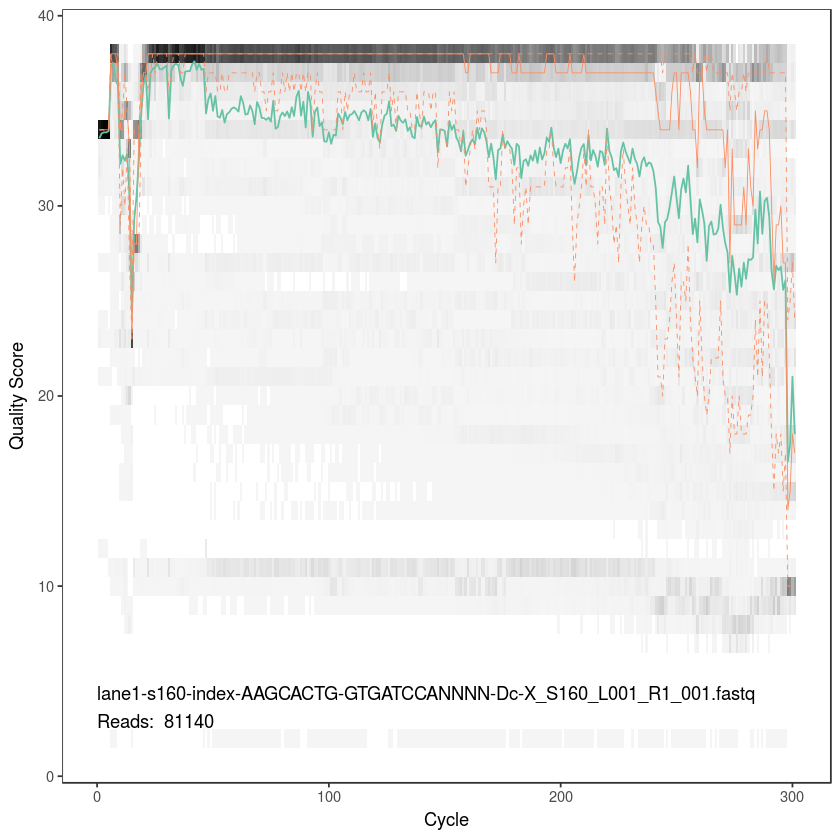

In [15]:
plotQualityProfile(wood_fnFs[1])

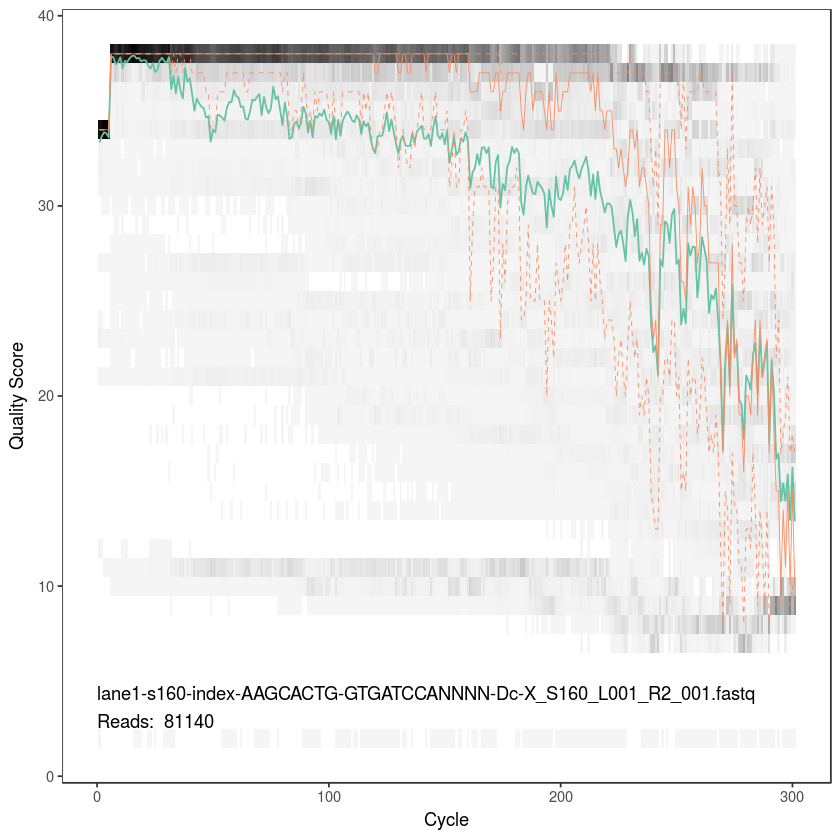

In [16]:
plotQualityProfile(wood_fnRs[1])

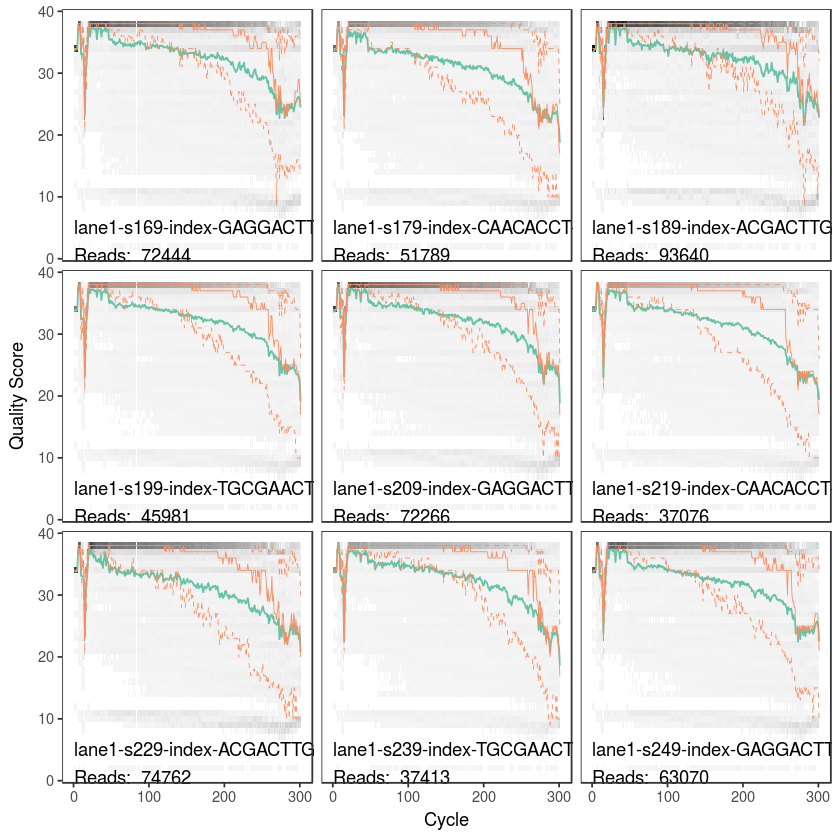

In [20]:
plotQualityProfile(wood_fnFs[seq(10,98,10)])

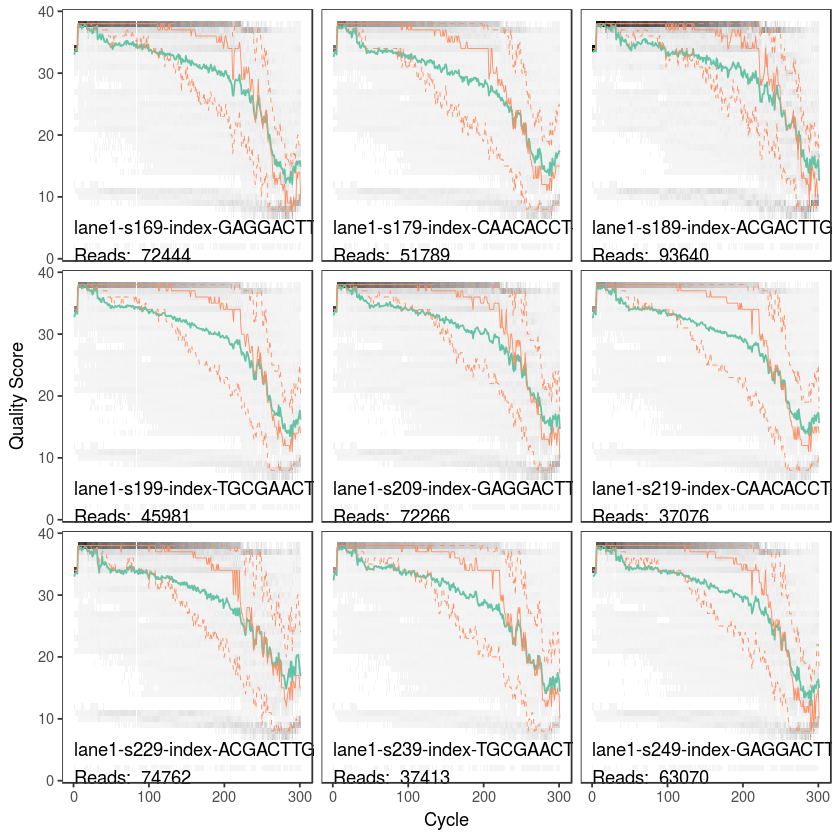

In [21]:
plotQualityProfile(wood_fnRs[seq(10,98,10)])

<a id='woodFilterTrim'></a>
<h2>Filter and trim reads</h2>

In my last pipeline, forward wood reads were clipped at 255, reverse reads were clipped at 210. Let's stay with this and see how they pair up. 

In [14]:
wood_filt_path <- file.path("/home/daniel/Documents/taiwan/taiwan_dada2/woodReadsFiltered")
wood_filtFs <- file.path(wood_filt_path, paste0(woodSampleNames, "_F_filt.fastq"))
wood_filtRs <- file.path(wood_filt_path, paste0(woodSampleNames, "_R_filt.fastq"))

In [ ]:
wood_out <- filterAndTrim(wood_fnFs, wood_filtFs, wood_fnRs, wood_filtRs, truncLen=c(255,210),
                    maxN=0, maxEE=c(2,2), truncQ=2, rm.phix=TRUE, multithread=FALSE)

Farmed this out to the desktop:

In [2]:
## BASH
cat filtwood.Rout


R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library('dada2')
Loading required package: Rcpp
> 
> wooddir <- '/home/daniel/Documents/taiwan_supp/wood_reads/'
> 
> wood_fnFs <- list.files(wooddir, pattern="_R1_001.fastq", full.names = TRUE)
> wood_fnRs <- list.files(wooddir, pattern="_R2_001.fastq", full.names = TRUE)
> 
> wood_filt_path <- file.pa

In [3]:
## back to R
load('wood_out.rda')

In [4]:
ls()

[1] "wood_out"

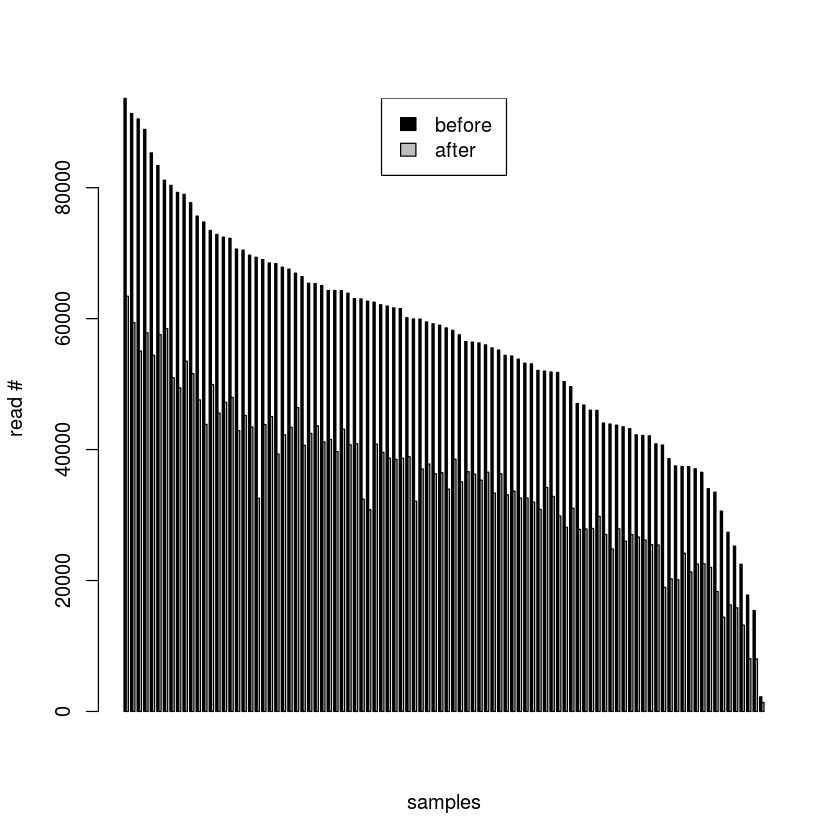

In [6]:
## sort and transpose
tout <- t(wood_out[order(wood_out[,1], decreasing=TRUE),])

barplot(tout, 
    beside=TRUE, 
    col=c("black","gray"), 
    axes=FALSE,
    axisnames=FALSE,
    xlab='samples',
    ylab='read #',
    )
axis(2)
legend(x="top", legend=c('before','after'), fill=c("black","gray"))


Huh. Less dramatic loss than the [leaf samples](#leafFiltLoss) above, though still a lot of reads lost.

<a id='woodLearnError'></a>
<h2>Learn error rates</h2>

In [15]:
wood_errF <- learnErrors(wood_filtFs, multithread=TRUE)

Initializing error rates to maximum possible estimate.
Sample 1 - 58484 reads in 11740 unique sequences.
Sample 2 - 40663 reads in 12221 unique sequences.
Sample 3 - 33645 reads in 11291 unique sequences.
Sample 4 - 14405 reads in 5434 unique sequences.
Sample 5 - 31031 reads in 13356 unique sequences.
Sample 6 - 39580 reads in 15722 unique sequences.
Sample 7 - 24824 reads in 11497 unique sequences.
Sample 8 - 43399 reads in 16063 unique sequences.
Sample 9 - 25496 reads in 12249 unique sequences.
Sample 10 - 47228 reads in 17776 unique sequences.
Sample 11 - 42900 reads in 15505 unique sequences.
Sample 12 - 41538 reads in 13450 unique sequences.
Sample 13 - 33354 reads in 15071 unique sequences.
Sample 14 - 27864 reads in 10779 unique sequences.
Sample 15 - 28129 reads in 13099 unique sequences.
Sample 16 - 27949 reads in 13148 unique sequences.
Sample 17 - 18317 reads in 9067 unique sequences.
Sample 18 - 43443 reads in 18302 unique sequences.
Sample 19 - 45046 reads in 19182 uniqu

In [16]:
wood_errR <- learnErrors(wood_filtRs, multithread=TRUE)

Initializing error rates to maximum possible estimate.
Sample 1 - 58484 reads in 9225 unique sequences.
Sample 2 - 40663 reads in 11140 unique sequences.
Sample 3 - 33645 reads in 10219 unique sequences.
Sample 4 - 14405 reads in 4626 unique sequences.
Sample 5 - 31031 reads in 11976 unique sequences.
Sample 6 - 39580 reads in 13505 unique sequences.
Sample 7 - 24824 reads in 10075 unique sequences.
Sample 8 - 43399 reads in 13374 unique sequences.
Sample 9 - 25496 reads in 10316 unique sequences.
Sample 10 - 47228 reads in 15295 unique sequences.
Sample 11 - 42900 reads in 13629 unique sequences.
Sample 12 - 41538 reads in 11665 unique sequences.
Sample 13 - 33354 reads in 13274 unique sequences.
Sample 14 - 27864 reads in 8782 unique sequences.
Sample 15 - 28129 reads in 11468 unique sequences.
Sample 16 - 27949 reads in 11015 unique sequences.
Sample 17 - 18317 reads in 8170 unique sequences.
Sample 18 - 43443 reads in 15341 unique sequences.
Sample 19 - 45046 reads in 15841 unique 

In [17]:
save(wood_errF, file='wood_errF.rda')
save(wood_errR, file='wood_errR.rda')

<a id='woodDerep'></a>
<h2>Dereplication</h2>

Did this remotely. The outfile:

In [1]:
cat derep_wood.Rout


R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> ## derep_wood.R
> 
> library('dada2')
Loading required package: Rcpp
> 
> load("woodSampleNames.rda")
> 
> wood_filt_path <- file.path("/home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered")
> wood_filtFs <- file.path(wood_filt_path, paste0(woodSampleNames, "_F_filt.fastq"))
> wo

Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/38w_F_filt.fastq
Encountered 14599 unique sequences from 32547 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/39w_F_filt.fastq
Encountered 21449 unique sequences from 47589 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/42w_F_filt.fastq
Encountered 17422 unique sequences from 37791 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/45w_F_filt.fastq
Encountered 10206 unique sequences from 18966 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/46w_F_filt.fastq
Encountered 15339 unique seq

Encountered 3675 unique sequences from 8065 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/96w_F_filt.fastq
Encountered 9131 unique sequences from 20110 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/97w_F_filt.fastq
Encountered 9240 unique sequences from 21307 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/99w_F_filt.fastq
Encountered 10101 unique sequences from 22556 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/100w_F_filt.fastq
Encountered 11114 unique sequences from 27041 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada

Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/15w_R_filt.fastq
Encountered 11015 unique sequences from 27949 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/16w_R_filt.fastq
Encountered 8170 unique sequences from 18317 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/17w_R_filt.fastq
Encountered 15341 unique sequences from 43443 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/18w_R_filt.fastq
Encountered 15841 unique sequences from 45046 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/19w_R_filt.fastq
Encountered 10970 unique sequ

Encountered 11913 unique sequences from 32606 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/71w_R_filt.fastq
Encountered 10532 unique sequences from 38492 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/72w_R_filt.fastq
Encountered 11942 unique sequences from 41180 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/73w_R_filt.fastq
Encountered 13559 unique sequences from 38675 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/74w_R_filt.fastq
Encountered 16679 unique sequences from 55040 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_d

Encountered 9970 unique sequences from 33104 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/Neg_R_filt.fastq
Encountered 636 unique sequences from 1359 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/PosG_R_filt.fastq
Encountered 12057 unique sequences from 54413 total sequences read.
Dereplicating sequence entries in Fastq file: /home/daniel/Documents/submissions/taibioinfo/taiwan_dada2/woodReadsFiltered/PosI_R_filt.fastq
Encountered 10199 unique sequences from 36545 total sequences read.
> 
> save(derepFs, file='derepFs.rda')
> save(derepRs, file='derepRs.rda')
> 
> 
> proc.time()
   user  system elapsed 
300.761   5.671 309.833 


<a id='woodSampleInference'></a>
<H2>Sample inference</H2>

Remote again. Looked like this:

In [ ]:
load('derepFs.rda')
woodDadaFs <- dada(derepFs, err=wood_errF, multithread=TRUE)

In [ ]:
load('derepRs.rda')
woodDadaRs <- dada(derepRs, err=wood_errR, multithread=TRUE)

Output:

In [1]:
cat woodSampleInference.Rout


R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library('dada2')
Loading required package: Rcpp
> 
> load('wood_errF.rda')
> load('wood_errR.rda')
> 
> load('derepFs.rda')
> woodDadaFs <- dada(derepFs, err=wood_errF, multithread=TRUE)
Sample 1 - 58484 reads in 11740 unique sequences.
Sample 2 - 40663 reads in 12221 unique sequences.
Sample 3 - 33645 

Sample 46 - 50977 reads in 16558 unique sequences.
Sample 47 - 37045 reads in 13958 unique sequences.
Sample 48 - 34208 reads in 12848 unique sequences.
Sample 49 - 42472 reads in 15151 unique sequences.
Sample 50 - 47960 reads in 16072 unique sequences.
Sample 51 - 22002 reads in 8121 unique sequences.
Sample 52 - 8021 reads in 2858 unique sequences.
Sample 53 - 38685 reads in 12802 unique sequences.
Sample 54 - 36298 reads in 13373 unique sequences.
Sample 55 - 32606 reads in 11913 unique sequences.
Sample 56 - 38492 reads in 10532 unique sequences.
Sample 57 - 41180 reads in 11942 unique sequences.
Sample 58 - 38675 reads in 13559 unique sequences.
Sample 59 - 55040 reads in 16679 unique sequences.
Sample 60 - 22515 reads in 9494 unique sequences.
Sample 61 - 39700 reads in 12522 unique sequences.
Sample 62 - 45575 reads in 18779 unique sequences.
Sample 63 - 43817 reads in 14443 unique sequences.
Sample 64 - 43630 reads in 12145 unique sequences.
Sample 65 - 53507 reads in 13982 un

<a id='woodMerge'></a>
<h3>Merging paired ends</h3>

Remote...commands were:

In [ ]:
woodMergers <- mergePairs(woodDadaFs, derepFs, woodDadaRs, derepRs, verbose=TRUE)
save(woodMergers, file='woodMergers.rda')

Output was:

In [3]:
## bash
cat woodMerge.Rout


R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> 
> rm(list=ls())
> 
> library('dada2')
Loading required package: Rcpp
> 
> load('woodDadaFs.rda')
> load('derepFs.rda')
> load('woodDadaRs.rda')
> load('derepRs.rda')
> 
> woodMergers <- mergePairs(woodDadaFs, derepFs, woodDadaRs, derepRs, verbose=TRUE)
56913 paired-reads (in 8 unique pairings) successf

22504 paired-reads (in 161 unique pairings) successfully merged out of 32409 (in 200 pairings) input.
7766 paired-reads (in 110 unique pairings) successfully merged out of 8065 (in 136 pairings) input.
18315 paired-reads (in 193 unique pairings) successfully merged out of 20110 (in 249 pairings) input.
20298 paired-reads (in 185 unique pairings) successfully merged out of 21307 (in 225 pairings) input.
21008 paired-reads (in 191 unique pairings) successfully merged out of 22556 (in 239 pairings) input.
21604 paired-reads (in 155 unique pairings) successfully merged out of 27041 (in 195 pairings) input.
29400 paired-reads (in 634 unique pairings) successfully merged out of 32596 (in 891 pairings) input.
22926 paired-reads (in 103 unique pairings) successfully merged out of 24180 (in 143 pairings) input.
31838 paired-reads (in 329 unique pairings) successfully merged out of 35330 (in 425 pairings) input.
15516 paired-reads (in 190 unique pairings) successfully merged out of 16266 (in 229

In [2]:
load('woodMergers.rda')

In [4]:
woodMergers[[1]][,-1]

,abundance,forward,reverse,nmatch,nmismatch,nindel,prefer,accept
1,49336,1,1,209,0,0,2,TRUE
2,6648,2,2,209,0,0,2,TRUE
4,642,4,3,209,0,0,2,TRUE
5,233,5,4,210,0,0,2,TRUE
7,23,6,5,194,0,0,2,TRUE
9,13,8,6,210,0,0,2,TRUE
11,11,10,8,210,0,0,1,TRUE
14,7,7,7,210,0,0,2,TRUE


In [5]:
woodMergers[[2]][,-1]

,abundance,forward,reverse,nmatch,nmismatch,nindel,prefer,accept
1,7764,1,1,210,0,0,2,TRUE
2,5542,2,2,210,0,0,1,TRUE
3,4325,3,3,210,0,0,2,TRUE
4,3238,5,4,172,0,0,2,TRUE
5,3137,4,8,192,0,0,1,TRUE
6,2926,6,5,210,0,0,2,TRUE
7,2504,7,6,209,0,0,2,TRUE
8,2152,8,7,180,0,0,2,TRUE
9,1960,9,9,148,0,0,1,TRUE
10,1787,10,10,210,0,0,1,TRUE


At least in this sample, looks like our reads matched almost entirely in most cases. We trimmed R2/reverse reads to 210 bp, and in this sample, most overlapped that much. 

<a id='woodSequenceTable'></a>
<h2>Construct sequence table</h2>

In [13]:
woodSeqtab <- makeSequenceTable(woodMergers)
save(woodSeqtab, file='woodSeqtab.rda')

The sequences being tabled vary in length.


In [15]:
dim(woodSeqtab)

[1]    98 11541

That's more unique sequences than the leaf reads, as we saw before with the uparse pipeline.

In [16]:
aa <- table(nchar(getSequences(woodSeqtab)))
aa


 255  256  257  258  259  260  261  262  263  264  265  266  267  268  269  270 
6120  160  134  112  120  132   70   94  149  119  109   94  147  114  154  138 
 271  272  273  274  275  276  277  278  279  280  281  282  283  284  285  286 
 106  114   84   85   86   91   83  118   68   94   65   84   61   76   81   62 
 287  288  289  290  291  292  293  294  295  296  297  298  299  300  301  302 
  63   53   39   43   76   60   52   66   44   50   53   40   33   27   20   20 
 303  304  305  306  307  308  309  310  311  312  313  314  315  316  317  318 
  34   34   27   38   28   57   42   24   32   24   26   26   26   16   20   19 
 319  320  321  322  323  324  325  326  327  328  329  330  331  332  333  334 
  31   42   32   21   27   34   24   29   74   21   40   35   23   27   20   14 
 335  336  337  338  339  340  341  342  343  344  345  346  347  348  349  350 
  22   16   14   14   16   12    9   15   12   19   10   12    6    2    6    1 
 351  352  353  354  355  3

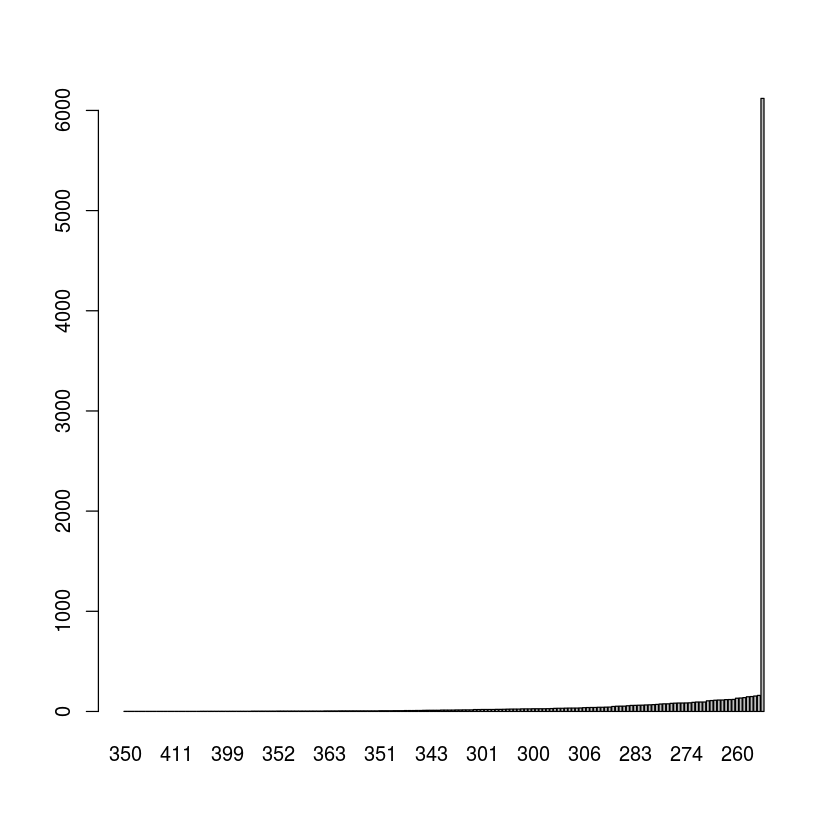

In [17]:
barplot(sort(aa))

By far the most common read length is 255 bp, which is the length to which we trimmed our forward reads. Makes sense, many of our reads overlapped over the entire length of the reverse primer. I wonder if dada2 removes those pesky reverse compliment primers... probably doesn't matter. 

<a id='woodChimeras'></a>
<h3>Remove Chimeras</h3>

In [18]:
woodSeqtab.nochim <- removeBimeraDenovo(woodSeqtab, method="consensus", multithread=TRUE, verbose=TRUE)
dim(woodSeqtab.nochim)

Identified 79 bimeras out of 11541 input sequences.


[1]    98 11462

In [19]:
save(woodSeqtab.nochim, file='woodSeqtab.nochim.rda')

In [20]:
sum(woodSeqtab.nochim)/sum(woodSeqtab); 79/11541

[1] 0.997412

[1] 0.006845161

Not a lot of chimeras in there ...

In [25]:
woodSeqtab.nochim[1:5,1:2]

,AAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCATTAAAGAGTTAATTACAACTCCCAAACCCATGTGAACTTACCTTCTGTTGCCTCGGCAGGTCGTGTTTACCCTGTGAGGTCCTACCCTGTAGGACCCTACCTGGTAGACACGGGTACGCCTGCCGGTGGCCCATGAAACTCTGTTAATTCTATGTTATTCTGAATCTATAACTAAATAAGTTAAAACTTTCAACAACGGATCTCTTGGTTCTG,AAGTCGTAACAAGGTCTCCGTAGGGTGAGTTCAAAAAAATTCTTATTCAGAAAGCTATCTGCTAACCATTTACAGTGAACCTGCGGAGGGATCATTATCGAGTTCAGGGACTCTAACCGAGCCCGGACTTCCCAACCCTTGTGAACAATCTTAGTTGCTTGGGCGGGCCGAGACTTCAAGAGATTTCTCCCCGGCGCTCGCTGGCGCGTGCCCGCCGAAGGTACTTCAAACCCTTCAATTAGTCTGATTTTTGAAAACAATGCCAAAAACTTTCAACAACGGATCTCTTGGTTCTG
Dc-X_F_filt.fastq,49336,0
Dc-PosG_F_filt.fastq,0,0
Dc-PosI_F_filt.fastq,0,0
Dc-Neg_F_filt.fastq,0,0
1w_F_filt.fastq,0,0


<a id='woodTax'></a>
<h2>Assign taxonomy</h2> 